## Cluster 1 and 2 Audio/musical style and Artist success

Successfully loaded Spotify_Dataset_V3.csv with 651936 rows.

--- Starting Phase 1A: Song Master Table ---
Created Song Master Table with 9161 unique songs.
Phase 1A Complete.

--- Starting Phase 1B: Artist Master Table ---
Grouping by 'Artist (Ind.)' column...
Created Artist Master Table with 2208 unique artists.
Artist Master Table saved to 'artist_master_table.csv'.
Phase 1B Complete.

--- Starting Phase 2: Sonic DNA Clustering ---
Audio features have been scaled.
Calculating Elbow Method... (this may take a moment)
Elbow plot saved as 'sonic_cluster_elbow_plot.png'.
Please inspect this plot to choose your 'K'. We will proceed with K=7 as an example.
Running final K-Means with K=7...
Cluster labels assigned to Song Master Table.

--- Sonic Cluster Profiles (Mean Values) ---
               Danceability    Energy      Loudness  Speechiness  \
Sonic_Cluster                                                      
0                  0.727236  0.619522  -6389.714450     0.353159   
1       

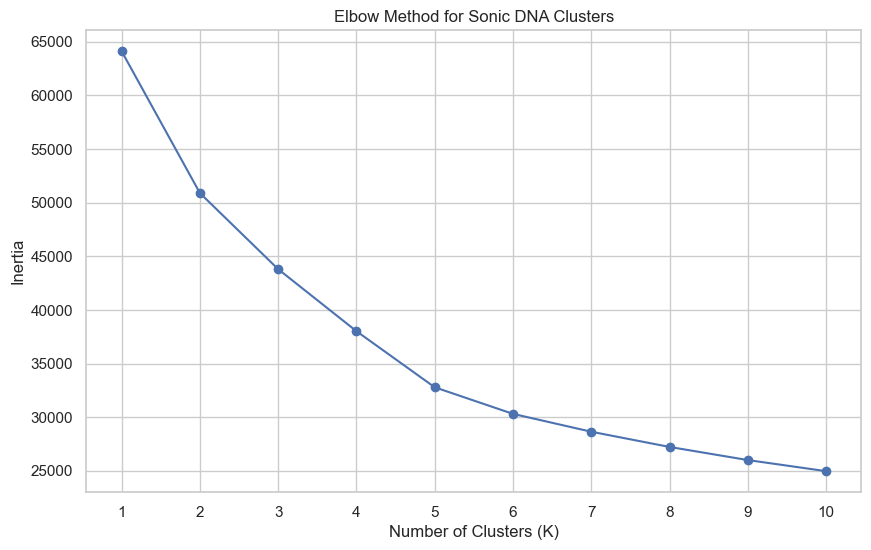

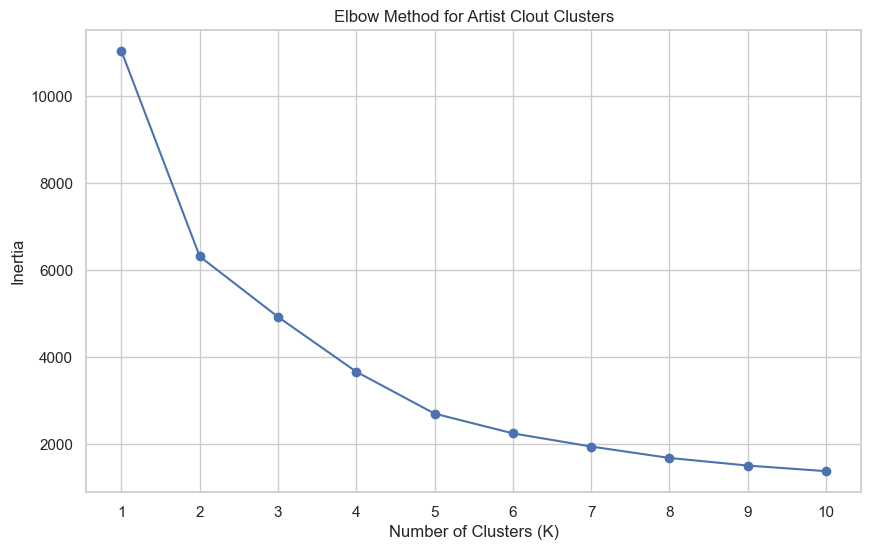

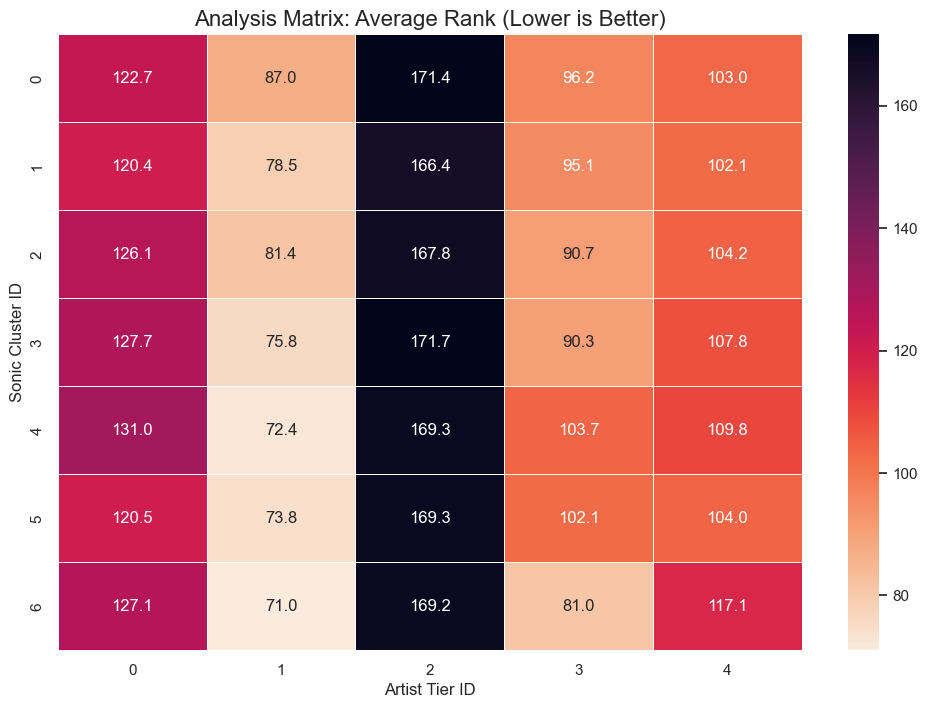

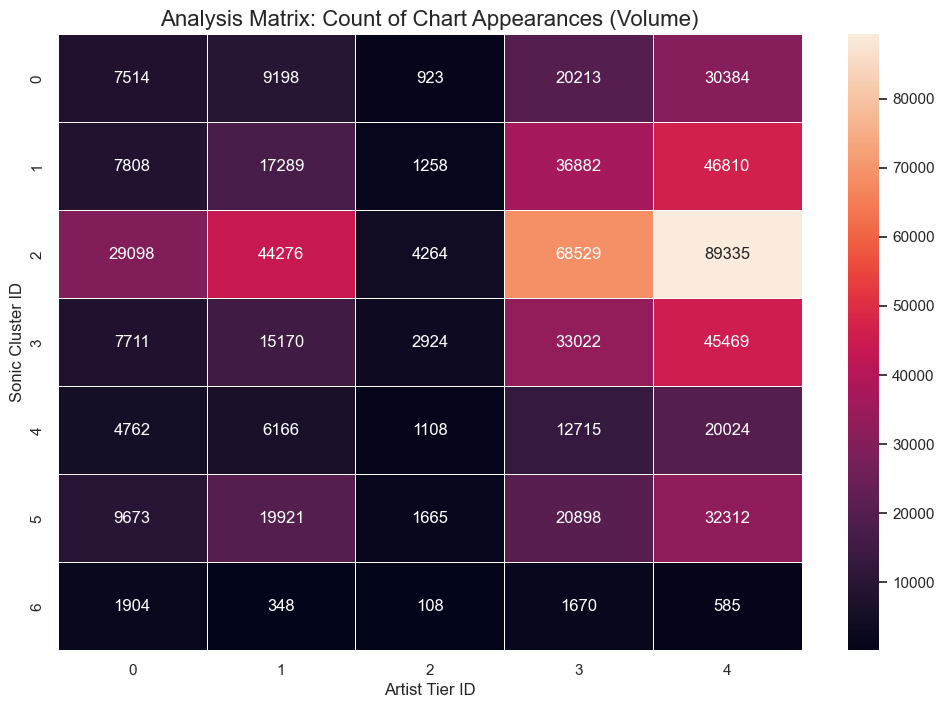

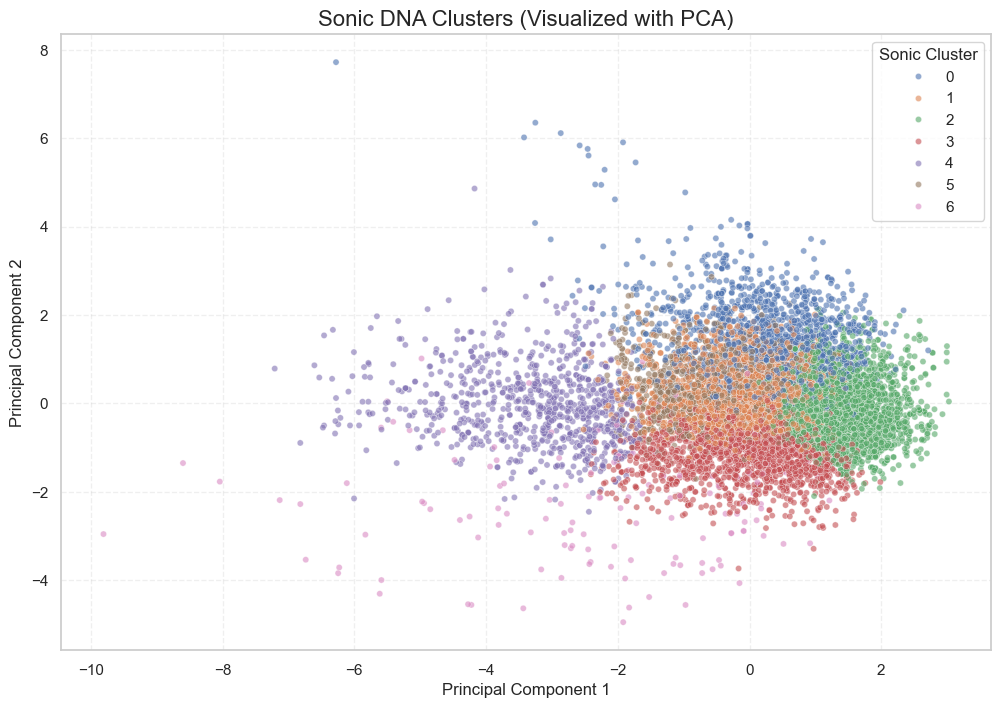

In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Define Your Key Column Names Here ---
# !! Update FILE_PATH. The rest should be correct based on your list. !!
FILE_PATH = 'Spotify_Dataset_V3.csv'

RANK_COLUMN_NAME = 'Rank'
DATE_COLUMN_NAME = 'Date' 
ARTIST_COLUMN_NAME = 'Artist (Ind.)' 
ID_COLUMN_NAME = 'id' 

# These are your audio feature columns
AUDIO_FEATURES = [
    'Danceability', 'Energy', 'Loudness', 'Speechiness', 
    'Acousticness', 'Instrumentalness', 'Valence'
]
# ------------------------------------------

# Load the full dataset
try:
    full_data = pd.read_csv(FILE_PATH,delimiter=';')
except FileNotFoundError:
    print(f"Error: File not found at '{FILE_PATH}'")
    print("Please update the 'FILE_PATH' variable to the correct path.")
    raise

print(f"Successfully loaded {FILE_PATH} with {len(full_data)} rows.")

# --- Phase 1A: Create "Song Master Table" ---

print("\n--- Starting Phase 1A: Song Master Table ---")

# Drop duplicates based on the song 'id'
song_master_table = full_data.drop_duplicates(subset=[ID_COLUMN_NAME]).copy()

print(f"Created Song Master Table with {len(song_master_table)} unique songs.")
print("Phase 1A Complete.")

# --- Phase 1B: Create "Artist Master Table" ---

print("\n--- Starting Phase 1B: Artist Master Table ---")

# 1. Convert columns to the correct type
try:
    full_data[RANK_COLUMN_NAME] = pd.to_numeric(full_data[RANK_COLUMN_NAME], errors='coerce')
    # Added dayfirst=True to fix the date parsing warning
    full_data[DATE_COLUMN_NAME] = pd.to_datetime(full_data[DATE_COLUMN_NAME], dayfirst=True, errors='coerce')
except KeyError as e:
    print(f"KeyError: Could not find column {e}.")
    print("Please check your column name variables at the top of the script.")
    print(f"Your file's columns are: {full_data.columns.tolist()}")
    raise

# 2. Group by the individual artist column
print(f"Grouping by '{ARTIST_COLUMN_NAME}' column...")
artist_grouped = full_data.groupby(ARTIST_COLUMN_NAME)

# 3. Aggregate features
artist_master_table = artist_grouped.agg(
    total_chart_appearances=(ID_COLUMN_NAME, 'count'),
    average_rank=(RANK_COLUMN_NAME, 'mean'),
    best_rank=(RANK_COLUMN_NAME, 'min'),
    career_start=(DATE_COLUMN_NAME, 'min'),
    career_end=(DATE_COLUMN_NAME, 'max'),
).reset_index()

# 4. Calculate more complex features
artist_master_table['career_length_days'] = (artist_master_table['career_end'] - artist_master_table['career_start']).dt.days

# Calculate Top 50 Rate
top_50_hits = full_data[full_data[RANK_COLUMN_NAME] <= 50].groupby(ARTIST_COLUMN_NAME)[ID_COLUMN_NAME].count()

# Merge with the corrected logic (left_on index, right_on column)
artist_master_table = artist_master_table.merge(
    top_50_hits.rename('top_50_hits'), 
    left_on=ARTIST_COLUMN_NAME, 
    right_index=True, 
    how='left'
)

# Fill NaNs for artists with no top 50 hits
artist_master_table['top_50_hits'] = artist_master_table['top_50_hits'].fillna(0)
artist_master_table['top_50_rate'] = artist_master_table['top_50_hits'] / artist_master_table['total_chart_appearances']

print(f"Created Artist Master Table with {len(artist_master_table)} unique artists.")

# 5. Save the result
artist_master_table.to_csv('artist_master_table.csv', index=False)
print("Artist Master Table saved to 'artist_master_table.csv'.")
print("Phase 1B Complete.")


# --- Phase 2: Sonic DNA Clustering ---

print("\n--- Starting Phase 2: Sonic DNA Clustering ---")

# 1. Prepare and Scale the Data
# Select audio features from the unique song table
# Use .loc to avoid potential SettingWithCopyWarning
X_sonic = song_master_table.loc[:, AUDIO_FEATURES].fillna(0) # Fill NaNs just in case

# Scale the data
scaler = StandardScaler()
X_sonic_scaled = scaler.fit_transform(X_sonic)

print("Audio features have been scaled.")

# 2. Find Optimal K (Elbow Method)
inertia = []
k_range = range(1, 11) # Test K from 1 to 10

print("Calculating Elbow Method... (this may take a moment)")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_sonic_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Sonic DNA Clusters')
plt.xticks(k_range)
plt.grid(True)
plt.savefig('sonic_cluster_elbow_plot.png')
print("Elbow plot saved as 'sonic_cluster_elbow_plot.png'.")
print("Please inspect this plot to choose your 'K'. We will proceed with K=7 as an example.")

# 3. Run Final K-Means
# ---
# ** CHOOSE YOUR K HERE ** based on the elbow plot
K_SONIC = 7 
# ---

print(f"Running final K-Means with K={K_SONIC}...")
kmeans_sonic = KMeans(n_clusters=K_SONIC, random_state=42, n_init=10)
kmeans_sonic.fit(X_sonic_scaled)

# 4. Assign & Profile Clusters
# Assign the cluster label back to the song master table
song_master_table['Sonic_Cluster'] = kmeans_sonic.labels_

print("Cluster labels assigned to Song Master Table.")

# 5. Analyze Cluster Profiles
# Group by the new cluster and find the average value
cluster_profiles_sonic = song_master_table.groupby('Sonic_Cluster')[AUDIO_FEATURES].mean()

print("\n--- Sonic Cluster Profiles (Mean Values) ---")
print(cluster_profiles_sonic)

# 6. Save the results
cluster_profiles_sonic.to_csv('sonic_cluster_profiles.csv')
print("\nSonic cluster profiles saved to 'sonic_cluster_profiles.csv'.")

song_master_table.to_csv('song_master_table_with_clusters.csv', index=False)
print("Final song table with clusters saved to 'song_master_table_with_clusters.csv'.")
print("Phase 2 Complete.")
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

print("Phase 3: Starting Artist Clout Clustering...")

# 1. Load the Artist Master Table
try:
    artist_master_table = pd.read_csv('artist_master_table.csv')
except FileNotFoundError:
    print("Error: 'artist_master_table.csv' not found.")
    print("Please make sure you have successfully run the previous script (Phases 1-2).")
    raise

# 2. Select features for clustering
# These are the career metrics we engineered
artist_features = [
    'total_chart_appearances', 
    'average_rank', 
    'best_rank', 
    'career_length_days', 
    'top_50_rate'
]

# Handle potential NaN values (e.g., if an artist has 0 appearances or length)
# We fill with 0, as it represents a lack of that metric.
X_artist = artist_master_table[artist_features].fillna(0)

# 3. Scale the Data
# This is CRITICAL for artist clustering as features are on different scales
scaler = StandardScaler()
X_artist_scaled = scaler.fit_transform(X_artist)

print("Artist career features have been scaled.")

# 4. Find Optimal K (Elbow Method)
inertia = []
k_range = range(1, 11) # Test K from 1 to 10

print("Calculating Elbow Method for artists... (this may take a moment)")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_artist_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Artist Clout Clusters')
plt.xticks(k_range)
plt.grid(True)
plt.savefig('artist_cluster_elbow_plot.png')
print("Elbow plot saved as 'artist_cluster_elbow_plot.png'.")
print("Please inspect this plot to choose your 'K'. We will proceed with K=5 as an example.")

# 5. Run Final K-Means
# ---
# ** CHOOSE YOUR K HERE ** based on the elbow plot
K_ARTIST = 5 
# ---

print(f"Running final K-Means with K={K_ARTIST}...")
kmeans_artist = KMeans(n_clusters=K_ARTIST, random_state=42, n_init=10)
kmeans_artist.fit(X_artist_scaled)

# 6. Assign & Profile Clusters
# Assign the cluster label back to the artist master table
artist_master_table['Artist_Tier'] = kmeans_artist.labels_

print("Cluster labels assigned to Artist Master Table.")

# 7. Analyze Cluster Profiles
# Group by the new cluster and find the average value for each career feature
cluster_profiles_artist = artist_master_table.groupby('Artist_Tier')[artist_features].mean()

print("\n--- Artist Tier Profiles (Mean Values) ---")
print(cluster_profiles_artist)

# Save the profiles to a CSV for easy analysis
cluster_profiles_artist.to_csv('artist_cluster_profiles.csv')
print("\nArtist tier profiles saved to 'artist_cluster_profiles.csv'.")

# Save the final artist table with its new cluster ID
artist_master_table.to_csv('artist_master_table_with_clusters.csv', index=False)
print("Final artist table saved to 'artist_master_table_with_clusters.csv'.")
print("Phase 3 Complete.")
import pandas as pd

# --- Define Your File Paths and Column Names ---
# !! Make sure these are correct !!
ORIGINAL_DATA_FILE = 'Spotify_Dataset_V3.csv'
SONG_CLUSTER_FILE = 'song_master_table_with_clusters.csv'
ARTIST_CLUSTER_FILE = 'artist_master_table_with_clusters.csv'

# Key columns
ID_COLUMN_NAME = 'id'
ARTIST_COLUMN_NAME = 'Artist (Ind.)'
RANK_COLUMN_NAME = 'Rank'
# ------------------------------------------------

print("Phase 4: Starting Final Synthesis...")

# 1. Load all necessary data
try:
    print(f"Loading original dataset: {ORIGINAL_DATA_FILE}...")
    full_data = pd.read_csv(ORIGINAL_DATA_FILE,delimiter=';')

    print(f"Loading song clusters: {SONG_CLUSTER_FILE}...")
    # We only need the ID and the sonic cluster label
    song_clusters = pd.read_csv(SONG_CLUSTER_FILE)[[ID_COLUMN_NAME, 'Sonic_Cluster']]

    print(f"Loading artist tiers: {ARTIST_CLUSTER_FILE}...")
    # We only need the Artist name and their tier label
    artist_tiers = pd.read_csv(ARTIST_CLUSTER_FILE)[[ARTIST_COLUMN_NAME, 'Artist_Tier']]

except FileNotFoundError as e:
    print(f"Error: Could not find a required file. {e}")
    print("Please make sure all previous phases have run successfully and files are in the correct location.")
    raise

# 2. Merge Clusters into the Main Dataset
print("Merging cluster data into main dataset...")

# Merge Sonic_Cluster using the song 'id'
# We use drop_duplicates on the cluster file just in case
analysis_table = full_data.merge(
    song_clusters.drop_duplicates(subset=[ID_COLUMN_NAME]), 
    on=ID_COLUMN_NAME, 
    how='left'
)

# Merge Artist_Tier using the 'Artist (Ind.)' name
analysis_table = analysis_table.merge(
    artist_tiers.drop_duplicates(subset=[ARTIST_COLUMN_NAME]), 
    on=ARTIST_COLUMN_NAME, 
    how='left'
)

# 3. Clean the Final Table
# Drop any rows where the merge failed (e.g., a song or artist wasn't in the master tables)
analysis_table = analysis_table.dropna(subset=['Sonic_Cluster', 'Artist_Tier'])

# Convert cluster labels to integers (they are floats after a merge with NaNs)
analysis_table['Sonic_Cluster'] = analysis_table['Sonic_Cluster'].astype(int)
analysis_table['Artist_Tier'] = analysis_table['Artist_Tier'].astype(int)

# Ensure Rank is numeric for aggregation
analysis_table[RANK_COLUMN_NAME] = pd.to_numeric(analysis_table[RANK_COLUMN_NAME], errors='coerce')

print("Merge complete. Building analysis matrices...")

# 4. Build the Analysis Matrices (The Payoff!)

# --- Matrix 1: What music is being made? (Count of Appearances) ---
# This shows the *volume* of songs for each combination.
# Rows = Sonic Style, Columns = Artist Tier
matrix_count = pd.crosstab(
    index=analysis_table['Sonic_Cluster'],
    columns=analysis_table['Artist_Tier']
)

matrix_count.to_csv('analysis_matrix_count.csv')
print("\n--- Analysis Matrix (Count of Chart Appearances) ---")
print(matrix_count)
print("\nSaved to 'analysis_matrix_count.csv'")


# --- Matrix 2: What music is successful? (Average Rank) ---
# This shows the *performance* of songs for each combination.
# Rows = Sonic Style, Columns = Artist Tier, Values = Average Rank
matrix_rank = pd.crosstab(
    index=analysis_table['Sonic_Cluster'],
    columns=analysis_table['Artist_Tier'],
    values=analysis_table[RANK_COLUMN_NAME],
    aggfunc='mean' # We calculate the average rank
).round(1) # Round to 1 decimal place

matrix_rank.to_csv('analysis_matrix_rank.csv')
print("\n--- Analysis Matrix (Average Rank) ---")
print(matrix_rank)
print("\nSaved to 'analysis_matrix_rank.csv'")

print("\nPhase 4 Complete. Your analysis is ready!")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("Loading analysis matrices for visualization...")

# 1. Load your final analysis files
try:
    matrix_rank = pd.read_csv('analysis_matrix_rank.csv', index_col=0)
    matrix_count = pd.read_csv('analysis_matrix_count.csv', index_col=0)
except FileNotFoundError:
    print("Error: 'analysis_matrix_rank.csv' or 'analysis_matrix_count.csv' not found.")
    print("Please make sure you have successfully run Phase 4.")
    raise

# --- Heatmap 1: Average Rank (Performance) ---
print("Creating Rank heatmap...")
plt.figure(figsize=(12, 8))
# We use 'annot=True' to write the rank number in each cell
# 'fmt='.1f' formats the number to 1 decimal place
# 'cmap="rocket_r"' is a color map where dark colors = lower values (better ranks)
sns.heatmap(
    matrix_rank, 
    annot=True, 
    fmt='.1f', 
    cmap='rocket_r', 
    linewidths=.5
)
plt.title('Analysis Matrix: Average Rank (Lower is Better)', fontsize=16)
plt.xlabel('Artist Tier ID', fontsize=12)
plt.ylabel('Sonic Cluster ID', fontsize=12)
plt.savefig('heatmap_average_rank.png', bbox_inches='tight')
print("Saved 'heatmap_average_rank.png'")


# --- Heatmap 2: Count of Appearances (Volume) ---
print("Creating Count heatmap...")
plt.figure(figsize=(12, 8))
# 'cmap="rocket"' is a color map where dark colors = higher values (more songs)
sns.heatmap(
    matrix_count, 
    annot=True, 
    fmt='g',  # 'g' is for general number format
    cmap='rocket', 
    linewidths=.5
)
plt.title('Analysis Matrix: Count of Chart Appearances (Volume)', fontsize=16)
plt.xlabel('Artist Tier ID', fontsize=12)
plt.ylabel('Sonic Cluster ID', fontsize=12)
plt.savefig('heatmap_count.png', bbox_inches='tight')
print("Saved 'heatmap_count.png'")

print("\nVisualizations complete.")
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

print("\nStarting PCA visualization for Sonic Clusters...")

# 1. Load the song table with clusters from Phase 2
try:
    song_table = pd.read_csv('song_master_table_with_clusters.csv')
except FileNotFoundError:
    print("Error: 'song_master_table_with_clusters.csv' not found.")
    raise

# 2. Define your audio features
AUDIO_FEATURES = [
    'Danceability', 'Energy', 'Loudness', 'Speechiness', 
    'Acousticness', 'Instrumentalness', 'Valence'
]

# 3. Re-scale the audio features
# We must use the same scaling as we did for clustering
X_sonic = song_table[AUDIO_FEATURES].fillna(0)
scaler = StandardScaler()
X_sonic_scaled = scaler.fit_transform(X_sonic)

# 4. Apply PCA
# Reduce the 7 features down to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sonic_scaled)

# 5. Create a new DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Sonic_Cluster'] = song_table['Sonic_Cluster']
# Make sure cluster is treated as a category
pca_df['Sonic_Cluster'] = pca_df['Sonic_Cluster'].astype('category')

print("PCA components created. Now plotting...")

# 6. Plot the results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Sonic_Cluster',  # Color points by their cluster
    palette='deep',       # Use a good color palette
    alpha=0.6,            # Make points slightly transparent
    s=20                  # Set size of points
)
plt.title('Sonic DNA Clusters (Visualized with PCA)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Sonic Cluster')
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig('pca_sonic_clusters.png', bbox_inches='tight')
print("Saved 'pca_sonic_clusters.png'")

## Cluster 3 and 6 : Temporal and performance

DATASET OVERVIEW
Shape: (651936, 20)
Date Range: 2017-01-01 to 2023-05-29
Unique Songs: 9161
Unique Artists: 2928

Missing Values:
Series([], dtype: int64)

Temporal Features Created Successfully!


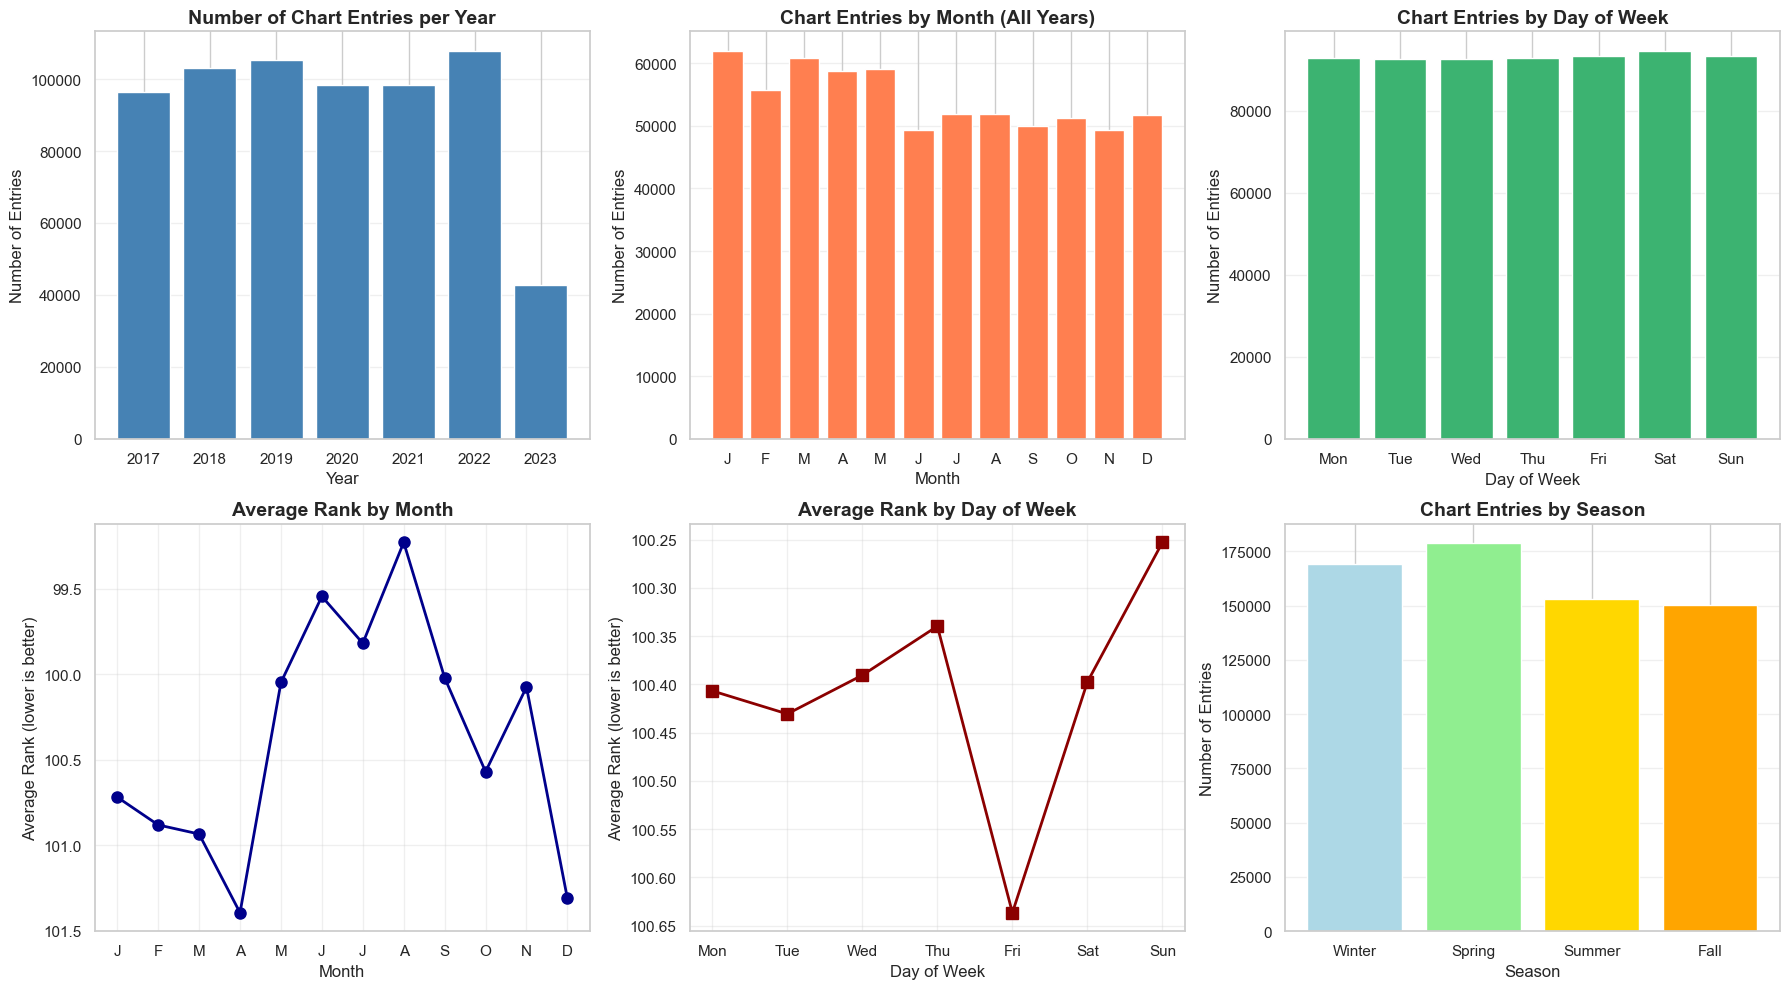


📊 KEY TEMPORAL INSIGHTS:
- Most popular release day: Saturday (94,569 entries)
- Least popular release day: Tuesday (92,476 entries)
- Best performing month (lowest avg rank): August
- Most active season: Spring


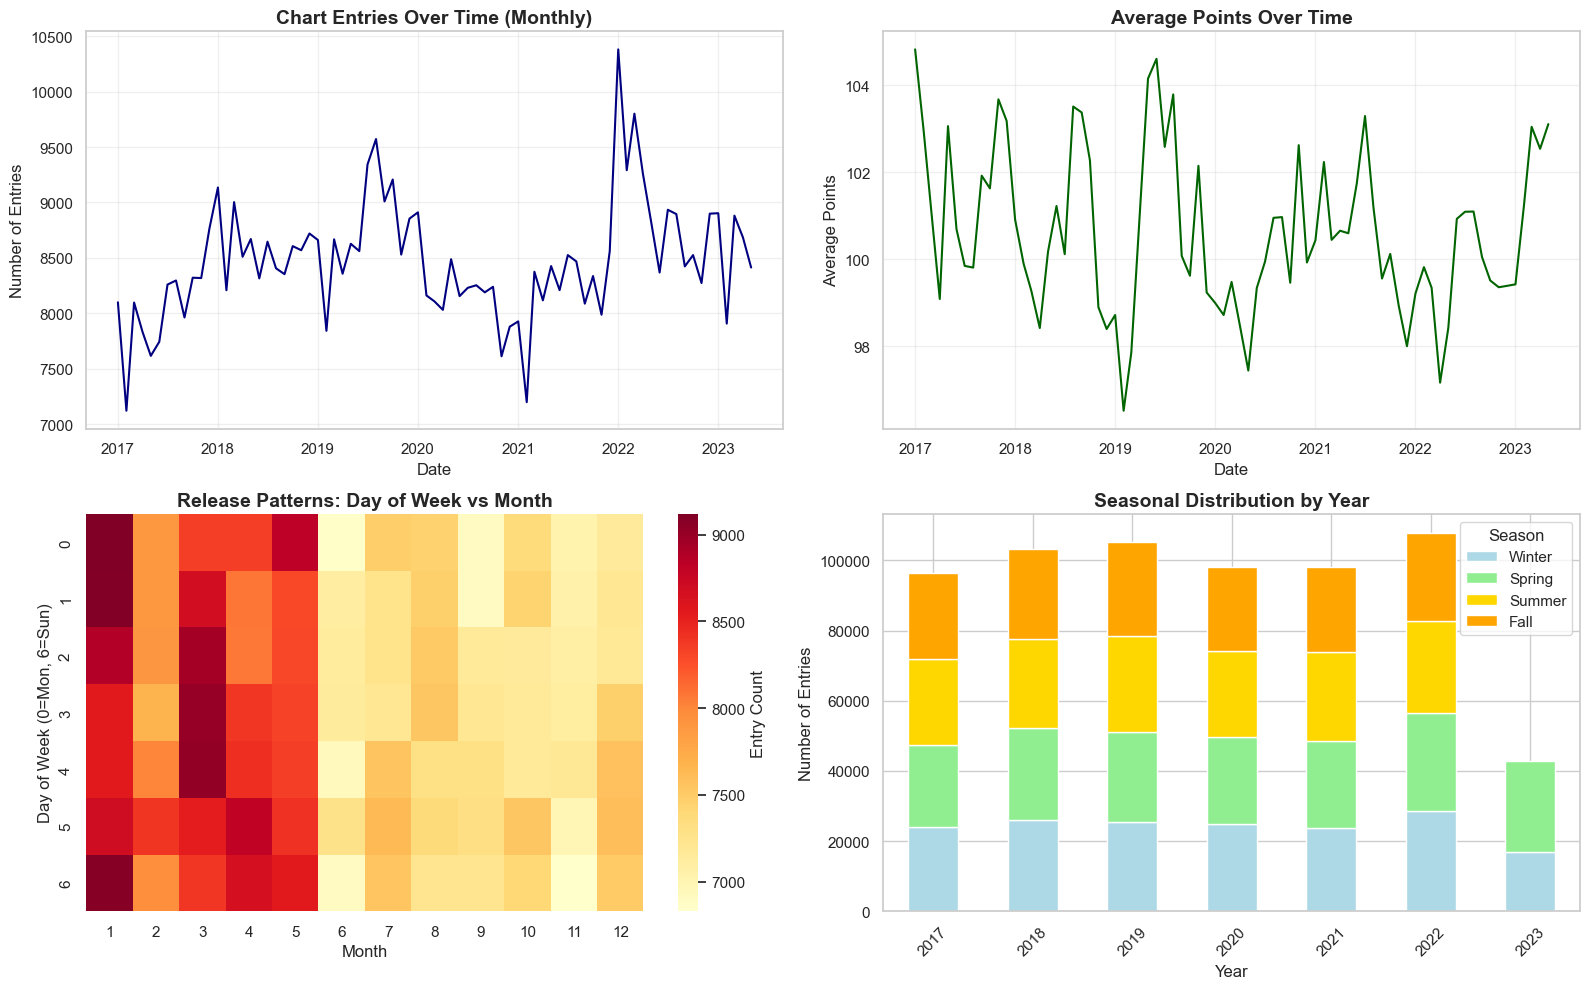


PERFORMANCE METRICS ANALYSIS

Rank Statistics:
count    651936.000000
mean        100.407782
std          57.406664
min           1.000000
25%          51.000000
50%         100.000000
75%         150.000000
max         200.000000
Name: Rank, dtype: float64

Top 10 appearances: 31,417 (4.8%)
Top 50 appearances: 160,965 (24.7%)
Top 100 appearances: 327,895 (50.3%)

Points Statistics:
count    651936.000000
mean        100.592218
std          57.406664
min           1.000000
25%          51.000000
50%         101.000000
75%         150.000000
max         200.000000
Name: Points (Total), dtype: float64

SONG-LEVEL PERFORMANCE STATISTICS
Total unique songs: 9,161

Chart Weeks Distribution:
count    9161.000000
mean       71.164283
std       172.927156
min         1.000000
25%         2.000000
50%         9.000000
75%        56.000000
max      2602.000000
Name: Chart_Weeks, dtype: float64

Songs with 1 week only: 1,783 (19.5%)
Songs with 5+ weeks: 5,761 (62.9%)
Songs with 10+ weeks: 4,542 

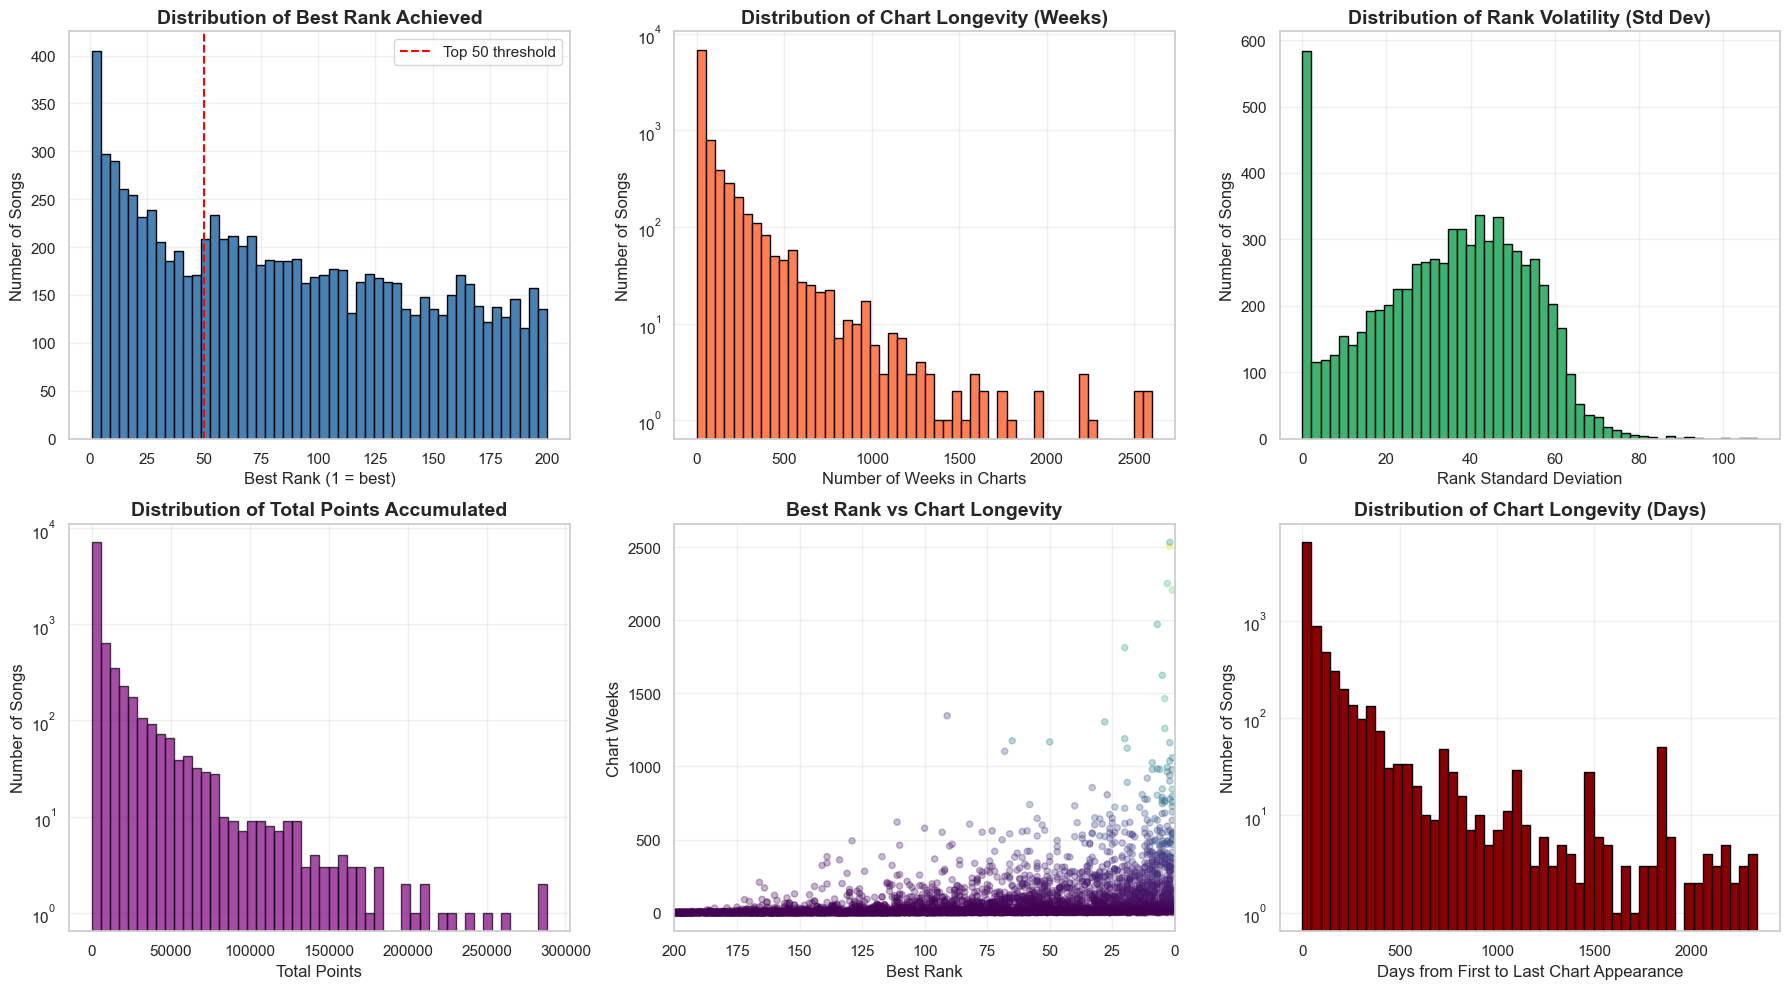

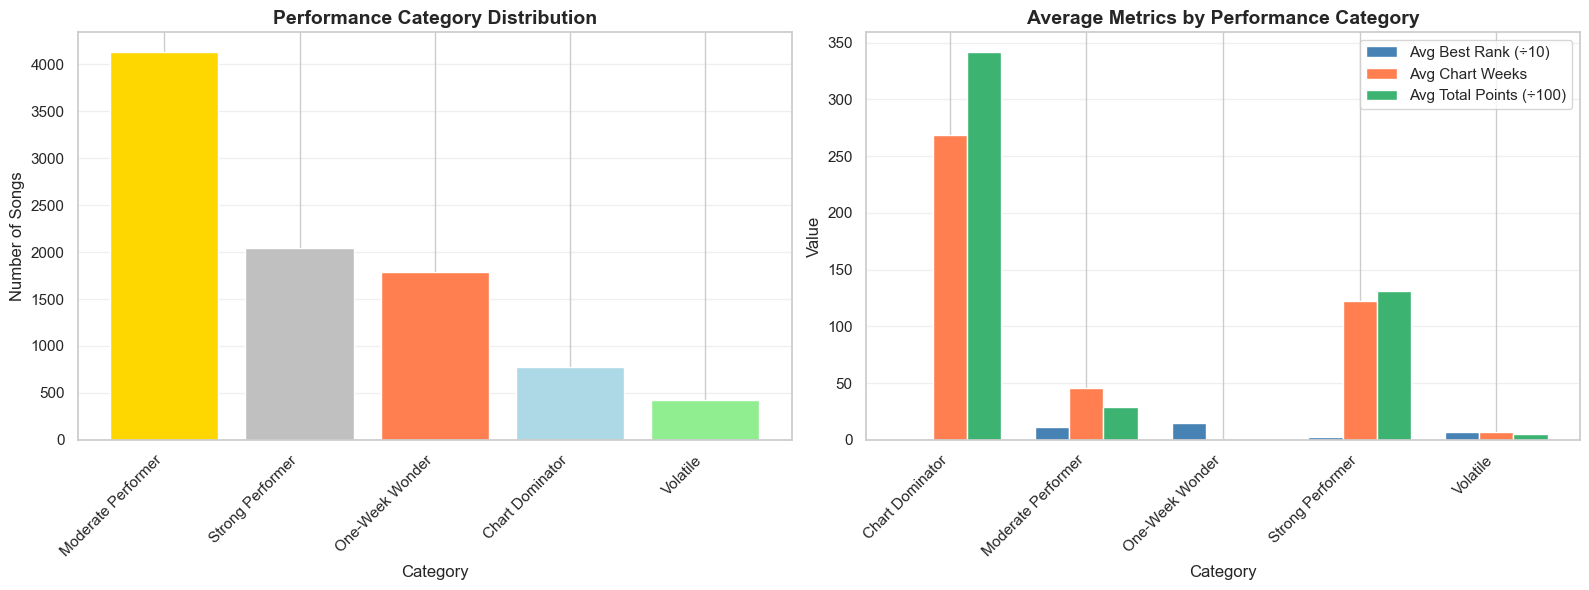


Performance Category Breakdown:
Performance_Category
Moderate Performer    4136
Strong Performer      2043
One-Week Wonder       1783
Chart Dominator        776
Volatile               423
Name: count, dtype: int64

TEMPORAL/ERA CLUSTERING - FEATURE ENGINEERING
Temporal features created for 9,161 songs

Feature columns: 27

Features selected for temporal clustering:
1. Year
2. Month_Sin
3. Month_Cos
4. DayOfWeek_Sin
5. DayOfWeek_Cos
6. IsWeekend
7. Quarter
8. Chart_Weeks
9. Days_In_Charts
10. Weeks_Per_Day_Ratio
11. Quick_Peak_Score
12. Season_Fall
13. Season_Spring
14. Season_Summer
15. Season_Winter

Data's shape for clustering: (9161, 15)
Missing values: 0
Finding optimal number of clusters:
K=3: Inertia=96649.03, Silhouette=0.228, Davies-Bouldin=1.659
K=4: Inertia=80712.57, Silhouette=0.283, Davies-Bouldin=1.477
K=5: Inertia=73180.12, Silhouette=0.294, Davies-Bouldin=1.376
K=6: Inertia=69355.23, Silhouette=0.272, Davies-Bouldin=1.371
K=7: Inertia=65179.70, Silhouette=0.276, Davies-

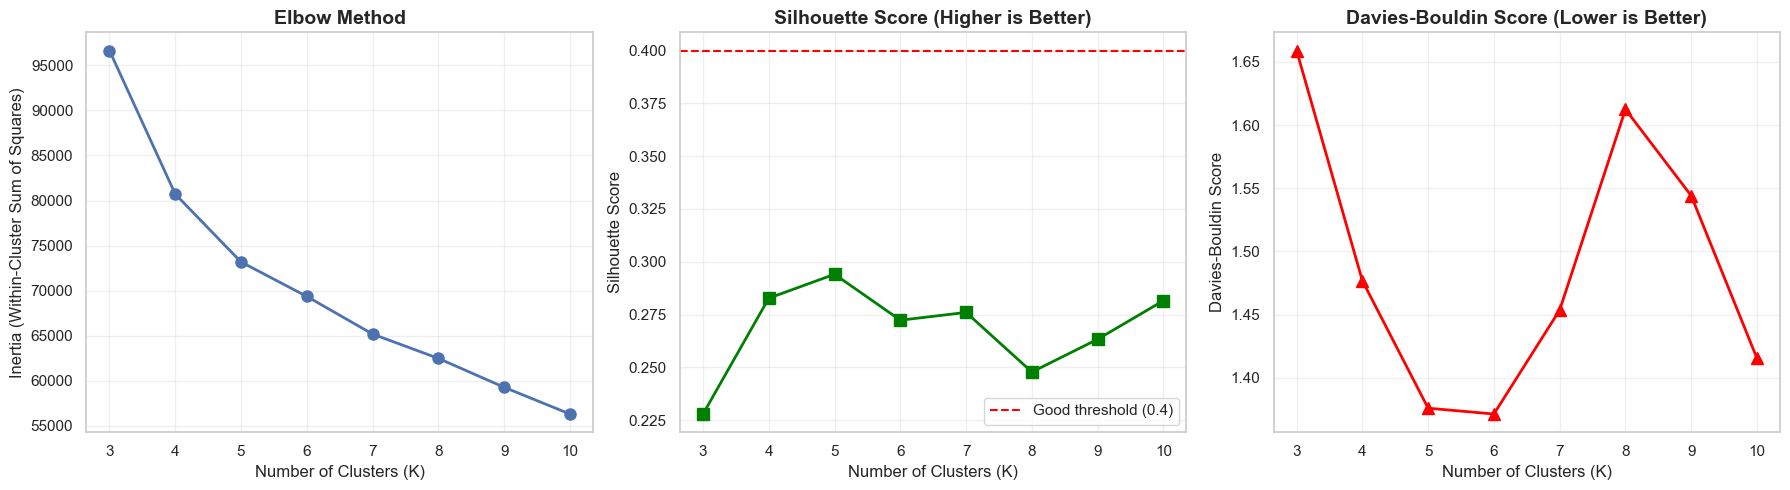


Recommendations:
- Best K by Silhouette Score: 5
- Best K by Davies-Bouldin: 6
- Suggested K for temporal clustering: 5-6 (balance interpretability and quality)

🎯 Performing K-Means clustering with K=6
Temporal clustering done

Cluster distribution:
Temporal_Cluster
0     217
1    2512
2    2037
3     241
4    2030
5    2124
Name: count, dtype: int64

Cluster Profiles:
                  Avg_Year  Avg_Month  Mode_DayOfWeek  Weekend_Rate  \
Temporal_Cluster                                                      
0                  2021.81       9.52               6          0.49   
1                  2020.12       4.10               4          0.20   
2                  2019.79       5.10               4          0.25   
3                  2021.20       5.04               0          0.34   
4                  2019.49      10.06               4          0.19   
5                  2019.38       6.99               4          0.21   

                  Avg_Chart_Weeks  Avg_Days_In_Charts  Av

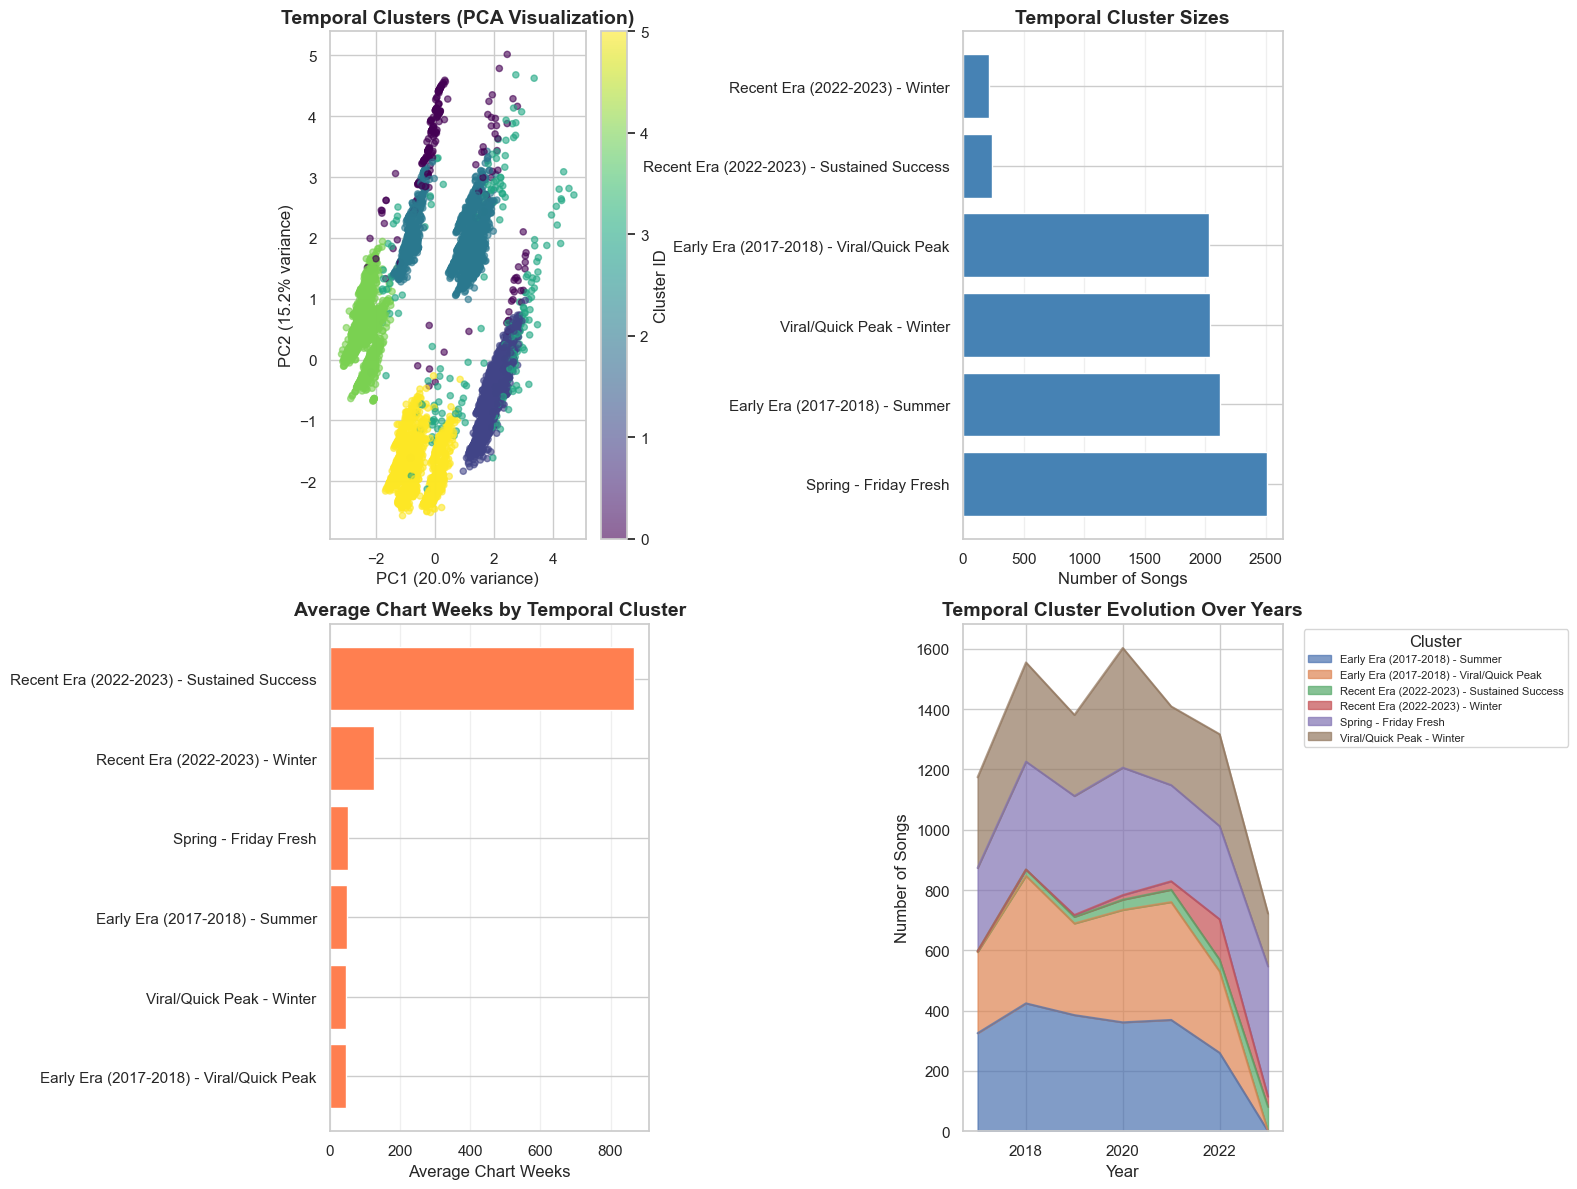


Temporal clustering results saved!
- temporal_features_with_clusters.csv
- temporal_cluster_centroids.csv

PERFORMANCE PATTERN CLUSTERING - FEATURE ENGINEERING
Performance features created for 9,161 songs

Feature columns: 29

Features selected for performance clustering:
1. Best_Rank
2. Avg_Rank
3. Rank_Std
4. Chart_Weeks
5. Total_Points
6. Points_Per_Week
7. Top10_Rate
8. Top50_Rate
9. Rank_Range
10. Volatility_Score
11. Dominance_Score
12. Consistency_Score
13. Rank_Trajectory

Data shape for clustering: (9161, 13)
Any missing values: 0

Feature statistics:
         Best_Rank     Avg_Rank     Rank_Std  Chart_Weeks   Total_Points  \
count  9161.000000  9161.000000  9161.000000  9161.000000    9161.000000   
mean     87.258160   125.453279    34.433567    71.164283    7158.573082   
std      58.544799    43.212389    16.915481   172.927156   19182.912310   
min       1.000000     1.000000     0.000000     1.000000       1.000000   
25%      35.000000    96.474359    24.584383     2.0

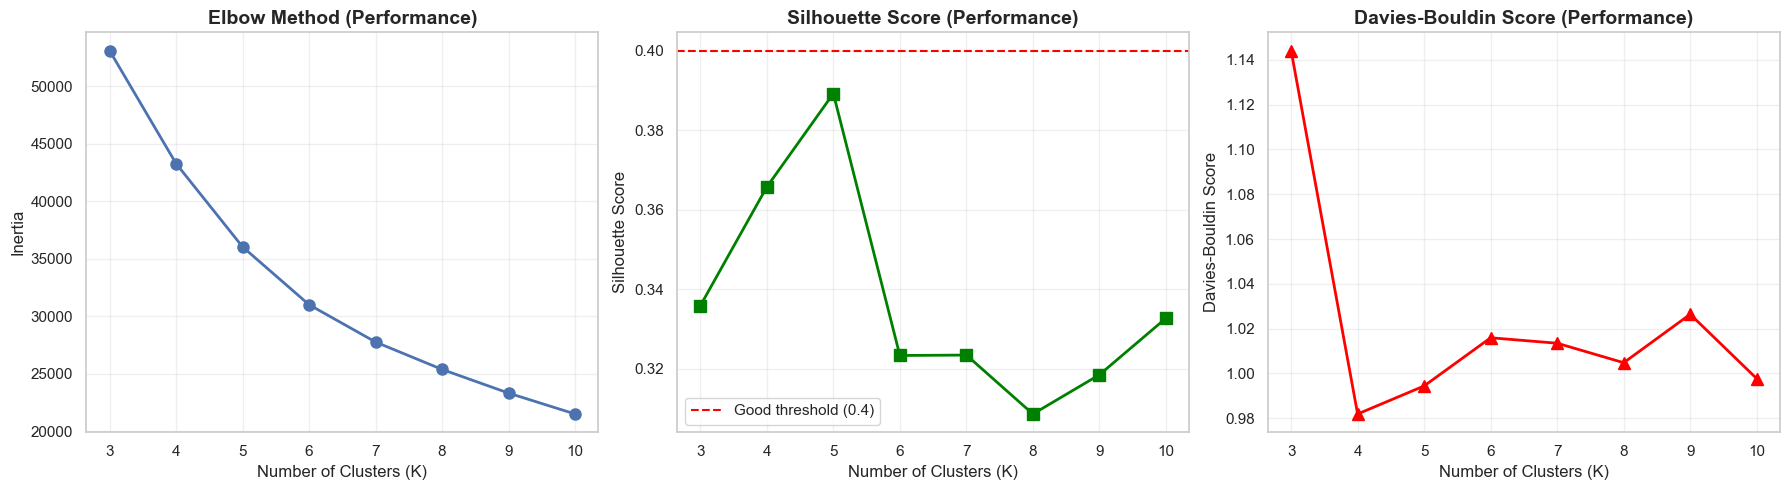


RECOMMENDATIONS:
- Best K by Silhouette Score: 5
- Best K by Davies-Bouldin: 4
- Suggested K for performance clustering: 5 (balance interpretability and quality)

Performing K-Means clustering with K=4
Performance clustering complete!

Cluster distribution:
Performance_Cluster
0    4127
1    3943
2     517
3     574
Name: count, dtype: int64

PERFORMANCE CLUSTER CHARACTERIZATION

Performance Cluster Profiles:
                     Avg_Best_Rank  Avg_Mean_Rank  Avg_Chart_Weeks  \
Performance_Cluster                                                  
0                           134.22         155.37            21.01   
1                            40.32          97.69            59.72   
2                           149.16         149.22             3.03   
3                            16.33          79.62           571.76   

                     Avg_Total_Points  Avg_Points_Per_Week  Avg_Top10_Rate  \
Performance_Cluster                                                          
0        

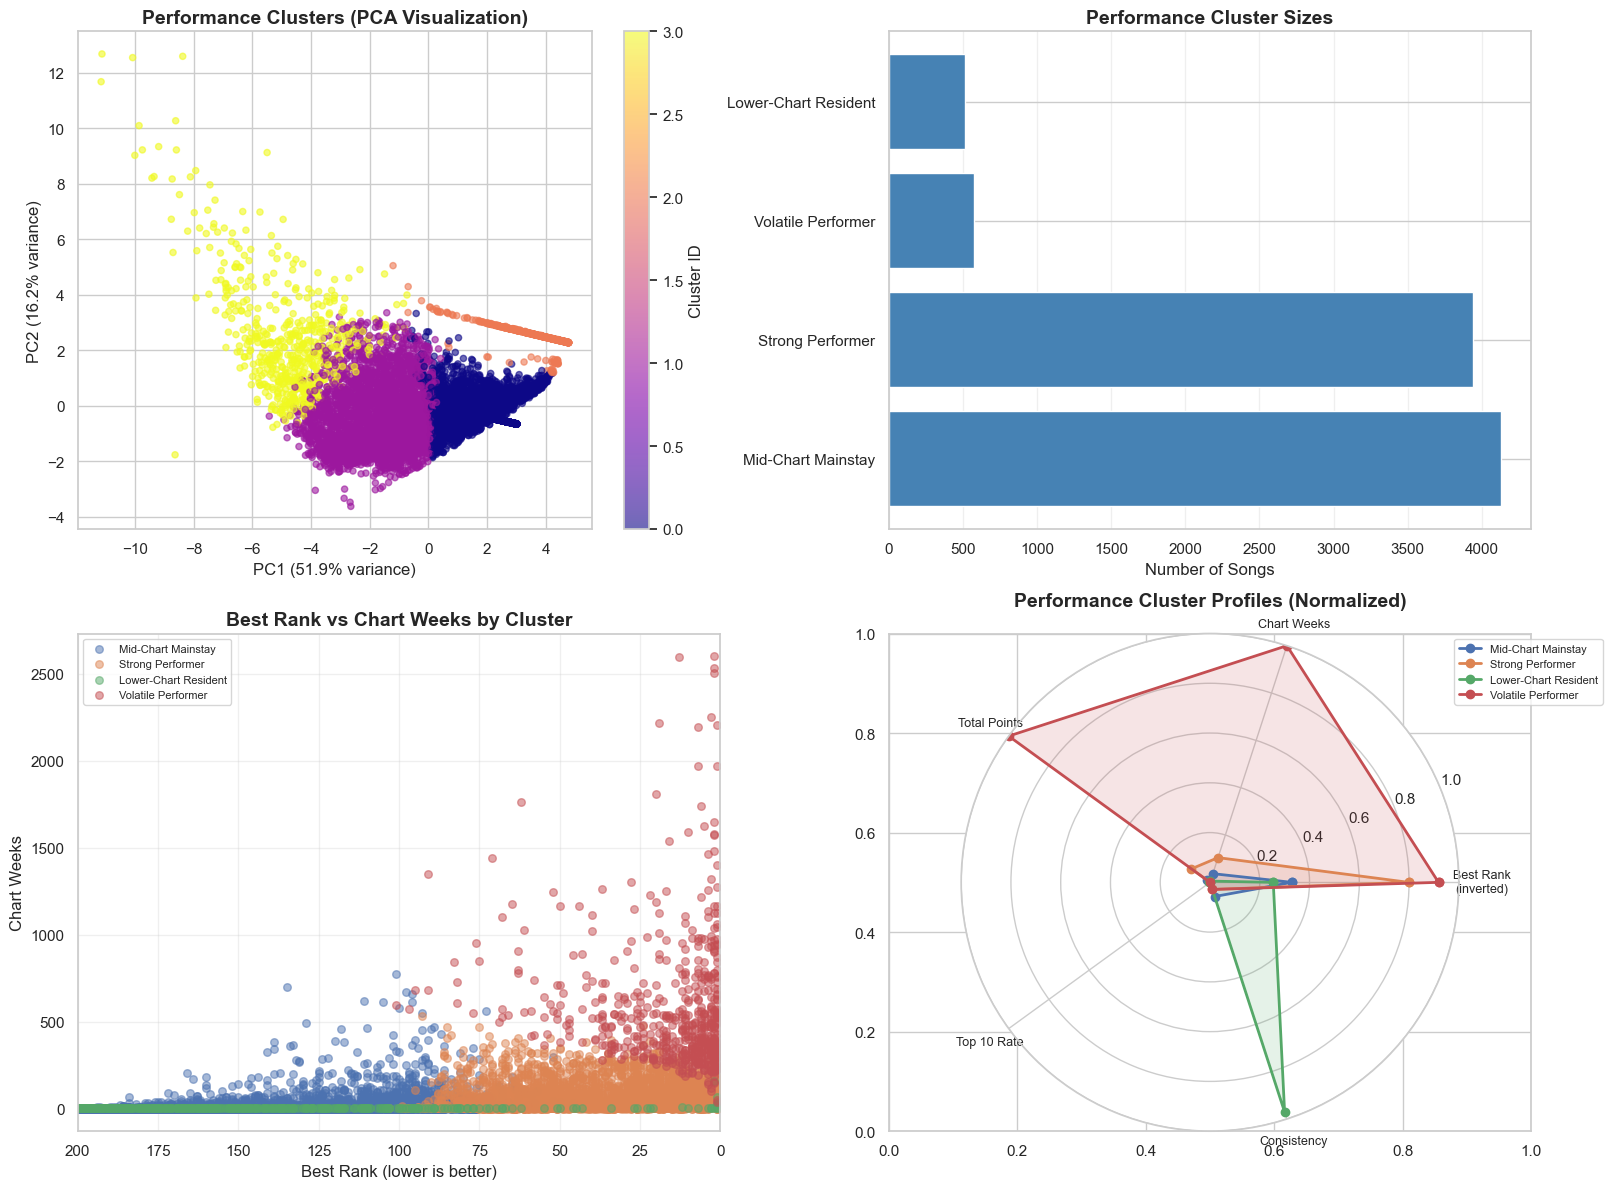


 Performance clustering results saved!
- performance_features_with_clusters.csv
- performance_cluster_centroids.csv
- spotify_data_with_clusters.csv (main file with both cluster assignments)

CLUSTER QUALITY VALIDATION

TEMPORAL CLUSTERS (K=6):
- Silhouette Score: 0.300 Fair
- Davies-Bouldin Score: 1.322 (lower is better)
- Cluster size balance: 1021 std dev

PERFORMANCE CLUSTERS (K=4):
- Silhouette Score: 0.366 Fair
- Davies-Bouldin Score: 0.982 (lower is better)
- Cluster size balance: 2016 std dev

CROSS-CLUSTER ANALYSIS

Cross-Tabulation: Temporal vs Performance Clusters
Performance_Cluster_Name                    Lower-Chart Resident  \
Temporal_Cluster_Name                                              
Early Era (2017-2018) - Summer                               123   
Early Era (2017-2018) - Viral/Quick Peak                     126   
Recent Era (2022-2023) - Sustained Success                     0   
Recent Era (2022-2023) - Winter                                0   
Spring - 

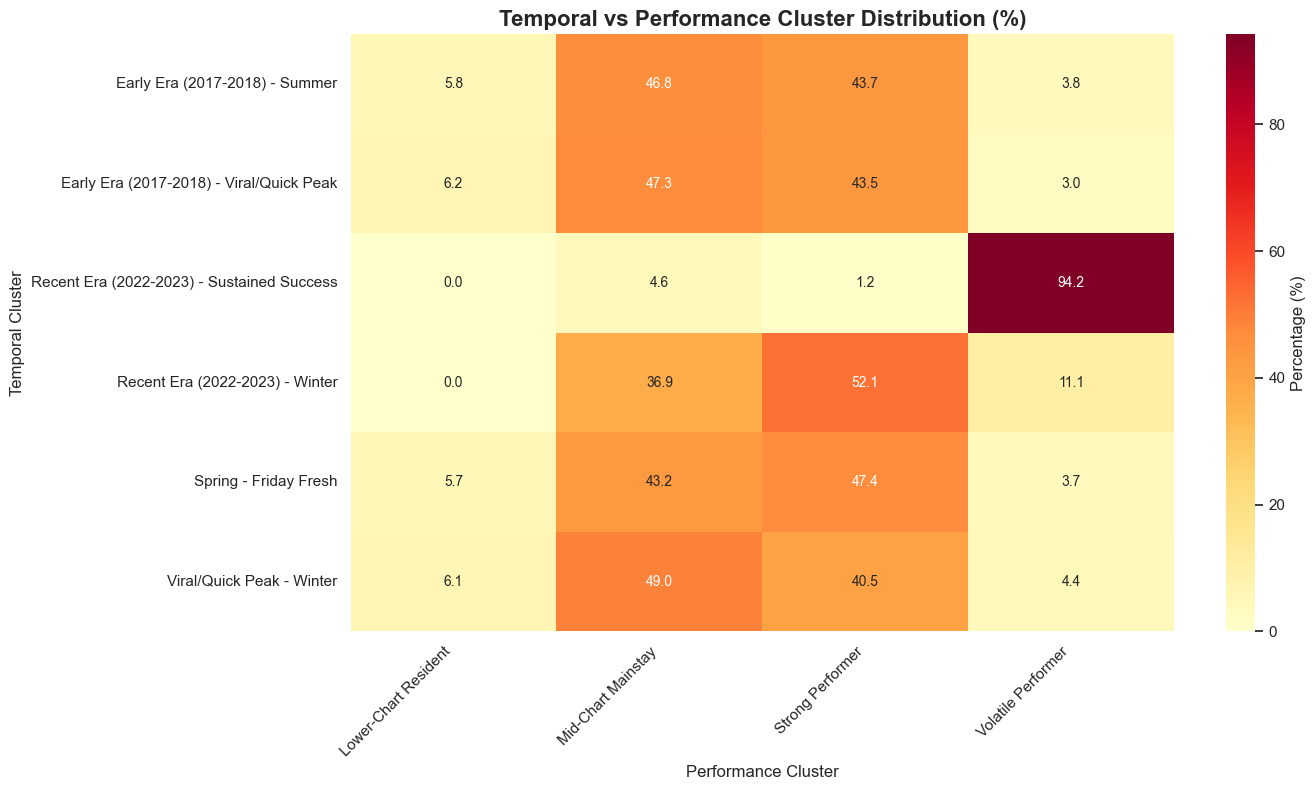


KEY INSIGHTS FROM CROSS-ANALYSIS:
- Early Era (2017-2018) - Viral/Quick Peak: 47.3% are 'Mid-Chart Mainstay'
- Viral/Quick Peak - Winter: 49.0% are 'Mid-Chart Mainstay'
- Early Era (2017-2018) - Summer: 46.8% are 'Mid-Chart Mainstay'
- Recent Era (2022-2023) - Winter: 52.1% are 'Strong Performer'
- Spring - Friday Fresh: 47.4% are 'Strong Performer'
- Recent Era (2022-2023) - Sustained Success: 94.2% are 'Volatile Performer'

CLUSTERING SUMMARY REPORT

DATA OVERVIEW:
- Total songs analyzed: 651,936
- Unique songs: 9,161
- Date range: 2017-01-01 to 2023-05-29

TEMPORAL CLUSTERING:
- Number of clusters: 6
- Silhouette Score: 0.300
- Davies-Bouldin Score: 1.322
- Largest cluster: Spring - Friday Fresh (2,512 songs)
- Smallest cluster: Recent Era (2022-2023) - Winter (217 songs)

PERFORMANCE CLUSTERING:
- Number of clusters: 4
- Silhouette Score: 0.366
- Davies-Bouldin Score: 0.982
- Largest cluster: Mid-Chart Mainstay (4,127 songs)
- Smallest cluster: Lower-Chart Resident (517 songs)

FI

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load data
data_path = os.path.join(os.getcwd(), 'Spotify_Dataset_V3.csv')
df = pd.read_csv(data_path, delimiter = ';') 


# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Basic info
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df.shape}")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Unique Songs: {df['id'].nunique()}")
print(f"Unique Artists: {df['Artists'].nunique()}")
print(f"\nMissing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\n" + "="*60)
# Extract temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['MonthName'] = df['Date'].dt.month_name()
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['DayName'] = df['Date'].dt.day_name()
df['Quarter'] = df['Date'].dt.quarter
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

# Weekend flag
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

print("Temporal Features Created Successfully!")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Songs per Year
yearly_counts = df.groupby('Year').size()
axes[0, 0].bar(yearly_counts.index, yearly_counts.values, color='steelblue')
axes[0, 0].set_title('Number of Chart Entries per Year', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Entries')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Songs per Month (aggregated across all years)
monthly_counts = df.groupby('MonthName').size().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])
axes[0, 1].bar(range(12), monthly_counts.values, color='coral')
axes[0, 1].set_title('Chart Entries by Month (All Years)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Entries')
axes[0, 1].set_xticks(range(12))
axes[0, 1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Songs per Day of Week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = df.groupby('DayName').size().reindex(day_order)
axes[0, 2].bar(range(7), dow_counts.values, color='mediumseagreen')
axes[0, 2].set_title('Chart Entries by Day of Week', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Day of Week')
axes[0, 2].set_ylabel('Number of Entries')
axes[0, 2].set_xticks(range(7))
axes[0, 2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0, 2].grid(axis='y', alpha=0.3)

# Plot 4: Average Rank by Month
monthly_rank = df.groupby('MonthName')['Rank'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])
axes[1, 0].plot(range(12), monthly_rank.values, marker='o', linewidth=2, markersize=8, color='darkblue')
axes[1, 0].set_title('Average Rank by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Rank (lower is better)')
axes[1, 0].set_xticks(range(12))
axes[1, 0].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
axes[1, 0].grid(alpha=0.3)
axes[1, 0].invert_yaxis()  # Lower rank is better

# Plot 5: Average Rank by Day of Week
dow_rank = df.groupby('DayName')['Rank'].mean().reindex(day_order)
axes[1, 1].plot(range(7), dow_rank.values, marker='s', linewidth=2, markersize=8, color='darkred')
axes[1, 1].set_title('Average Rank by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Average Rank (lower is better)')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1, 1].grid(alpha=0.3)
axes[1, 1].invert_yaxis()

# Plot 6: Seasonal Patterns
seasonal_counts = df.groupby('Season').size().reindex(['Winter', 'Spring', 'Summer', 'Fall'])
axes[1, 2].bar(range(4), seasonal_counts.values, color=['lightblue', 'lightgreen', 'gold', 'orange'])
axes[1, 2].set_title('Chart Entries by Season', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Season')
axes[1, 2].set_ylabel('Number of Entries')
axes[1, 2].set_xticks(range(4))
axes[1, 2].set_xticklabels(['Winter', 'Spring', 'Summer', 'Fall'])
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('temporal_eda.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 KEY TEMPORAL INSIGHTS:")
print(f"- Most popular release day: {dow_counts.idxmax()} ({dow_counts.max():,} entries)")
print(f"- Least popular release day: {dow_counts.idxmin()} ({dow_counts.min():,} entries)")
print(f"- Best performing month (lowest avg rank): {monthly_rank.idxmin()}")
print(f"- Most active season: {seasonal_counts.idxmax()}")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Monthly time series of entries
monthly_ts = df.groupby(df['Date'].dt.to_period('M')).size()
monthly_ts.index = monthly_ts.index.to_timestamp()
axes[0, 0].plot(monthly_ts.index, monthly_ts.values, linewidth=1.5, color='navy')
axes[0, 0].set_title('Chart Entries Over Time (Monthly)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Number of Entries')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Average Points over time
monthly_points = df.groupby(df['Date'].dt.to_period('M'))['Points (Total)'].mean()
monthly_points.index = monthly_points.index.to_timestamp()
axes[0, 1].plot(monthly_points.index, monthly_points.values, linewidth=1.5, color='darkgreen')
axes[0, 1].set_title('Average Points Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Average Points')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Heatmap - Day of Week vs Month
pivot_dow_month = df.groupby(['DayOfWeek', 'Month']).size().reset_index(name='count')
pivot_dow_month = pivot_dow_month.pivot(index='DayOfWeek', columns='Month', values='count')
sns.heatmap(pivot_dow_month, annot=False, cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Entry Count'})
axes[1, 0].set_title('Release Patterns: Day of Week vs Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Day of Week (0=Mon, 6=Sun)')

# Plot 4: Year vs Season patterns
pivot_year_season = df.groupby(['Year', 'Season']).size().reset_index(name='count')
pivot_year_season = pivot_year_season.pivot(index='Year', columns='Season', values='count')
pivot_year_season = pivot_year_season[['Winter', 'Spring', 'Summer', 'Fall']]  # Order seasons
pivot_year_season.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                       color=['lightblue', 'lightgreen', 'gold', 'orange'])
axes[1, 1].set_title('Seasonal Distribution by Year', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Entries')
axes[1, 1].legend(title='Season')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('temporal_trends.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n" + "="*60)
print("PERFORMANCE METRICS ANALYSIS")
print("="*60)

# Basic statistics
print("\nRank Statistics:")
print(df['Rank'].describe())
print(f"\nTop 10 appearances: {(df['Rank'] <= 10).sum():,} ({(df['Rank'] <= 10).mean()*100:.1f}%)")
print(f"Top 50 appearances: {(df['Rank'] <= 50).sum():,} ({(df['Rank'] <= 50).mean()*100:.1f}%)")
print(f"Top 100 appearances: {(df['Rank'] <= 100).sum():,} ({(df['Rank'] <= 100).mean()*100:.1f}%)")

print("\nPoints Statistics:")
print(df['Points (Total)'].describe())
# Aggregate to song level for performance analysis
song_performance = df.groupby('id').agg({
    'Rank': ['min', 'mean', 'std', 'count'],
    'Points (Total)': ['sum', 'mean'],
    'Title': 'first',
    'Artists': 'first',
    'Date': ['min', 'max']
}).reset_index()

# Flatten column names
song_performance.columns = ['_'.join(col).strip('_') for col in song_performance.columns.values]
song_performance.columns = ['id', 'Best_Rank', 'Avg_Rank', 'Rank_Std', 'Chart_Weeks', 
                            'Total_Points', 'Avg_Points', 'Title', 'Artists', 
                            'First_Date', 'Last_Date']

# Calculate additional metrics
song_performance['Chart_Longevity_Days'] = (song_performance['Last_Date'] - song_performance['First_Date']).dt.days
song_performance['Peak_Performance'] = 201 - song_performance['Best_Rank']  # Higher is better
song_performance['Consistency'] = 1 / (song_performance['Rank_Std'] + 1)  # High consistency = low std

# Categorize performance
song_performance['Top10_Weeks'] = df[df['Rank'] <= 10].groupby('id').size()
song_performance['Top50_Weeks'] = df[df['Rank'] <= 50].groupby('id').size()
song_performance['Top10_Weeks'] = song_performance['Top10_Weeks'].fillna(0)
song_performance['Top50_Weeks'] = song_performance['Top50_Weeks'].fillna(0)

print("\n" + "="*60)
print("SONG-LEVEL PERFORMANCE STATISTICS")
print("="*60)
print(f"Total unique songs: {len(song_performance):,}")
print(f"\nChart Weeks Distribution:")
print(song_performance['Chart_Weeks'].describe())
print(f"\nSongs with 1 week only: {(song_performance['Chart_Weeks'] == 1).sum():,} ({(song_performance['Chart_Weeks'] == 1).mean()*100:.1f}%)")
print(f"Songs with 5+ weeks: {(song_performance['Chart_Weeks'] >= 5).sum():,} ({(song_performance['Chart_Weeks'] >= 5).mean()*100:.1f}%)")
print(f"Songs with 10+ weeks: {(song_performance['Chart_Weeks'] >= 10).sum():,} ({(song_performance['Chart_Weeks'] >= 10).mean()*100:.1f}%)")
print(f"Songs with 20+ weeks: {(song_performance['Chart_Weeks'] >= 20).sum():,} ({(song_performance['Chart_Weeks'] >= 20).mean()*100:.1f}%)")

# Save for later use
song_performance.to_csv('song_performance_metrics.csv', index=False)
print("\nSong performance metrics saved!")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Best Rank Distribution
axes[0, 0].hist(song_performance['Best_Rank'], bins=50, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Best Rank Achieved', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Best Rank (1 = best)')
axes[0, 0].set_ylabel('Number of Songs')
axes[0, 0].axvline(50, color='red', linestyle='--', label='Top 50 threshold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Chart Weeks Distribution (log scale)
axes[0, 1].hist(song_performance['Chart_Weeks'], bins=50, color='coral', edgecolor='black')
axes[0, 1].set_title('Distribution of Chart Longevity (Weeks)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Weeks in Charts')
axes[0, 1].set_ylabel('Number of Songs')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Rank Volatility
axes[0, 2].hist(song_performance['Rank_Std'].dropna(), bins=50, color='mediumseagreen', edgecolor='black')
axes[0, 2].set_title('Distribution of Rank Volatility (Std Dev)', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Rank Standard Deviation')
axes[0, 2].set_ylabel('Number of Songs')
axes[0, 2].grid(alpha=0.3)

# Plot 4: Total Points
axes[1, 0].hist(song_performance['Total_Points'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Total Points Accumulated', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Points')
axes[1, 0].set_ylabel('Number of Songs')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# Plot 5: Best Rank vs Chart Weeks (scatter)
sample = song_performance.sample(min(5000, len(song_performance)))
axes[1, 1].scatter(sample['Best_Rank'], sample['Chart_Weeks'], 
                   alpha=0.3, s=20, c=sample['Total_Points'], cmap='viridis')
axes[1, 1].set_title('Best Rank vs Chart Longevity', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Best Rank')
axes[1, 1].set_ylabel('Chart Weeks')
axes[1, 1].set_xlim(0, 200)
axes[1, 1].invert_xaxis()
axes[1, 1].grid(alpha=0.3)

# Plot 6: Chart Longevity Days
axes[1, 2].hist(song_performance['Chart_Longevity_Days'], bins=50, color='darkred', edgecolor='black')
axes[1, 2].set_title('Distribution of Chart Longevity (Days)', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Days from First to Last Chart Appearance')
axes[1, 2].set_ylabel('Number of Songs')
axes[1, 2].set_yscale('log')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('performance_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
# Create performance categories for visualization
def categorize_performance(row):
    if row['Best_Rank'] <= 10 and row['Chart_Weeks'] >= 10:
        return 'Chart Dominator'
    elif row['Best_Rank'] <= 50 and row['Chart_Weeks'] >= 5:
        return 'Strong Performer'
    elif row['Chart_Weeks'] == 1:
        return 'One-Week Wonder'
    elif row['Rank_Std'] > 50:
        return 'Volatile'
    else:
        return 'Moderate Performer'

song_performance['Performance_Category'] = song_performance.apply(categorize_performance, axis=1)

# Visualize categories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Category distribution
category_counts = song_performance['Performance_Category'].value_counts()
axes[0].bar(range(len(category_counts)), category_counts.values, 
            color=['gold', 'silver', 'coral', 'lightblue', 'lightgreen'])
axes[0].set_title('Performance Category Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Number of Songs')
axes[0].set_xticks(range(len(category_counts)))
axes[0].set_xticklabels(category_counts.index, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Category characteristics
category_stats = song_performance.groupby('Performance_Category').agg({
    'Best_Rank': 'mean',
    'Chart_Weeks': 'mean',
    'Total_Points': 'mean'
})

x = np.arange(len(category_stats))
width = 0.25

axes[1].bar(x - width, category_stats['Best_Rank']/10, width, label='Avg Best Rank (÷10)', color='steelblue')
axes[1].bar(x, category_stats['Chart_Weeks'], width, label='Avg Chart Weeks', color='coral')
axes[1].bar(x + width, category_stats['Total_Points']/100, width, label='Avg Total Points (÷100)', color='mediumseagreen')

axes[1].set_title('Average Metrics by Performance Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Value')
axes[1].set_xticks(x)
axes[1].set_xticklabels(category_stats.index, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('performance_categories.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPerformance Category Breakdown:")
print(category_counts)
print("\n" + "="*60)
print("TEMPORAL/ERA CLUSTERING - FEATURE ENGINEERING")
print("="*60)

# Create song-level temporal features
temporal_features = df.groupby('id').agg({
    'Date': ['min', 'max'],  # First and last appearance
    'Year': 'first',
    'Month': 'first',
    'DayOfWeek': 'first',
    'IsWeekend': 'first',
    'Season': 'first',
    'Quarter': 'first',
    'Title': 'first',
    'Artists': 'first'
}).reset_index()

# Flatten columns
temporal_features.columns = ['_'.join(col).strip('_') for col in temporal_features.columns.values]
temporal_features.columns = ['id', 'First_Date', 'Last_Date', 'Year', 'Month', 
                             'DayOfWeek', 'IsWeekend', 'Season', 'Quarter',
                             'Title', 'Artists']

# Merge with song performance for additional context
temporal_features = temporal_features.merge(
    song_performance[['id', 'Chart_Weeks', 'Chart_Longevity_Days', 'Best_Rank']],
    on='id',
    how='left'
)

# Calculate temporal behavior features
temporal_features['Days_In_Charts'] = (temporal_features['Last_Date'] - temporal_features['First_Date']).dt.days
temporal_features['Weeks_Per_Day_Ratio'] = temporal_features['Chart_Weeks'] / (temporal_features['Days_In_Charts'] + 1)

# Peak timing - how fast did it peak? (proxy: if Best_Rank is very good and Chart_Weeks is low, it peaked fast)
temporal_features['Quick_Peak_Score'] = (201 - temporal_features['Best_Rank']) / (temporal_features['Chart_Weeks'] + 1)

# Longevity type
temporal_features['Sustained_Presence'] = (temporal_features['Chart_Weeks'] >= 10).astype(int)
temporal_features['Brief_Appearance'] = (temporal_features['Chart_Weeks'] <= 2).astype(int)

# Encode cyclical features (month, day of week)
temporal_features['Month_Sin'] = np.sin(2 * np.pi * temporal_features['Month'] / 12)
temporal_features['Month_Cos'] = np.cos(2 * np.pi * temporal_features['Month'] / 12)
temporal_features['DayOfWeek_Sin'] = np.sin(2 * np.pi * temporal_features['DayOfWeek'] / 7)
temporal_features['DayOfWeek_Cos'] = np.cos(2 * np.pi * temporal_features['DayOfWeek'] / 7)

# Encode season
season_dummies = pd.get_dummies(temporal_features['Season'], prefix='Season')
temporal_features = pd.concat([temporal_features, season_dummies], axis=1)

print(f"Temporal features created for {len(temporal_features):,} songs")
print(f"\nFeature columns: {temporal_features.shape[1]}")
# Select numerical features for clustering
temporal_clustering_features = [
    'Year',
    'Month_Sin', 'Month_Cos',
    'DayOfWeek_Sin', 'DayOfWeek_Cos',
    'IsWeekend',
    'Quarter',
    'Chart_Weeks',
    'Days_In_Charts',
    'Weeks_Per_Day_Ratio',
    'Quick_Peak_Score',
    'Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter'
]

X_temporal = temporal_features[temporal_clustering_features].copy()

# Handle any missing values
X_temporal = X_temporal.fillna(X_temporal.median())

# Check for infinite values
X_temporal = X_temporal.replace([np.inf, -np.inf], np.nan)
X_temporal = X_temporal.fillna(X_temporal.median())

print("\nFeatures selected for temporal clustering:")
for i, feat in enumerate(temporal_clustering_features, 1):
    print(f"{i}. {feat}")

print(f"\nData's shape for clustering: {X_temporal.shape}")
print(f"Missing values: {X_temporal.isnull().sum().sum()}")
# Scale features
scaler_temporal = StandardScaler()
X_temporal_scaled = scaler_temporal.fit_transform(X_temporal)

print("Finding optimal number of clusters:")

# Test different numbers of clusters
k_range = range(3, 11)
inertias = []
silhouette_scores = []
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_temporal_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_temporal_scaled, labels))
    db_scores.append(davies_bouldin_score(X_temporal_scaled, labels))
    
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}, Davies-Bouldin={db_scores[-1]:.3f}")

# Visualize metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow plot
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)')
axes[0].grid(alpha=0.3)

# Silhouette score (higher is better)
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].axhline(0.4, color='red', linestyle='--', label='Good threshold (0.4)')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Davies-Bouldin score (lower is better)
axes[2].plot(k_range, db_scores, marker='^', linewidth=2, markersize=8, color='red')
axes[2].set_title('Davies-Bouldin Score (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('temporal_cluster_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Recommend K
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
best_k_db = k_range[np.argmin(db_scores)]

print(f"\nRecommendations:")
print(f"- Best K by Silhouette Score: {best_k_silhouette}")
print(f"- Best K by Davies-Bouldin: {best_k_db}")
print(f"- Suggested K for temporal clustering: 5-6 (balance interpretability and quality)")
# Choose optimal K (6 for good balance)
optimal_k_temporal = 6

print(f"\n🎯 Performing K-Means clustering with K={optimal_k_temporal}")

# Final clustering
kmeans_temporal = KMeans(n_clusters=optimal_k_temporal, random_state=42, n_init=20, max_iter=500)
temporal_features['Temporal_Cluster'] = kmeans_temporal.fit_predict(X_temporal_scaled)

# Add cluster labels to original dataframe
df = df.merge(
    temporal_features[['id', 'Temporal_Cluster']],
    on='id',
    how='left'
)

print(f"Temporal clustering done")
print(f"\nCluster distribution:")
print(temporal_features['Temporal_Cluster'].value_counts().sort_index())
# Analyze each cluster
cluster_profiles = temporal_features.groupby('Temporal_Cluster').agg({
    'Year': 'mean',
    'Month': 'mean',
    'DayOfWeek': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean(),
    'IsWeekend': 'mean',
    'Chart_Weeks': 'mean',
    'Days_In_Charts': 'mean',
    'Weeks_Per_Day_Ratio': 'mean',
    'Quick_Peak_Score': 'mean',
    'Season_Fall': 'mean',
    'Season_Spring': 'mean',
    'Season_Summer': 'mean',
    'Season_Winter': 'mean',
    'id': 'count'
}).round(2)

cluster_profiles.columns = ['Avg_Year', 'Avg_Month', 'Mode_DayOfWeek', 'Weekend_Rate',
                            'Avg_Chart_Weeks', 'Avg_Days_In_Charts', 'Avg_Weeks_Per_Day',
                            'Avg_Quick_Peak', 'Fall_Rate', 'Spring_Rate', 'Summer_Rate',
                            'Winter_Rate', 'Cluster_Size']

print("\nCluster Profiles:")
print(cluster_profiles)

def name_temporal_cluster_statistical(cluster_id, profile, all_profiles):
    """
    Name clusters by comparing to ALL other clusters, not just overall average
    This creates more distinctive names
    """
    
    # Calculate percentile ranks for each metric across all clusters
    metrics = {
        'Year': profile['Avg_Year'],
        'Chart_Weeks': profile['Avg_Chart_Weeks'],
        'Weekend_Rate': profile['Weekend_Rate'],
        'Quick_Peak': profile['Avg_Quick_Peak'],
        'Weeks_Per_Day': profile['Avg_Weeks_Per_Day']
    }
    
    # Rank this cluster on each metric (0 = lowest, n-1 = highest)
    ranks = {}
    for metric in ['Avg_Year', 'Avg_Chart_Weeks', 'Weekend_Rate', 'Avg_Quick_Peak', 'Avg_Weeks_Per_Day']:
        cluster_values = all_profiles[metric].values
        cluster_rank = np.where(np.sort(cluster_values) == profile[metric])[0][0]
        ranks[metric] = cluster_rank
    
    # Get season info
    season_cols = ['Fall_Rate', 'Spring_Rate', 'Summer_Rate', 'Winter_Rate']
    seasons = ['Fall', 'Spring', 'Summer', 'Winter']
    season_values = [profile['Fall_Rate'], profile['Spring_Rate'], 
                     profile['Summer_Rate'], profile['Winter_Rate']]
    dominant_season_idx = np.argmax(season_values)
    dominant_season = seasons[dominant_season_idx]
    dominant_season_strength = season_values[dominant_season_idx]
    
    # Get month name
    avg_month = int(profile['Avg_Month'])
    month_name = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][avg_month-1]
    
    # Decision logic based on distinctive features
    name_parts = []
    
    # 1. Temporal era (if it's distinctively early or late)
    n_clusters = len(all_profiles)
    if ranks['Avg_Year'] <= 1:  # One of the two earliest
        name_parts.append("Early Era (2017-2018)")
    elif ranks['Avg_Year'] >= n_clusters - 2:  # One of the two latest
        name_parts.append("Recent Era (2022-2023)")
    
    # 2. Performance pattern (if distinctive)
    if ranks['Avg_Chart_Weeks'] >= n_clusters - 1:  # Longest
        if ranks['Avg_Weeks_Per_Day'] >= n_clusters - 2:  # Also concentrated
            name_parts.append("Sustained Success")
        else:
            name_parts.append("Slow Burn Hit")
    elif ranks['Avg_Chart_Weeks'] <= 1:  # Shortest
        if ranks['Avg_Quick_Peak'] >= n_clusters - 2:  # But high peak
            name_parts.append("Viral/Quick Peak")
        else:
            name_parts.append("Brief Charting")
    
    # 3. Seasonal pattern (if strong - >40%)
    if dominant_season_strength > 0.4:
        if dominant_season == 'Winter' and avg_month in [11, 12, 1]:
            name_parts.append("Holiday/Winter")
        elif dominant_season == 'Summer' and avg_month in [6, 7, 8]:
            name_parts.append("Summer")
        else:
            name_parts.append(f"{dominant_season}")
    
    # 4. Release pattern (if distinctive)
    if profile['Weekend_Rate'] > 0.3 and ranks['Weekend_Rate'] >= n_clusters - 2:
        name_parts.append("Weekend Release")
    elif profile['Mode_DayOfWeek'] == 4:  # Friday
        if not name_parts or len(name_parts) == 1:  # Only add if not much else
            name_parts.append("Friday Fresh")
    
    # Construct final name (use up to 2 components for readability)
    if len(name_parts) == 0:
        # Fallback: use most distinctive feature
        final_name = f"{dominant_season} - {month_name} Avg"
    elif len(name_parts) == 1:
        final_name = name_parts[0]
    else:
        # Combine most important parts
        final_name = " - ".join(name_parts[:2])
    
    return final_name

# Apply statistical naming
cluster_names_statistical = {}

print("\n" + "="*60)
print("STATISTICAL NAMING APPROACH")
print("="*60)

for cluster_id in range(optimal_k_temporal):
    profile = cluster_profiles.loc[cluster_id]
    name = name_temporal_cluster_statistical(cluster_id, profile, cluster_profiles)
    cluster_names_statistical[cluster_id] = name
    
    print(f"\nCluster {cluster_id}: {name}")
    print(f"  Size: {profile['Cluster_Size']:.0f} songs")
    print(f"  Year: {profile['Avg_Year']:.1f}")
    print(f"  Chart Weeks: {profile['Avg_Chart_Weeks']:.1f}")
    print(f"  Weekend Rate: {profile['Weekend_Rate']*100:.1f}%")

# Apply to dataframes
temporal_features['Temporal_Cluster_Name'] = temporal_features['Temporal_Cluster'].map(cluster_names_statistical)
df['Temporal_Cluster_Name'] = df['Temporal_Cluster'].map(cluster_names_statistical)

print("\nStatistical naming complete!")
print("\nFinal cluster names:")
for cid, name in cluster_names_statistical.items():
    print(f"  Cluster {cid}: {name}")
# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_temporal_pca = pca.fit_transform(X_temporal_scaled)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: PCA visualization
scatter = axes[0, 0].scatter(X_temporal_pca[:, 0], X_temporal_pca[:, 1], 
                             c=temporal_features['Temporal_Cluster'], 
                             cmap='viridis', alpha=0.6, s=20)
axes[0, 0].set_title('Temporal Clusters (PCA Visualization)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.colorbar(scatter, ax=axes[0, 0], label='Cluster ID')

# Plot 2: Cluster size
cluster_sizes = temporal_features['Temporal_Cluster_Name'].value_counts()
axes[0, 1].barh(range(len(cluster_sizes)), cluster_sizes.values, color='steelblue')
axes[0, 1].set_yticks(range(len(cluster_sizes)))
axes[0, 1].set_yticklabels(cluster_sizes.index)
axes[0, 1].set_title('Temporal Cluster Sizes', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Songs')
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Cluster characteristics - Average Chart Weeks
cluster_char = temporal_features.groupby('Temporal_Cluster_Name')['Chart_Weeks'].mean().sort_values()
axes[1, 0].barh(range(len(cluster_char)), cluster_char.values, color='coral')
axes[1, 0].set_yticks(range(len(cluster_char)))
axes[1, 0].set_yticklabels(cluster_char.index)
axes[1, 0].set_title('Average Chart Weeks by Temporal Cluster', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Average Chart Weeks')
axes[1, 0].grid(axis='x', alpha=0.3)

# Plot 4: Temporal distribution over years
pivot_year_cluster = temporal_features.groupby(['Year', 'Temporal_Cluster_Name']).size().reset_index(name='count')
pivot_year_cluster = pivot_year_cluster.pivot(index='Year', columns='Temporal_Cluster_Name', values='count').fillna(0)
pivot_year_cluster.plot(kind='area', stacked=True, ax=axes[1, 1], alpha=0.7)
axes[1, 1].set_title('Temporal Cluster Evolution Over Years', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Songs')
axes[1, 1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig('temporal_clusters_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
# Save temporal features with clusters
temporal_features.to_csv('temporal_features_with_clusters.csv', index=False)

# Save cluster centroids for future assignment
centroids_temporal = pd.DataFrame(
    scaler_temporal.inverse_transform(kmeans_temporal.cluster_centers_),
    columns=temporal_clustering_features
)
centroids_temporal['Cluster_Name'] = centroids_temporal.index.map(cluster_names_statistical)
centroids_temporal.to_csv('temporal_cluster_centroids.csv', index=False)

print("\nTemporal clustering results saved!")
print(f"- temporal_features_with_clusters.csv")
print(f"- temporal_cluster_centroids.csv")

print("\n" + "="*60)
print("PERFORMANCE PATTERN CLUSTERING - FEATURE ENGINEERING")
print("="*60)


performance_features = song_performance.copy()

# Performance intensity metrics
performance_features['Top10_Rate'] = performance_features['Top10_Weeks'] / performance_features['Chart_Weeks']
performance_features['Top50_Rate'] = performance_features['Top50_Weeks'] / performance_features['Chart_Weeks']

# Rank range (difference between best and worst)
# Need to get worst rank for each song
worst_ranks = df.groupby('id')['Rank'].max().reset_index()
worst_ranks.columns = ['id', 'Worst_Rank']
performance_features = performance_features.merge(worst_ranks, on='id', how='left')

performance_features['Rank_Range'] = performance_features['Worst_Rank'] - performance_features['Best_Rank']

# Volatility score (normalized)
performance_features['Volatility_Score'] = performance_features['Rank_Std'] / performance_features['Avg_Rank']

# Success intensity (points per week)
performance_features['Points_Per_Week'] = performance_features['Total_Points'] / performance_features['Chart_Weeks']

# Dominance score (combine peak and longevity)
performance_features['Dominance_Score'] = (201 - performance_features['Best_Rank']) * np.log1p(performance_features['Chart_Weeks'])

# Consistency score (inverse of volatility, normalized)
performance_features['Consistency_Score'] = 1 / (1 + performance_features['Rank_Std'])

# Chart trajectory
first_ranks = df.sort_values('Date').groupby('id').first()['Rank'].reset_index()
first_ranks.columns = ['id', 'First_Week_Rank']
last_ranks = df.sort_values('Date').groupby('id').last()['Rank'].reset_index()
last_ranks.columns = ['id', 'Last_Week_Rank']

performance_features = performance_features.merge(first_ranks, on='id', how='left')
performance_features = performance_features.merge(last_ranks, on='id', how='left')

performance_features['Rank_Trajectory'] = performance_features['First_Week_Rank'] - performance_features['Last_Week_Rank']  # Positive = improved

# Time to peak (how many weeks to reach best rank)
def calculate_weeks_to_peak(song_id, df_orig):
    song_data = df_orig[df_orig['id'] == song_id].sort_values('Date')
    best_rank = song_data['Rank'].min()
    weeks_to_peak = (song_data[song_data['Rank'] == best_rank].iloc[0]['Date'] - song_data.iloc[0]['Date']).days / 7
    return max(0, weeks_to_peak)

# This is computationally expensive, so sample or use a simplified version
performance_features['Weeks_To_Peak'] = performance_features['Chart_Weeks'] / 2  # Simplified: assume peak at midpoint

print(f"Performance features created for {len(performance_features):,} songs")
print(f"\nFeature columns: {performance_features.shape[1]}")
# Avoid Data Leakage
# Only use features available AFTER the song has completed its chart run
# For prediction tasks, we'd need to be more careful
# Here, we're describing patterns, so we can use outcome-based features

performance_clustering_features = [
    'Best_Rank',
    'Avg_Rank',
    'Rank_Std',
    'Chart_Weeks',
    'Total_Points',
    'Points_Per_Week',
    'Top10_Rate',
    'Top50_Rate',
    'Rank_Range',
    'Volatility_Score',
    'Dominance_Score',
    'Consistency_Score',
    'Rank_Trajectory'
]

X_performance = performance_features[performance_clustering_features].copy()

# Handle missing/infinite values
X_performance = X_performance.replace([np.inf, -np.inf], np.nan)
X_performance = X_performance.fillna(X_performance.median())

print("\nFeatures selected for performance clustering:")
for i, feat in enumerate(performance_clustering_features, 1):
    print(f"{i}. {feat}")

print(f"\nData shape for clustering: {X_performance.shape}")
print(f"Any missing values: {X_performance.isnull().sum().sum()}")

# Check for outliers (optional: you might want to clip extreme values)
print("\nFeature statistics:")
print(X_performance.describe())
# Scale features
scaler_performance = StandardScaler()
X_performance_scaled = scaler_performance.fit_transform(X_performance)

print("\n" + "="*60)
print("FINDING OPTIMAL NUMBER OF CLUSTERS (PERFORMANCE)")
print("="*60)

# Testing different numbers of clusters
k_range_perf = range(3, 11)
inertias_perf = []
silhouette_scores_perf = []
db_scores_perf = []

for k in k_range_perf:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_performance_scaled)
    
    inertias_perf.append(kmeans.inertia_)
    silhouette_scores_perf.append(silhouette_score(X_performance_scaled, labels))
    db_scores_perf.append(davies_bouldin_score(X_performance_scaled, labels))
    
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores_perf[-1]:.3f}, Davies-Bouldin={db_scores_perf[-1]:.3f}")

# Visualizing metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow plot
axes[0].plot(k_range_perf, inertias_perf, marker='o', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method (Performance)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].grid(alpha=0.3)

# Silhouette score
axes[1].plot(k_range_perf, silhouette_scores_perf, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_title('Silhouette Score (Performance)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].axhline(0.4, color='red', linestyle='--', label='Good threshold (0.4)')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Davies-Bouldin score
axes[2].plot(k_range_perf, db_scores_perf, marker='^', linewidth=2, markersize=8, color='red')
axes[2].set_title('Davies-Bouldin Score (Performance)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('performance_cluster_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Recommend K
best_k_silhouette_perf = k_range_perf[np.argmax(silhouette_scores_perf)]
best_k_db_perf = k_range_perf[np.argmin(db_scores_perf)]

print(f"\nRECOMMENDATIONS:")
print(f"- Best K by Silhouette Score: {best_k_silhouette_perf}")
print(f"- Best K by Davies-Bouldin: {best_k_db_perf}")
print(f"- Suggested K for performance clustering: 5 (balance interpretability and quality)")
optimal_k_performance = 4

print(f"\nPerforming K-Means clustering with K={optimal_k_performance}")

# Final clustering
kmeans_performance = KMeans(n_clusters=optimal_k_performance, random_state=42, n_init=20, max_iter=500)
performance_features['Performance_Cluster'] = kmeans_performance.fit_predict(X_performance_scaled)

# Add cluster labels to original dataframe
df = df.merge(
    performance_features[['id', 'Performance_Cluster']],
    on='id',
    how='left'
)

print(f"Performance clustering complete!")
print(f"\nCluster distribution:")
print(performance_features['Performance_Cluster'].value_counts().sort_index())
print("\n" + "="*60)
print("PERFORMANCE CLUSTER CHARACTERIZATION")
print("="*60)

# Analyze each cluster
perf_cluster_profiles = performance_features.groupby('Performance_Cluster').agg({
    'Best_Rank': 'mean',
    'Avg_Rank': 'mean',
    'Chart_Weeks': 'mean',
    'Total_Points': 'mean',
    'Points_Per_Week': 'mean',
    'Top10_Rate': 'mean',
    'Top50_Rate': 'mean',
    'Rank_Std': 'mean',
    'Volatility_Score': 'mean',
    'Dominance_Score': 'mean',
    'Consistency_Score': 'mean',
    'id': 'count'
}).round(2)

perf_cluster_profiles.columns = ['Avg_Best_Rank', 'Avg_Mean_Rank', 'Avg_Chart_Weeks',
                                  'Avg_Total_Points', 'Avg_Points_Per_Week', 'Avg_Top10_Rate',
                                  'Avg_Top50_Rate', 'Avg_Rank_Std', 'Avg_Volatility',
                                  'Avg_Dominance', 'Avg_Consistency', 'Cluster_Size']

print("\nPerformance Cluster Profiles:")
print(perf_cluster_profiles)

# Name clusters based on characteristics
def name_performance_cluster(cluster_id, profile):
    """Assign interpretable names to performance clusters"""
    
    best_rank = profile['Avg_Best_Rank']
    chart_weeks = profile['Avg_Chart_Weeks']
    top10_rate = profile['Avg_Top10_Rate']
    volatility = profile['Avg_Volatility']
    dominance = profile['Avg_Dominance']
    
    # Chart Dominator: Best ranks, long presence
    if best_rank <= 20 and chart_weeks >= 10 and top10_rate > 0.3:
        return "Chart Dominator"
    
    # One-Hit Wonder: Brief appearance, any rank
    elif chart_weeks <= 2:
        return "Brief Charting"
    
    # Volatile: High volatility
    elif volatility > 0.5:
        return "Volatile Performer"
    
    # Mid-tier consistent: Moderate ranks, moderate longevity
    elif best_rank > 50 and chart_weeks >= 5:
        return "Mid-Chart Mainstay"
    
    # Lower-tier: Worse ranks but consistent presence
    elif best_rank > 100:
        return "Lower-Chart Resident"
    
    # Strong performer: Good ranks, decent longevity
    elif best_rank <= 50 and chart_weeks >= 5:
        return "Strong Performer"
    
    else:
        return "Moderate Performer"

# Apply naming
perf_cluster_names = {}
for cluster_id in range(optimal_k_performance):
    profile = perf_cluster_profiles.loc[cluster_id]
    name = name_performance_cluster(cluster_id, profile)
    perf_cluster_names[cluster_id] = name
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id}: {name}")
    print(f"{'='*60}")
    print(f"Size: {profile['Cluster_Size']:.0f} songs ({profile['Cluster_Size']/len(performance_features)*100:.1f}%)")
    print(f"Average Best Rank: {profile['Avg_Best_Rank']:.1f}")
    print(f"Average Mean Rank: {profile['Avg_Mean_Rank']:.1f}")
    print(f"Average Chart Weeks: {profile['Avg_Chart_Weeks']:.1f}")
    print(f"Average Total Points: {profile['Avg_Total_Points']:.1f}")
    print(f"Top 10 Rate: {profile['Avg_Top10_Rate']*100:.1f}%")
    print(f"Top 50 Rate: {profile['Avg_Top50_Rate']*100:.1f}%")
    print(f"Volatility Score: {profile['Avg_Volatility']:.3f}")
    print(f"Dominance Score: {profile['Avg_Dominance']:.1f}")
    
    # Show sample songs
    sample_songs = performance_features[performance_features['Performance_Cluster'] == cluster_id][
        ['Title', 'Artists', 'Best_Rank', 'Chart_Weeks', 'Total_Points']
    ].nlargest(5, 'Total_Points')
    print("\nTop 5 songs by points:")
    print(sample_songs.to_string(index=False))

# Add names to dataframe
performance_features['Performance_Cluster_Name'] = performance_features['Performance_Cluster'].map(perf_cluster_names)
df['Performance_Cluster_Name'] = df['Performance_Cluster'].map(perf_cluster_names)
# Reducing dimensions for visualization
pca_perf = PCA(n_components=2, random_state=42)
X_performance_pca = pca_perf.fit_transform(X_performance_scaled)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: PCA visualization
scatter = axes[0, 0].scatter(X_performance_pca[:, 0], X_performance_pca[:, 1], 
                             c=performance_features['Performance_Cluster'], 
                             cmap='plasma', alpha=0.6, s=20)
axes[0, 0].set_title('Performance Clusters (PCA Visualization)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel(f'PC1 ({pca_perf.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca_perf.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.colorbar(scatter, ax=axes[0, 0], label='Cluster ID')

# Plot 2: Cluster size
perf_cluster_sizes = performance_features['Performance_Cluster_Name'].value_counts()
axes[0, 1].barh(range(len(perf_cluster_sizes)), perf_cluster_sizes.values, color='steelblue')
axes[0, 1].set_yticks(range(len(perf_cluster_sizes)))
axes[0, 1].set_yticklabels(perf_cluster_sizes.index)
axes[0, 1].set_title('Performance Cluster Sizes', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Songs')
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Best Rank vs Chart Weeks by cluster
for cluster_id in range(optimal_k_performance):
    cluster_data = performance_features[performance_features['Performance_Cluster'] == cluster_id]
    axes[1, 0].scatter(cluster_data['Best_Rank'], cluster_data['Chart_Weeks'],
                      label=perf_cluster_names[cluster_id], alpha=0.5, s=30)

axes[1, 0].set_title('Best Rank vs Chart Weeks by Cluster', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Best Rank (lower is better)')
axes[1, 0].set_ylabel('Chart Weeks')
axes[1, 0].set_xlim(0, 200)
axes[1, 0].invert_xaxis()
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(alpha=0.3)

# Plot 4: Radar chart of cluster characteristics
categories = ['Best Rank\n(inverted)', 'Chart Weeks', 'Total Points', 'Top 10 Rate', 'Consistency']

# Normalize values for radar chart
norm_profiles = perf_cluster_profiles.copy()
norm_profiles['Norm_Best_Rank'] = 1 - (norm_profiles['Avg_Best_Rank'] / 200)  # Invert and normalize
norm_profiles['Norm_Chart_Weeks'] = norm_profiles['Avg_Chart_Weeks'] / norm_profiles['Avg_Chart_Weeks'].max()
norm_profiles['Norm_Total_Points'] = norm_profiles['Avg_Total_Points'] / norm_profiles['Avg_Total_Points'].max()
norm_profiles['Norm_Top10_Rate'] = norm_profiles['Avg_Top10_Rate']
norm_profiles['Norm_Consistency'] = norm_profiles['Avg_Consistency']

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax = plt.subplot(2, 2, 4, projection='polar')
for cluster_id in range(optimal_k_performance):
    values = [
        norm_profiles.loc[cluster_id, 'Norm_Best_Rank'],
        norm_profiles.loc[cluster_id, 'Norm_Chart_Weeks'],
        norm_profiles.loc[cluster_id, 'Norm_Total_Points'],
        norm_profiles.loc[cluster_id, 'Norm_Top10_Rate'],
        norm_profiles.loc[cluster_id, 'Norm_Consistency']
    ]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=perf_cluster_names[cluster_id])
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=9)
ax.set_ylim(0, 1)
ax.set_title('Performance Cluster Profiles (Normalized)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)
ax.grid(True)

plt.tight_layout()
plt.savefig('performance_clusters_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
# Save performance features with clusters
performance_features.to_csv('performance_features_with_clusters.csv', index=False)

# Save cluster centroids
centroids_performance = pd.DataFrame(
    scaler_performance.inverse_transform(kmeans_performance.cluster_centers_),
    columns=performance_clustering_features
)
centroids_performance['Cluster_Name'] = centroids_performance.index.map(perf_cluster_names)
centroids_performance.to_csv('performance_cluster_centroids.csv', index=False)

# Save the complete dataframe with both cluster assignments
df.to_csv('spotify_data_with_clusters.csv', index=False)

print("\n Performance clustering results saved!")
print(f"- performance_features_with_clusters.csv")
print(f"- performance_cluster_centroids.csv")
print(f"- spotify_data_with_clusters.csv (main file with both cluster assignments)")

print("\n" + "="*60)
print("CLUSTER QUALITY VALIDATION")
print("="*60)

# Temporal clusters
temporal_silhouette = silhouette_score(X_temporal_scaled, temporal_features['Temporal_Cluster'])
temporal_db = davies_bouldin_score(X_temporal_scaled, temporal_features['Temporal_Cluster'])

print(f"\nTEMPORAL CLUSTERS (K={optimal_k_temporal}):")
print(f"- Silhouette Score: {temporal_silhouette:.3f} {'Good' if temporal_silhouette > 0.4 else 'Fair' if temporal_silhouette > 0.25 else 'Poor'}")
print(f"- Davies-Bouldin Score: {temporal_db:.3f} (lower is better)")
print(f"- Cluster size balance: {temporal_features['Temporal_Cluster'].value_counts().std():.0f} std dev")

# Performance clusters
performance_silhouette = silhouette_score(X_performance_scaled, performance_features['Performance_Cluster'])
performance_db = davies_bouldin_score(X_performance_scaled, performance_features['Performance_Cluster'])

print(f"\nPERFORMANCE CLUSTERS (K={optimal_k_performance}):")
print(f"- Silhouette Score: {performance_silhouette:.3f} {'Good' if performance_silhouette > 0.4 else 'Fair' if performance_silhouette > 0.25 else 'Poor'}")
print(f"- Davies-Bouldin Score: {performance_db:.3f} (lower is better)")
print(f"- Cluster size balance: {performance_features['Performance_Cluster'].value_counts().std():.0f} std dev")
print("\n" + "="*60)
print("CROSS-CLUSTER ANALYSIS")
print("="*60)

# Merge both cluster assignments for analysis
cluster_analysis = performance_features[['id', 'Performance_Cluster_Name']].merge(
    temporal_features[['id', 'Temporal_Cluster_Name']],
    on='id',
    how='inner'
)

# Cross-tabulation
cross_tab = pd.crosstab(
    cluster_analysis['Temporal_Cluster_Name'],
    cluster_analysis['Performance_Cluster_Name'],
    margins=True
)

print("\nCross-Tabulation: Temporal vs Performance Clusters")
print(cross_tab)

# Visualize cross-tabulation as heatmap
plt.figure(figsize=(14, 8))
cross_tab_pct = pd.crosstab(
    cluster_analysis['Temporal_Cluster_Name'],
    cluster_analysis['Performance_Cluster_Name'],
    normalize='index'
) * 100

sns.heatmap(cross_tab_pct, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage (%)'})
plt.title('Temporal vs Performance Cluster Distribution (%)', fontsize=16, fontweight='bold')
plt.xlabel('Performance Cluster', fontsize=12)
plt.ylabel('Temporal Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('cluster_crosstab_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Find interesting patterns
print("\nKEY INSIGHTS FROM CROSS-ANALYSIS:")
for temp_cluster in cluster_analysis['Temporal_Cluster_Name'].unique():
    temp_data = cluster_analysis[cluster_analysis['Temporal_Cluster_Name'] == temp_cluster]
    dominant_perf = temp_data['Performance_Cluster_Name'].mode()[0]
    pct = (temp_data['Performance_Cluster_Name'] == dominant_perf).mean() * 100
    print(f"- {temp_cluster}: {pct:.1f}% are '{dominant_perf}'")
print("\n" + "="*60)
print("CLUSTERING SUMMARY REPORT")
print("="*60)

summary_report = f"""
DATA OVERVIEW:
- Total songs analyzed: {len(df):,}
- Unique songs: {df['id'].nunique():,}
- Date range: {df['Date'].min().date()} to {df['Date'].max().date()}

TEMPORAL CLUSTERING:
- Number of clusters: {optimal_k_temporal}
- Silhouette Score: {temporal_silhouette:.3f}
- Davies-Bouldin Score: {temporal_db:.3f}
- Largest cluster: {temporal_features['Temporal_Cluster_Name'].value_counts().index[0]} ({temporal_features['Temporal_Cluster_Name'].value_counts().values[0]:,} songs)
- Smallest cluster: {temporal_features['Temporal_Cluster_Name'].value_counts().index[-1]} ({temporal_features['Temporal_Cluster_Name'].value_counts().values[-1]:,} songs)

PERFORMANCE CLUSTERING:
- Number of clusters: {optimal_k_performance}
- Silhouette Score: {performance_silhouette:.3f}
- Davies-Bouldin Score: {performance_db:.3f}
- Largest cluster: {performance_features['Performance_Cluster_Name'].value_counts().index[0]} ({performance_features['Performance_Cluster_Name'].value_counts().values[0]:,} songs)
- Smallest cluster: {performance_features['Performance_Cluster_Name'].value_counts().index[-1]} ({performance_features['Performance_Cluster_Name'].value_counts().values[-1]:,} songs)

FILES GENERATED:
temporal_features_with_clusters.csv
temporal_cluster_centroids.csv
performance_features_with_clusters.csv
performance_cluster_centroids.csv
spotify_data_with_clusters.csv
Multiple visualization PNG files

NEXT STEPS:
1. Review cluster names and characteristics
2. Use these cluster assignments as meta-features for prediction tasks
3. Implement additional clustering dimensions (audio, artist tier, network, etc.)
4. Build prediction models using cluster memberships
"""

print(summary_report)

# Save report
with open('clustering_summary_report.txt', 'w') as f:
    f.write(summary_report)

print("\nSummary report saved to 'clustering_summary_report.txt'")


## Cluster 4 : Collaboration 

Unique raw artist entries: 2208
Unique normalized artists: 2200
Unique canonical artists: 2200

Sample normalization (norm -> canonical):
'070 shake' -> '070 Shake'
'13 organise' -> '13 Organisé'
'187 strassenbande' -> '187 Strassenbande'
'2 chainz' -> '2 Chainz'
'21 savage' -> '21 Savage'
'22 savage' -> '22 Savage'
'24kgoldn' -> '24kGoldn'
'2pac' -> '2Pac'
'347aidan' -> '347aidan'
'42 dugg' -> '42 Dugg'
Rows total: 651936
Graph built on train set: nodes=2200, edges=3078
Connected components: 777
Degree: min=0, max=62, mean=2.80
Computing exact betweenness centrality (may take a while for large graphs)...


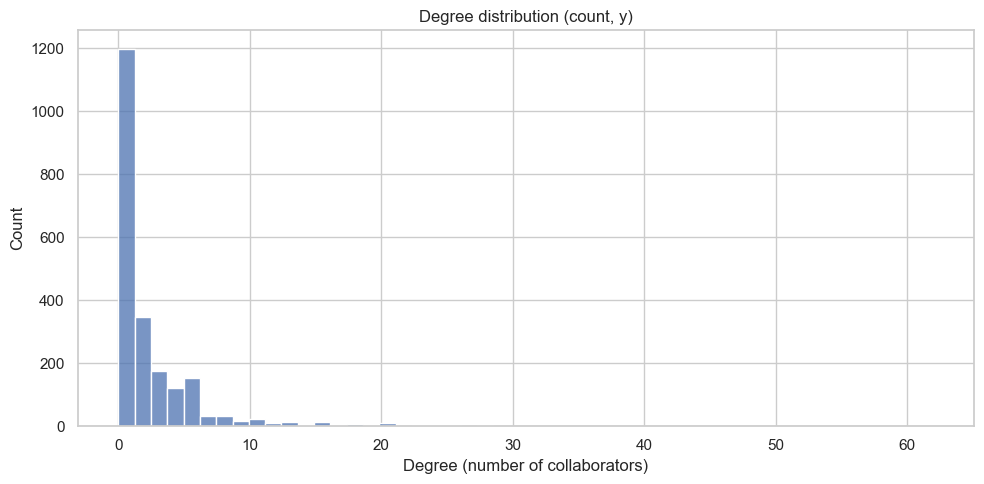

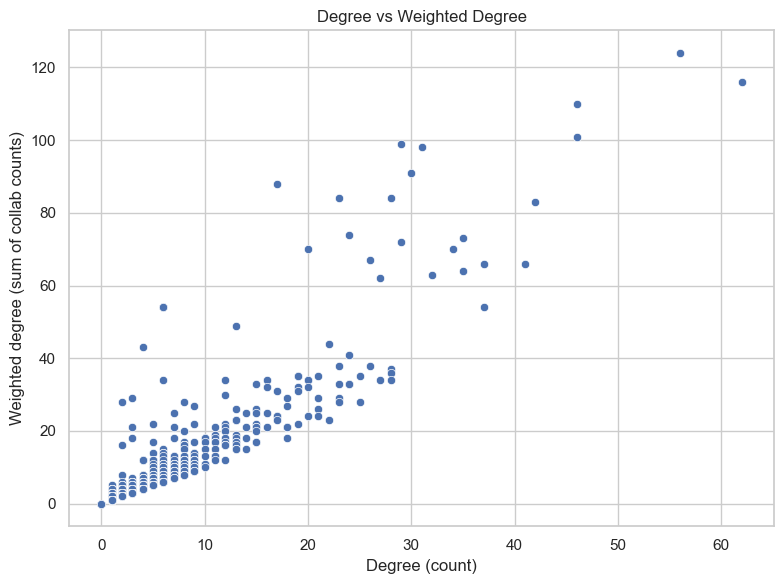

,artist,degree,degree_weighted,betweenness,eigenvector
823,J Balvin,56,124,0.047949,0.214768
180,Bad Bunny,62,116,0.023187,0.250787
123,Anuel AA,46,110,0.017706,0.249205
1519,Ozuna,46,101,0.008387,0.248131
1998,Travis Scott,29,99,0.005295,0.010691
1736,Sech,31,98,0.001513,0.211048
683,Future,30,91,0.025819,0.026733
1345,Metro Boomin,17,88,0.001122,0.007466
1103,Lenny Tavárez,28,84,0.001677,0.146114
8,21 Savage,23,84,0.003261,0.008125


Artist feature matrix shape (train artists): (2200, 13)
Scaled training feature matrix shape: (2200, 13)
K=3: inertia=20346.0, silhouette=0.2233
K=4: inertia=18847.5, silhouette=0.1504
K=5: inertia=17207.3, silhouette=0.1609
K=6: inertia=15841.9, silhouette=0.1679
K=7: inertia=14660.9, silhouette=0.1471


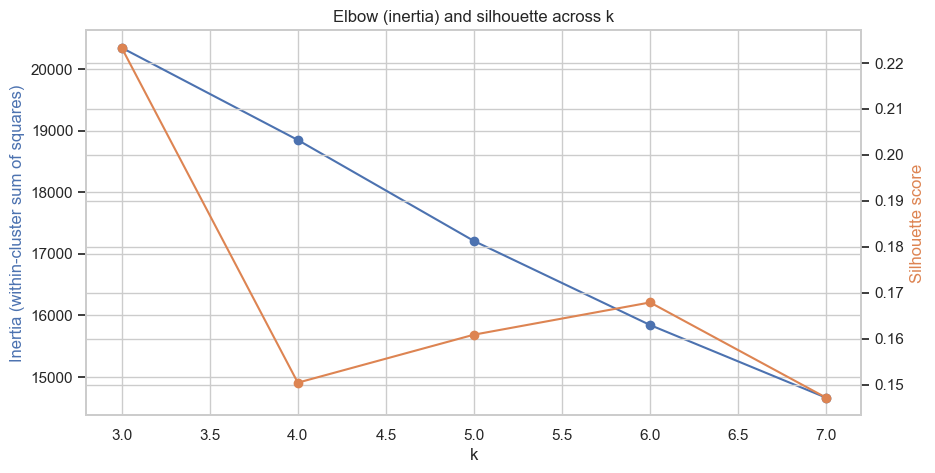

Selected best_k (by silhouette): 3
Cluster sizes (train):
0    1617
1      82
2     501
Name: count, dtype: int64
Training silhouette score: 0.2233
Training Davies–Bouldin index: 1.5963


,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,n_tracks,avg_points,degree,degree_weighted,betweenness,eigenvector
cluster,,,,,,,,,,,,,
0,0.717358,0.717505,-4775.546225,0.133927,0.178124,0.009010,0.593393,175.401361,40.748170,2.317873,3.296846,0.000244,0.002913
1,0.732472,0.673934,-4877.164281,0.140808,0.198896,0.005293,0.537345,3119.768293,59.716356,22.841463,43.207317,0.008147,0.066296
2,0.575935,0.476116,-8372.471957,0.077113,0.487314,0.025576,0.402644,224.532934,58.233105,1.067864,1.357285,0.000094,0.000214


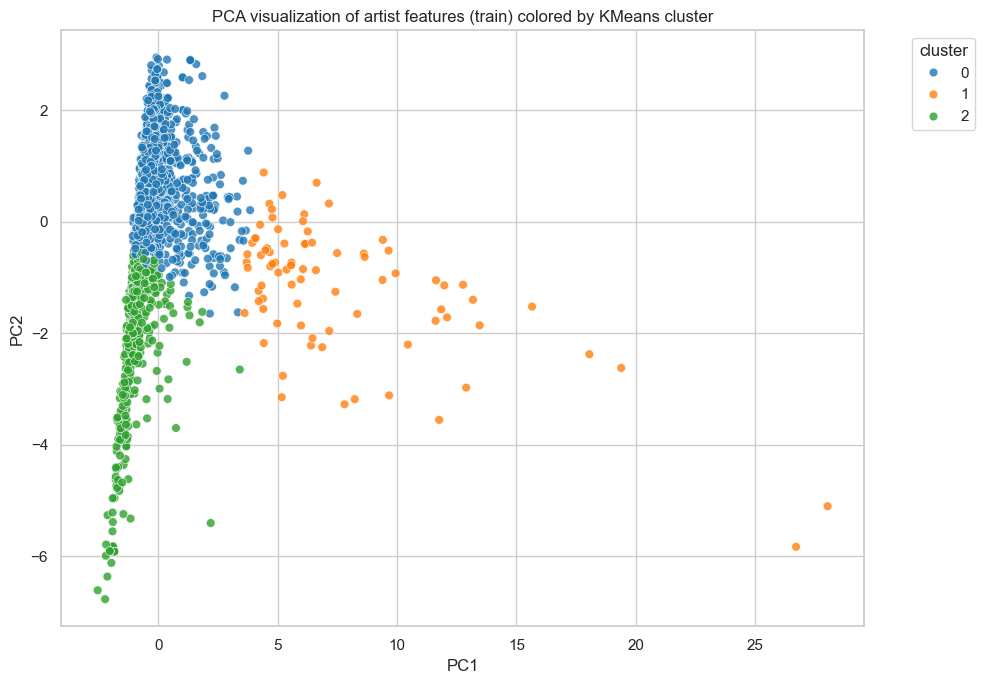


Cluster 0 - size 1617
 Top by weighted-degree:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
551,Dulce María,6,54,0.000000e+00,9
371,Christopher von Uckermann,6,54,0.000000e+00,9
102,Anahí,6,54,0.000000e+00,9
80,Alfonso Herrera,6,54,0.000000e+00,9
366,Christian Chávez,6,54,0.000000e+00,9
1603,RBD,6,54,0.000000e+00,9
1260,Maite Perroni,6,54,0.000000e+00,41
794,Huncho Jack,4,43,4.344766e-07,79


 Top by betweenness:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
1523,PEDRO SAMPAIO,4,4,0.007016,176
164,BIA,5,10,0.006740,245
1552,Peso Pluma,11,17,0.006736,903
104,Anderson .Paak,3,29,0.006349,624
1605,RM,15,17,0.006339,50
1317,Mc Danny,8,8,0.006230,114
1690,SCH,11,19,0.005598,77
112,Angèle,2,2,0.005426,55



Cluster 1 - size 82
 Top by weighted-degree:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
823,J Balvin,56,124,0.047949,10659
180,Bad Bunny,62,116,0.023187,16624
123,Anuel AA,46,110,0.017706,5541
1519,Ozuna,46,101,0.008387,7463
1998,Travis Scott,29,99,0.005295,6222
1736,Sech,31,98,0.001513,3443
683,Future,30,91,0.025819,3008
1345,Metro Boomin,17,88,0.001122,1491


 Top by betweenness:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
823,J Balvin,56,124,0.047949,10659
116,Anitta,28,36,0.035244,1234
683,Future,30,91,0.025819,3008
180,Bad Bunny,62,116,0.023187,16624
480,David Guetta,37,54,0.021895,2714
123,Anuel AA,46,110,0.017706,5541
2024,Ufo361,13,17,0.016973,99
1742,Sfera Ebbasta,11,13,0.015893,133



Cluster 2 - size 501
 Top by weighted-degree:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
1084,Labrinth,5,22,0.004864,926
1096,Lauv,5,14,0.000893,2066
838,JVKE,4,12,0.000000,334
1894,Taylor Swift,8,12,0.002295,6285
901,John Legend,10,11,0.001206,1230
1247,Madison Beer,6,11,0.002803,297
131,Arijit Singh,9,11,0.000013,172
1293,Martin Garrix,7,11,0.001761,1692


 Top by betweenness:


,artist_canon,degree,degree_weighted,betweenness,n_tracks
1084,Labrinth,5,22,0.004864,926
1324,Mc Pedrinho,3,3,0.003322,160
1247,Madison Beer,6,11,0.002803,297
1721,Sandro Cavazza,2,3,0.002803,174
1894,Taylor Swift,8,12,0.002295,6285
1319,Mc Don Juan,7,8,0.002287,130
1026,Kid Cudi,6,6,0.002200,304
1289,Maroon 5,6,7,0.002015,3330


,cluster,n_tracks,degree,degree_weighted,betweenness,eigenvector,avg_points,Cluster Label
0,0,175.401361,2.317873,3.296846,0.000244,0.002913,40.748170,Emerging Networker
1,1,3119.768293,22.841463,43.207317,0.008147,0.066296,59.716356,Hub Artist
2,2,224.532934,1.067864,1.357285,0.000094,0.000214,58.233105,Isolated/Solo Artist


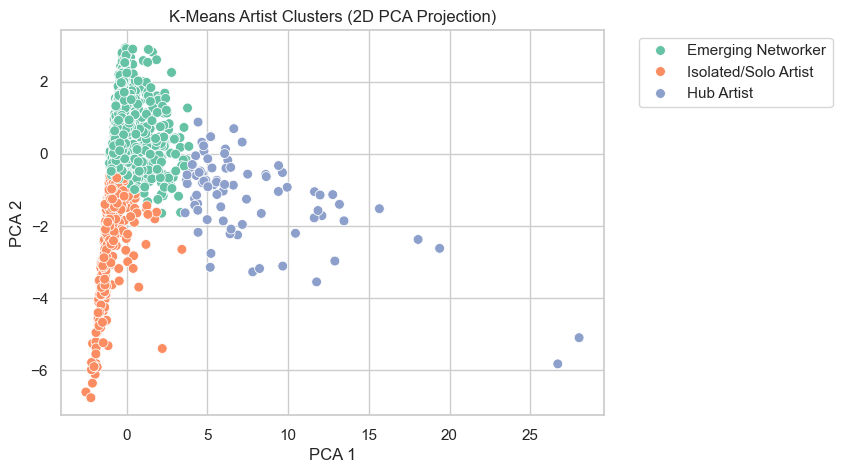

Saved outputs to ./collab_clustering_outputs


In [7]:
import re
import unicodedata
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer

# plotting style
sns.set(style='whitegrid', context='notebook', rc={"figure.figsize": (10,6)})

# config
RANDOM_STATE = 42
APPROX_BETWEENNESS = False  # set True if graph is very large (approximate betweenness)
BETWEENNESS_K = 100         # if approximate, number of samples to use

DATA_DIR = r"Spotify_Dataset_V3.csv"   # change to where you unzipped the dataset
df = pd.read_csv(DATA_DIR, delimiter= ';', low_memory=False)

# 2. Normalize artist names and canonicalize 

# Defensive check
required_cols = ['Date', 'Artists', 'Artist (Ind.)', 'id', 'Nationality', 'Points (Ind for each Artist/Nat)']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns from df: {missing}")

# Normalization helper
def normalize_artist_name(name: str) -> str:
    if pd.isna(name): 
        return ""
    # unicode normalize
    name = unicodedata.normalize("NFKD", str(name))
    # lower, strip
    name = name.lower().strip()
    # remove content inside parentheses (e.g., feat. info)
    name = re.sub(r"\(.*?\)", "", name)
    # replace common separators like &, feat., ft., x with comma to help splitting later
    # but here we only normalize the single artist name cell. Remove punctuation:
    name = re.sub(r"[^\w\s]", "", name)
    # collapse multiple spaces
    name = re.sub(r"\s+", " ", name)
    return name

# Create normalized column for Artist (Ind.)
df = df.copy()
df['artist_raw'] = df['Artist (Ind.)'].astype(str)
df['artist_norm'] = df['artist_raw'].apply(normalize_artist_name)

# Build canonical mapping: choose the most common raw spellings for each normalized name
canon_map = {}
for norm, group in df.groupby('artist_norm'):
    # choose the most frequent raw string as canonical display name
    raw_counts = group['artist_raw'].value_counts()
    canon = raw_counts.index[0]
    canon_map[norm] = canon

# Apply canonical name
df['artist_canon'] = df['artist_norm'].map(canon_map)

# Quick check: number of unique normalized vs unique raw
print("Unique raw artist entries:", df['artist_raw'].nunique())
print("Unique normalized artists:", df['artist_norm'].nunique())
print("Unique canonical artists:", df['artist_canon'].nunique())

# Optional: show examples of normalization
sample_map = list(canon_map.items())[:10]
print("\nSample normalization (norm -> canonical):")
for norm, canon in sample_map:
    print(f"'{norm}' -> '{canon}'")

# 3. Train/Val/Test split
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

print(f"Rows total: {len(df)}")
# First create mapping song_id -> canonical artist list
song_to_artists = df.groupby('id')['artist_canon'].agg(lambda s: list(pd.Series(s).unique())).to_dict()

G = nx.Graph()
# add all canonical artists in train as nodes
all_train_artists = sorted(df['artist_canon'].unique())
G.add_nodes_from(all_train_artists)

# add edges per song
for song_id, artists in song_to_artists.items():
    # only consider songs with 2+ distinct artists for collaborations
    artists = list(set([a for a in artists if a and str(a).strip() != ""]))
    if len(artists) <= 1:
        continue
    # create edges between each pair
    for i in range(len(artists)):
        for j in range(i+1, len(artists)):
            a, b = artists[i], artists[j]
            if G.has_edge(a,b):
                G[a][b]['weight'] += 1
                G[a][b]['songs'].append(song_id)
            else:
                G.add_edge(a,b, weight=1, songs=[song_id])

print(f"Graph built on train set: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")
# Basic graph stats
components = nx.number_connected_components(G)
print(f"Connected components: {components}")
deg_sequence = [d for n, d in G.degree()]
print(f"Degree: min={np.min(deg_sequence)}, max={np.max(deg_sequence)}, mean={np.mean(deg_sequence):.2f}")

# 5. Centrality calculations
# Degree (unweighted)
degree_dict = dict(G.degree())
# Weighted degree
degree_weighted = {n: sum(d.get('weight', 1) for _, _, d in G.edges(n, data=True)) for n in G.nodes()}

# Betweenness (exact or approximate)
if APPROX_BETWEENNESS:
    print("Computing approximate betweenness centrality...")
    betw = nx.betweenness_centrality(G, k=min(BETWEENNESS_K, max(1, int(len(G.nodes())*0.01))),
                                     seed=RANDOM_STATE, normalized=True, weight=None)
else:
    print("Computing exact betweenness centrality (may take a while for large graphs)...")
    betw = nx.betweenness_centrality(G, normalized=True, weight=None)

# Eigenvector centrality (safe-guard: if Graph is disconnected, use largest component)
try:
    if nx.is_connected(G):
        eig = nx.eigenvector_centrality(G, max_iter=500)
    else:
        # compute on largest connected component, set others to 0
        largest_cc = max(nx.connected_components(G), key=len)
        subG = G.subgraph(largest_cc)
        eig_sub = nx.eigenvector_centrality(subG, max_iter=500)
        eig = {n: (eig_sub[n] if n in eig_sub else 0.0) for n in G.nodes()}
except Exception as e:
    print("Eigenvector centrality failed:", e)
    eig = {n: 0.0 for n in G.nodes()}

# Build centrality DataFrame
centrality_df = pd.DataFrame({
    'artist': list(G.nodes()),
    'degree': [degree_dict.get(n, 0) for n in G.nodes()],
    'degree_weighted': [degree_weighted.get(n, 0) for n in G.nodes()],
    'betweenness': [betw.get(n, 0.0) for n in G.nodes()],
    'eigenvector': [eig.get(n, 0.0) for n in G.nodes()]
})
centrality_df = centrality_df.sort_values(by='degree_weighted', ascending=False)


# Plot degree distribution
plt.figure(figsize=(10,5))
sns.histplot(centrality_df['degree'], bins=50)
plt.title('Degree distribution (count, y)')
plt.xlabel('Degree (number of collaborators)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Also plot degree vs weighted degree scatter
plt.figure(figsize=(8,6))
sns.scatterplot(data=centrality_df, x='degree', y='degree_weighted')
plt.title('Degree vs Weighted Degree')
plt.xlabel('Degree (count)')
plt.ylabel('Weighted degree (sum of collab counts)')
plt.tight_layout()
plt.show()

# Display top 20 by degree_weighted
display(centrality_df.head(20))

# 6. Assemble per-artist features (train)
audio_cols = ['Danceability','Energy','Loudness','Speechiness','Acousticness','Instrumentalness','Valence']
# Ensure columns exist - if naming differs, adjust accordingly
for col in audio_cols:
    if col not in df.columns:
        raise ValueError(f"Expected audio column '{col}' in df")

# Compute artist-level audio means and counts using canonical artist names
artist_audio = df.groupby('artist_canon')[audio_cols].mean()
artist_counts = df.groupby('artist_canon').size().rename('n_tracks')
artist_avg_points = df.groupby('artist_canon')['Points (Ind for each Artist/Nat)'].mean().rename('avg_points')

# Merge with centrality features
artist_net = centrality_df.set_index('artist')
artist_features = artist_audio.join([artist_counts, artist_avg_points, artist_net], how='left')

# Fill missing network entries (artists that have no collabs in train will have zeros)
artist_features['degree'] = artist_features['degree'].fillna(0)
artist_features['degree_weighted'] = artist_features['degree_weighted'].fillna(0)
artist_features['betweenness'] = artist_features['betweenness'].fillna(0)
artist_features['eigenvector'] = artist_features['eigenvector'].fillna(0)
artist_features['n_tracks'] = artist_features['n_tracks'].fillna(0)
artist_features['avg_points'] = artist_features['avg_points'].fillna(np.nan)

print("Artist feature matrix shape (train artists):", artist_features.shape)
artist_features.head()

# 7. Impute & scale
numeric_cols = artist_features.columns.tolist()
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(artist_features), index=artist_features.index, columns=numeric_cols)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), index=X_train_imputed.index, columns=numeric_cols)

print("Scaled training feature matrix shape:", X_train_scaled.shape)
X_train_scaled.head()

# 8. Try several K and visualize elbow + silhouette
ks = list(range(3,8))
inertias = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels = km.fit_predict(X_train_scaled)
    inertias.append(km.inertia_)
    # silhouette requires >1 cluster, and not all labels identical
    try:
        sil = silhouette_score(X_train_scaled, labels)
    except Exception:
        sil = np.nan
    sil_scores.append(sil)
    print(f"K={k}: inertia={km.inertia_:.1f}, silhouette={sil:.4f}")

# Plot inertia (elbow) and silhouette
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(ks, inertias, '-o')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia (within-cluster sum of squares)', color='C0')
ax2 = ax1.twinx()
ax2.plot(ks, sil_scores, '-o', color='C1')
ax2.set_ylabel('Silhouette score', color='C1')
plt.title('Elbow (inertia) and silhouette across k')
plt.show()

# Choose k: prefer a k with high silhouette and reasonable inertia elbow.
# As a default, pick the k with the highest silhouette (tie-break by inertia).
best_k = ks[int(np.nanargmax(sil_scores))]
print("Selected best_k (by silhouette):", best_k)

# Fit final KMeans model
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=20)
train_labels = kmeans.fit_predict(X_train_scaled)
artist_features['cluster'] = train_labels

# Cluster sizes
print("Cluster sizes (train):")
print(pd.Series(train_labels).value_counts().sort_index())

# 9. Evaluation on training set
sil_score_train = silhouette_score(X_train_scaled, train_labels)
db_score_train = davies_bouldin_score(X_train_scaled, train_labels)
print(f"Training silhouette score: {sil_score_train:.4f}")
print(f"Training Davies–Bouldin index: {db_score_train:.4f}")

# Add cluster-level summaries (centroids in original feature space)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=numeric_cols)
centroids.index.name = 'cluster'
display(centroids)

# 10. PCA 2D plot
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca_coords = pca.fit_transform(X_train_scaled)

pca_df = pd.DataFrame(pca_coords, index=X_train_scaled.index, columns=['PC1','PC2'])
pca_df['cluster'] = train_labels

plt.figure(figsize=(10,7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=40, alpha=0.8)
plt.title('PCA visualization of artist features (train) colored by KMeans cluster')
plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 11. Centrality ranking per cluster
artist_features_reset = artist_features.reset_index().rename(columns={'index':'artist'})
for c in sorted(artist_features_reset['cluster'].unique()):
    sub = artist_features_reset[artist_features_reset['cluster']==c]
    print(f"\nCluster {c} - size {len(sub)}")
    top_deg = sub.sort_values('degree_weighted', ascending=False).head(8)[['artist_canon','degree','degree_weighted','betweenness','n_tracks']]
    print(" Top by weighted-degree:")
    display(top_deg)
    top_bet = sub.sort_values('betweenness', ascending=False).head(8)[['artist_canon','degree','degree_weighted','betweenness','n_tracks']]
    print(" Top by betweenness:")
    display(top_bet)

# Compute cluster means
features = ['n_tracks', 'degree', 'degree_weighted', 'betweenness', 'eigenvector', 'avg_points']
cluster_summary = artist_features_reset.groupby('cluster')[features].mean().reset_index()

# Heuristic labeling function
def interpret_cluster(row):
    if row['degree'] > 10:
        return "Hub Artist"
    elif row['degree'] <= 2:
        return "Isolated/Solo Artist"
    elif row['betweenness'] > 0.02 and row['degree_weighted'] > 3:
        return "Bridge Artist"
    elif row['degree_weighted'] <= 2 and row['degree'] > 3:
        return "Niche Collaborator"
    else:
        return "Emerging Networker"

cluster_summary['Cluster Label'] = cluster_summary.apply(interpret_cluster, axis=1)


# Merge labels back to artist_df
label_map = cluster_summary.set_index('cluster')['Cluster Label'].to_dict()
artist_features_reset['cluster_label'] = artist_features_reset['cluster'].map(label_map)

display(cluster_summary)

from sklearn.decomposition import PCA
artist_df = artist_features_reset.copy()
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_train_scaled)
artist_df['pca1'] = reduced[:, 0]
artist_df['pca2'] = reduced[:, 1]

plt.figure(figsize=(7, 5))
sns.scatterplot(data=artist_df, x='pca1', y='pca2', hue='cluster_label', palette='Set2', s=50)
plt.title("K-Means Artist Clusters (2D PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 14. Save outputs for later use
out_dir = "./collab_clustering_outputs"
import os, joblib
os.makedirs(out_dir, exist_ok=True)

# Save dataframes
artist_df.reset_index().rename(columns={'index':'artist'}).to_csv(os.path.join(out_dir, 'artist_features_train_with_clusters.csv'), index=False)

# Save models / preprocessors
joblib.dump(imputer, os.path.join(out_dir, 'imputer.joblib'))
joblib.dump(scaler, os.path.join(out_dir, 'scaler.joblib'))
joblib.dump(kmeans, os.path.join(out_dir, f'kmeans_k{best_k}.joblib'))

print("Saved outputs to", out_dir)



## Cluster 5 : Geographic

Loaded rows: 651936
Songs after grouping: 9161


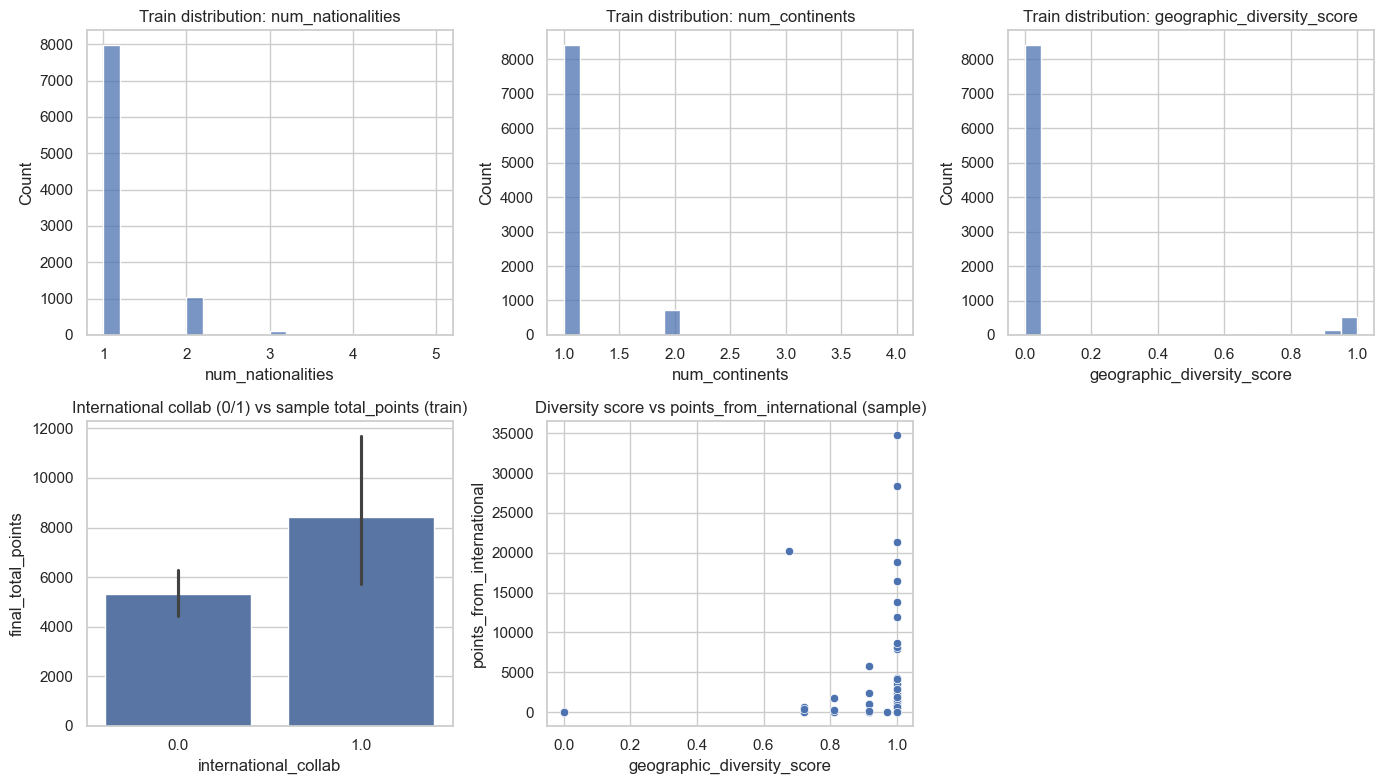

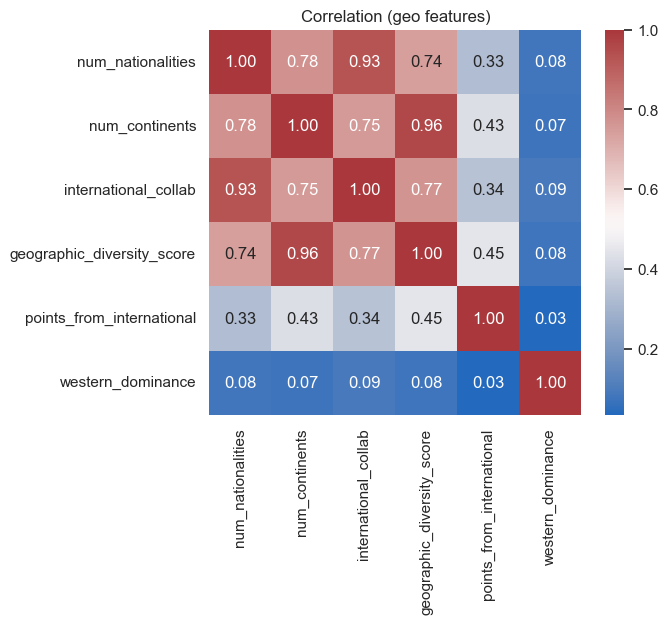

k=4: silhouette=0.9406, davies_bouldin=0.5311, inertia=10138.95
k=5: silhouette=0.9512, davies_bouldin=0.4510, inertia=4964.94
Chosen K: 5
Columns list (first 50):
['song_id', 'title', 'date', 'artist_list', 'num_artists', 'nationality_list', 'num_nationalities', 'continent_list', 'num_continents', 'canonical_continent', 'total_points', 'continent_points', 'international_collab', 'geographic_diversity_score', 'points_from_international', 'western_dominance', 'final_total_points', 'year', 'cluster']

Column dtypes:
song_id                               object
title                                 object
date                          datetime64[ns]
artist_list                           object
num_artists                            int64
nationality_list                      object
num_nationalities                      int64
continent_list                        object
num_continents                         int64
canonical_continent                   object
total_points                  

,song_id,title,date,artist_list,num_artists,nationality_list,num_nationalities,continent_list,num_continents,canonical_continent,total_points,continent_points,international_collab,geographic_diversity_score,points_from_international,western_dominance,final_total_points,year,cluster
0,000xQL6tZNLJzIrtIgxqSl,Still Got Time (feat. PARTYNEXTDOOR),2017-03-24,[ZAYN],1,[United Kingdom],1,[Europe],1,Europe,161.0,{'Europe': 11741.0},0.0,0.0,0.0,1.0,11741.0,2017,3
1,003VDDA7J3Xb2ZFlNx7nIZ,YELL OH,2020-02-07,"[Trippie Redd, Young Thug]",2,[United States],1,[Anglo-America],1,Anglo-America,93.0,{'Anglo-America': 124.0},0.0,0.0,0.0,0.0,124.0,2020,0
2,003eoIwxETJujVWmNFMoZy,Growing Pains,2018-06-15,[Alessia Cara],1,[Canada],1,[Anglo-America],1,Anglo-America,110.0,{'Anglo-America': 903.0},0.0,0.0,0.0,0.0,903.0,2018,0
3,003vvx7Niy0yvhvHt4a68B,Mr. Brightside,2020-08-15,[The Killers],1,[United States],1,[Anglo-America],1,Anglo-America,128.0,{'Anglo-America': 18441.0},0.0,0.0,0.0,0.0,18441.0,2020,0
4,00B7TZ0Xawar6NZ00JFomN,Best Life (feat. Chance The Rapper),2018-04-06,[Cardi B],1,[United States],1,[Anglo-America],1,Anglo-America,140.0,{'Anglo-America': 1284.0},0.0,0.0,0.0,0.0,1284.0,2018,0


Column 'num_continents' exists — sample type: <class 'numpy.int64'> — value repr: 1
Column 'num_nationalities' exists — sample type: <class 'numpy.int64'> — value repr: 1
Column 'geographic_diversity_score' exists — sample type: <class 'numpy.float64'> — value repr: 0.0
Column 'international_collab' exists — sample type: <class 'numpy.float64'> — value repr: 0.0
Column 'points_from_international' exists — sample type: <class 'numpy.float64'> — value repr: 0.0
Column 'western_dominance' exists — sample type: <class 'numpy.float64'> — value repr: 1.0
Column 'total_points' exists — sample type: <class 'numpy.float64'> — value repr: 161.0
Column 'song_id' exists — sample type: <class 'str'> — value repr: '000xQL6tZNLJzIrtIgxqSl'
Column 'cluster' exists — sample type: <class 'numpy.int32'> — value repr: 3
Normalized columns — first 50:
['song_id', 'title', 'date', 'artist_list', 'num_artists', 'nationality_list', 'num_nationalities', 'continent_list', 'num_continents', 'canonical_continent'

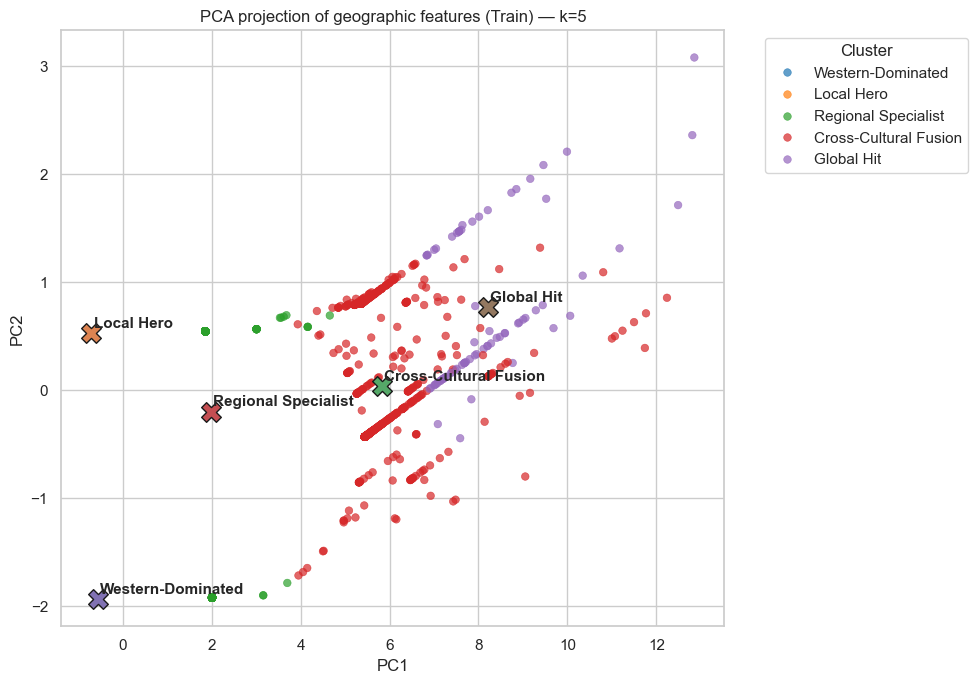

Train: Silhouette = 0.9512, Davies-Bouldin = 0.4510

Cluster 0 — Local Hero (n=6268)


,song_id,title,date,artist_list,canonical_continent,num_nationalities,num_continents,geographic_diversity_score,points_from_international,cluster_label
1,003VDDA7J3Xb2ZFlNx7nIZ,YELL OH,2020-02-07,"[Trippie Redd, Young Thug]",Anglo-America,1,1,0.0,0.0,Local Hero
2,003eoIwxETJujVWmNFMoZy,Growing Pains,2018-06-15,[Alessia Cara],Anglo-America,1,1,0.0,0.0,Local Hero
3,003vvx7Niy0yvhvHt4a68B,Mr. Brightside,2020-08-15,[The Killers],Anglo-America,1,1,0.0,0.0,Local Hero
4,00B7TZ0Xawar6NZ00JFomN,Best Life (feat. Chance The Rapper),2018-04-06,[Cardi B],Anglo-America,1,1,0.0,0.0,Local Hero
8,00Ga884hbpVvCNyeQdle1U,Violet Chemistry,2023-03-10,[Miley Cyrus],Anglo-America,1,1,0.0,0.0,Local Hero
9,00I41xsW6SunZDJ5fB8KAd,Safety Zone,2022-07-15,[j-hope],Asia,1,1,0.0,0.0,Local Hero



Cluster 1 — Cross-Cultural Fusion (n=668)


,song_id,title,date,artist_list,canonical_continent,num_nationalities,num_continents,geographic_diversity_score,points_from_international,cluster_label
7,00ETaeHUQ6lops3oWU1Wrt,Hot Stuff,2020-09-18,"[Kygo, Donna Summer]",Europe,2,2,1.000000,70.0,Cross-Cultural Fusion
48,02LZ1fGJE8fB56yTlCVMEV,Switch,2017-05-19,"[Iggy Azalea, Anitta]",Oceania,2,2,1.000000,127.0,Cross-Cultural Fusion
53,02dRkCEc8Q5ch4TTcnLxOn,Nothing Breaks Like a Heart (feat. Miley Cyrus),2023-01-16,"[Mark Ronson, Miley Cyrus]",Europe,2,2,1.000000,32.0,Cross-Cultural Fusion
56,02kDW379Yfd5PzW5A6vuGt,Lemonade,2020-08-14,"[Internet Money, Gunna, Don Toliver, NAV]",Anglo-America,3,2,0.811278,506.0,Cross-Cultural Fusion
75,03iCbZaM4OkRR4We6wIzvx,IDOL,2018-08-24,"[BTS, Nicki Minaj]",Asia,2,2,1.000000,951.0,Cross-Cultural Fusion
84,042x9bsUBWW2fJgJ6fUh61,Not Going Home (feat. Gia Koka),2017-01-02,"[DVBBS, CMC$]",Anglo-America,2,2,1.000000,2125.0,Cross-Cultural Fusion



Cluster 2 — Regional Specialist (n=439)


,song_id,title,date,artist_list,canonical_continent,num_nationalities,num_continents,geographic_diversity_score,points_from_international,cluster_label
5,00Blm7zeNqgYLPtW6zg8cj,One Right Now (with The Weeknd),2021-11-05,"[Post Malone, The Weeknd]",Anglo-America,2,1,0.0,0.0,Regional Specialist
6,00EPIEnX1JFjff8sC6bccd,No Me Acuerdo,2018-07-17,"[Thalia, Natti Natasha]",Latin-America,2,1,0.0,0.0,Regional Specialist
54,02itaCXOdC54J0ISjqqFAp,All Around The World (La La La),2019-06-07,"[R3HAB, A Touch Of Class]",Europe,2,1,0.0,0.0,Regional Specialist
66,03LfOYi0icz4souspZVVhq,"Nicky Jam: Bzrp Music Sessions, Vol. 41",2021-07-01,"[Bizarrap, Nicky Jam]",Latin-America,2,1,0.0,0.0,Regional Specialist
67,03NqHNdG3Ur6kciQWK6e8V,Oh,2021-10-29,"[Myke Towers, Camila Cabello, Tainy]",Latin-America,2,1,0.0,0.0,Regional Specialist
103,059bcIhyc2SBwm6sw2AZzd,Te Vi,2019-01-11,"[Piso 21, Micro TDH]",Latin-America,2,1,0.0,0.0,Regional Specialist



Cluster 3 — Western-Dominated (n=1712)


,song_id,title,date,artist_list,canonical_continent,num_nationalities,num_continents,geographic_diversity_score,points_from_international,cluster_label
0,000xQL6tZNLJzIrtIgxqSl,Still Got Time (feat. PARTYNEXTDOOR),2017-03-24,[ZAYN],Europe,1,1,0.0,0.0,Western-Dominated
15,00lNx0OcTJrS3MKHcB80HY,You Don't Know Me - Radio Edit,2017-01-09,"[Jax Jones, RAYE]",Europe,1,1,0.0,0.0,Western-Dominated
20,017PF4Q3l4DBUiWoXk4OWT,Break My Heart,2020-03-27,[Dua Lipa],Europe,1,1,0.0,0.0,Western-Dominated
21,01BCvCKQNDmFQQQSjrzPnm,GHIGLIOTTI - feat. Noyz rcos,2021-10-01,[Salmo],Europe,1,1,0.0,0.0,Western-Dominated
24,01I9AEz658sQnQzCL3K3QG,HOES UP G'S DOWN,2020-05-29,[Shirin David],Europe,1,1,0.0,0.0,Western-Dominated
34,01hEpx8jnOG4q7nDK14Rhi,malibu,2021-05-14,[sangiovanni],Europe,1,1,0.0,0.0,Western-Dominated



Cluster 4 — Global Hit (n=74)


,song_id,title,date,artist_list,canonical_continent,num_nationalities,num_continents,geographic_diversity_score,points_from_international,cluster_label
90,04DwTuZ2VBdJCCC5TROn7L,In the name of Love,2017-01-01,"[Martin Garrix, Bebe Rexha]",Europe,2,2,1.000000,12019.0,Global Hit
169,08bNPGLD8AhKpnnERrAc6G,FRIENDS,2018-02-09,"[Marshmello, Anne-Marie]",Anglo-America,2,2,1.000000,27041.0,Global Hit
183,09IStsImFySgyp0pIQdqAc,The Middle,2018-01-26,"[Zedd, Maren Morris, Grey]",Anglo-America,2,2,0.918296,19921.0,Global Hit
296,0EhpEsp4L0oRGM0vmeaN5e,UN DIA (ONE DAY) (Feat. Tainy),2020-07-24,"[J Balvin, Dua Lipa, Bad Bunny]",Latin-America,3,2,0.918296,13712.0,Global Hit
438,0NiXXAI876aGImAd6rTj8w,Mama,2017-06-05,"[Jos Blue, William Singe]",Anglo-America,2,2,1.000000,16091.0,Global Hit
630,0WtM2NBVQNNJLh6scP13H8,Calm Down (with Selena Gomez),2022-08-26,"[Rema, Selena Gomez]",Africa,2,2,1.000000,21283.0,Global Hit


Saved outputs to ./geo_clustering_outputs


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import joblib
from datetime import datetime

from scipy.stats import entropy

sns.set(style="whitegrid")

DATA_DIR = r"Spotify_Dataset_V3.csv"   # change to where you unzipped the dataset
df = pd.read_csv(DATA_DIR, delimiter= ';', low_memory=False)
# Helper to find columns by common names
cols_lower = {c.lower(): c for c in df.columns}
def find_col(possible_names):
    for n in possible_names:
        if n.lower() in cols_lower:
            return cols_lower[n.lower()]
    return None

# Candidate columns (adjust if your CSV uses different names)
COL_DATE = find_col(["date", "Date"])
COL_ID = find_col(["id", "track id", "track_id", "song id"])  # optional
COL_TITLE = find_col(["title", "Title", "song", "Song"])
COL_ARTISTS = find_col(["artists", "Artists"])  # might be comma-separated list
COL_ARTIST_INDIV = find_col(["artist (ind.)", "artist_name", "artist"])  # per-row individual artist name
COL_NATIONALITY = find_col(["nationality", "Nationality"])
COL_CONTINENT = find_col(["continent", "Continent"])
COL_POINTS_TOTAL = find_col(["points (total)", "points", "Points (Total)"])
COL_POINTS_IND = find_col(["points (ind for each artist/nat)", "points_ind", "Points (Ind for each Artist/Nat)"])

# Validate required columns
required = {"date": COL_DATE, "nationality": COL_NATIONALITY, "continent": COL_CONTINENT}
missing = [k for k,v in required.items() if v is None]
if missing:
    raise ValueError(f"Missing expected columns in CSV. Could not find: {missing}. Available cols: {list(df.columns)}")

# Parse dates
df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors='coerce')
df = df.dropna(subset=[COL_DATE])  # drop rows with bad dates
print("Loaded rows:", len(df))
df.head(3)
# Cell: Create / normalize song id if missing
if COL_ID is None:
    if COL_TITLE is None:
        raise ValueError("No title column found to create song id.")
    df["_song_id"] = df[COL_TITLE].astype(str) + "__" + df[COL_DATE].dt.strftime("%Y-%m-%d")
    COL_ID = "_song_id"

# Normalize continent strings: small mapping for common variants
continent_map = {
    "latin-america": "Latin-America", "latin america": "Latin-America", "south-america": "Latin-America",
    "north-america": "North-America", "north america": "North-America", "usa": "North-America", "united states": "North-America",
    "united-kingdom":"Europe", "uk":"Europe",
    # add more mappings as needed
}

def normalize_cont(c):
    if pd.isna(c): return None
    s = str(c).strip()
    key = s.lower()
    return continent_map.get(key, s)

# Aggregation function for grouping rows by song id
def aggregate_song_rows(g):
    # Artists: prefer 'Artists' comma-separated; fallback to individual artist column values across rows
    artist_list = []
    if COL_ARTISTS and g[COL_ARTISTS].notna().any():
        for v in g[COL_ARTISTS].dropna().astype(str).unique():
            parts = [p.strip() for p in v.split(",") if p.strip()]
            artist_list.extend(parts)
    if not artist_list and COL_ARTIST_INDIV:
        artist_list = [a for a in g[COL_ARTIST_INDIV].dropna().astype(str).unique()]

    artist_list = list(dict.fromkeys([a for a in artist_list if a and a.lower() not in ("nan","none")]))  # dedupe

    # nationalities & continents
    nat_list = [str(x).strip() for x in g[COL_NATIONALITY].dropna().astype(str).tolist()]
    cont_list_raw = [str(x).strip() for x in g[COL_CONTINENT].dropna().astype(str).tolist()]
    cont_list = [normalize_cont(c) for c in cont_list_raw if c]
    unique_nats = list(dict.fromkeys(nat_list))
    unique_conts = list(dict.fromkeys([c for c in cont_list if c]))

    # total points
    total_points = None
    if COL_POINTS_TOTAL and g[COL_POINTS_TOTAL].notna().any():
        try:
            total_points = float(g[COL_POINTS_TOTAL].dropna().astype(float).max())
        except:
            total_points = None
    if total_points is None and COL_POINTS_IND and g[COL_POINTS_IND].notna().any():
        try:
            total_points = float(g[COL_POINTS_IND].dropna().astype(float).sum())
        except:
            total_points = None

    # continent-level points (if per-artist points exist)
    cont_points = {}
    if COL_POINTS_IND and COL_CONTINENT and g[COL_POINTS_IND].notna().any():
        for _, row in g.dropna(subset=[COL_POINTS_IND]).iterrows():
            cont_raw = row[COL_CONTINENT]
            cont = normalize_cont(cont_raw) if not pd.isna(cont_raw) else "Unknown"
            try:
                pts = float(row[COL_POINTS_IND])
            except:
                pts = 0.0
            cont_points[cont] = cont_points.get(cont, 0.0) + pts

    # canonical continent: if only one continent -> that, else 'Multi' or continent with most points
    canonical_continent = None
    if len(unique_conts) == 1:
        canonical_continent = unique_conts[0]
    elif cont_points:
        canonical_continent = max(cont_points.items(), key=lambda x: x[1])[0]
    elif unique_conts:
        canonical_continent = unique_conts[0]
    else:
        canonical_continent = "Unknown"

    return pd.Series({
        "song_id": g[COL_ID].iloc[0],
        "title": g[COL_TITLE].iloc[0] if COL_TITLE else None,
        "date": g[COL_DATE].min(),
        "artist_list": artist_list,
        "num_artists": len(artist_list) if artist_list else max(1, g.shape[0]),
        "nationality_list": unique_nats,
        "num_nationalities": len(unique_nats),
        "continent_list": unique_conts,
        "num_continents": len(unique_conts),
        "canonical_continent": canonical_continent,
        "total_points": total_points if total_points is not None else np.nan,
        "continent_points": cont_points
    })

grouped = df.groupby(COL_ID).apply(aggregate_song_rows).reset_index(drop=True)
print("Songs after grouping:", len(grouped))
grouped.head(3).T

# Cell: compute geographic features
def compute_geo_features(row):
    num_nationalities = int(row["num_nationalities"]) if not pd.isna(row["num_nationalities"]) else 0
    num_continents = int(row["num_continents"]) if not pd.isna(row["num_continents"]) else 0
    num_artists = int(row["num_artists"]) if not pd.isna(row["num_artists"]) else max(1, len(row["artist_list"]) if row["artist_list"] else 1)

    international_collab = int((num_nationalities > 1) or (num_continents > 1))

    # geographic_diversity_score: use entropy over continent_points if available, else over counts
    cont_points = row["continent_points"] if isinstance(row["continent_points"], dict) else {}
    if cont_points:
        values = np.array([v for v in cont_points.values()], dtype=float)
        if values.sum() > 0:
            probs = values / values.sum()
            ent = entropy(probs)  # natural log base
            # normalize by log(N_continents) if more than 1 continent
            if len(values) > 1:
                max_ent = np.log(len(values))
                geo_div_score = ent / max_ent
            else:
                geo_div_score = 0.0
        else:
            geo_div_score = 0.0
    else:
        # fallback: use counts normalized by artist count
        geo_div_score = (num_continents + (num_nationalities / max(1, num_artists))) / (1 + max(1, num_continents))

    # points_from_international: points from continents other than canonical_continent
    canonical = row["canonical_continent"]
    if cont_points:
        points_from_international = float(sum(v for k,v in cont_points.items() if k != canonical))
        total_points = float(sum(cont_points.values()))
    else:
        points_from_international = 0.0
        total_points = float(row["total_points"]) if not pd.isna(row["total_points"]) else 0.0

    # western_dominance: heuristics - treat "North-America" and "Europe" as western
    western_conts = {"North-America", "Europe", "USA", "United-States", "United States", "United Kingdom", "UK"}
    western_points = sum(v for k,v in cont_points.items() if k in western_conts)
    western_dominance = (western_points / total_points) if total_points > 0 else 0.0

    return pd.Series({
        # "num_nationalities": num_nationalities,
        # "num_continents": num_continents,
        "international_collab": international_collab,
        "geographic_diversity_score": geo_div_score,
        "points_from_international": points_from_international,
        "western_dominance": western_dominance,
        "final_total_points": total_points
    })

geo_feats = grouped.apply(compute_geo_features, axis=1)
songs = pd.concat([grouped, geo_feats], axis=1)
songs.head(3).T

# Cell: split data
songs['year'] = songs['date'].dt.year

# Cell: EDA plots
geo_cols = ["num_nationalities","num_continents","international_collab","geographic_diversity_score","points_from_international","western_dominance"]

plt.figure(figsize=(14,8))
for i, col in enumerate(["num_nationalities","num_continents","geographic_diversity_score"]):
    plt.subplot(2,3,i+1)
    sns.histplot(songs[col].dropna(), kde=False, bins=20)
    plt.title(f"Train distribution: {col}")

plt.subplot(2,3,4)
sns.barplot(x="international_collab", y="final_total_points", data=songs.sample(min(1000, len(songs))))
plt.title("International collab (0/1) vs sample total_points (train)")

plt.subplot(2,3,5)
sns.scatterplot(data=songs.sample(min(1000, len(songs))), x="geographic_diversity_score", y="points_from_international")
plt.title("Diversity score vs points_from_international (sample)")

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,5))
sns.heatmap(songs[geo_cols].corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation (geo features)")
plt.show()

# Cell: prepare features & scaler
feature_cols = ["num_nationalities","num_continents","international_collab","geographic_diversity_score","points_from_international","western_dominance"]
X_train = songs[feature_cols].fillna(0).values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

def run_k_evaluate(X, k):
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels) if len(np.unique(labels))>1 else np.nan
    db = davies_bouldin_score(X, labels) if len(np.unique(labels))>1 else np.nan
    return km, labels, sil, db, km.inertia_

results = {}
for k in [4,5]:
    km, labels, sil, db, inertia = run_k_evaluate(X_train_scaled, k)
    results[k] = {"kmeans": km, "labels": labels, "silhouette": sil, "db": db, "inertia": inertia}
    print(f"k={k}: silhouette={sil:.4f}, davies_bouldin={db:.4f}, inertia={inertia:.2f}")

# Cell: pick K (simple heuristic)
k_pref = 5
# compare silhouette & db
if (results[4]["silhouette"] > results[5]["silhouette"]) and (results[4]["db"] <= results[5]["db"]):
    k_pref = 4
print("Chosen K:", k_pref)

kmeans = KMeans(n_clusters=k_pref, random_state=42, n_init=50)
kmeans.fit(X_train_scaled)
train_labels = kmeans.predict(X_train_scaled)
train_df = songs.reset_index(drop=True)
train_df['cluster'] = train_labels

# # Transform and predict for val/test
# def transform_and_predict(df_subset):
#     X = df_subset[feature_cols].fillna(0).values
#     Xs = scaler.transform(X)
#     labels = kmeans.predict(Xs)
#     df_copy = df_subset.copy()
#     df_copy['cluster'] = labels
#     return df_copy

# val_df = transform_and_predict(val_df)
# test_df = transform_and_predict(test_df)

# Diagnostic 1: show columns and types
print("Columns list (first 50):")
print(train_df.columns.tolist()[:50])
print("\nColumn dtypes:")
print(train_df.dtypes)

# Show if any column name is not a string (e.g., tuple / object)
non_string_cols = [c for c in train_df.columns if not isinstance(c, str)]
print("\nNon-string column names (if any):", non_string_cols)

# Show a tiny sample of rows and exact types per cell for key columns used in agg
sample = train_df.head(5).copy()
print("\nSample head:")
display(sample)

# For each column used in aggregation, show the type of the values in the first row (helps detect dict/list)
cols_to_check = ['num_continents','num_nationalities','geographic_diversity_score','international_collab','points_from_international','western_dominance','total_points','song_id','cluster']
for c in cols_to_check:
    if c in train_df.columns:
        val = train_df[c].iloc[0]
        print(f"Column '{c}' exists — sample type: {type(val)} — value repr: {repr(val)[:200]}")
    else:
        print(f"Column '{c}' is MISSING from train_df")

# Convert any non-string column names to strings (safe normalization)
new_cols = []
for c in train_df.columns:
    if isinstance(c, tuple):
        new_cols.append("_".join(map(str, c)))   # join tuple names
    else:
        new_cols.append(str(c))
train_df.columns = new_cols
print("Normalized columns — first 50:")
print(train_df.columns.tolist()[:50])

train_df

# Cell: cluster summaries
cluster_summary = train_df.groupby('cluster').agg({
    'num_continents':'median',
    'num_nationalities':'median',
    'geographic_diversity_score':'median',
    'international_collab':'mean',
    'points_from_international':'median',
    'western_dominance':'median',
    'total_points':'median',
    'song_id':'count'
}).rename(columns={'song_id':'count'}).reset_index()
cluster_summary

# assign labels heuristically
def assign_cluster_name(row):
    if (row['num_continents'] >= 2 and row['geographic_diversity_score'] > 0.4 and row['points_from_international'] > 10000):
        return "Global Hit"
    if (row['international_collab'] >= 0.5 and row['num_continents'] >= 1 and row['num_continents'] >= 2):
        return "Cross-Cultural Fusion"
    if (row['western_dominance'] >= 0.65 and row['num_continents'] <= 1):
        return "Western-Dominated"
    if (row['num_continents'] <= 1 and row['num_nationalities'] <= 1 and (row['points_from_international'] < (0.05 * max(1,row['total_points'])))):
        return "Local Hero"
    return "Regional Specialist"

cluster_summary['label'] = cluster_summary.apply(assign_cluster_name, axis=1)
cluster_to_label = dict(zip(cluster_summary['cluster'], cluster_summary['label']))


train_df['cluster_label'] = train_df['cluster'].map(cluster_to_label)
print("Train label counts:\n", train_df['cluster_label'].value_counts())

cluster_summary

# Cell: PCA 2D and plotting
pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(X_train_scaled)

# compute centroids in PCA space (transform kmeans.cluster_centers_)
centroids_scaled = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids_scaled)

plt.figure(figsize=(10,7))
palette = sns.color_palette("tab10", n_colors=k_pref)
sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=train_df['cluster_label'], palette=palette, s=30, alpha=0.7, edgecolor=None)
# plot centroids
for i, (cx, cy) in enumerate(centroids_pca):
    label = cluster_to_label.get(i, str(i))
    plt.scatter(cx, cy, marker='X', s=200, edgecolor='k')
    plt.text(cx+0.05, cy+0.05, label, fontsize=11, weight='bold')

plt.title(f"PCA projection of geographic features (Train) — k={k_pref}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', title="Cluster")
plt.tight_layout()
plt.show()

# Cell: compute metrics
def compute_metrics_for_df(df_subset):
    X = df_subset[feature_cols].fillna(0).values
    Xs = scaler.transform(X)
    labels = df_subset['cluster'].values
    sil = silhouette_score(Xs, labels) if len(np.unique(labels))>1 else np.nan
    db = davies_bouldin_score(Xs, labels) if len(np.unique(labels))>1 else np.nan
    return sil, db

train_sil, train_db = compute_metrics_for_df(train_df)
# val_sil, val_db = compute_metrics_for_df(val_df)
# test_sil, test_db = compute_metrics_for_df(test_df)

print("Train: Silhouette = {:.4f}, Davies-Bouldin = {:.4f}".format(train_sil, train_db))
# print("Val:   Silhouette = {:.4f}, Davies-Bouldin = {:.4f}".format(val_sil, val_db))
# print("Test:  Silhouette = {:.4f}, Davies-Bouldin = {:.4f}".format(test_sil, test_db))

# Cell: sample per cluster
display_cols = ['song_id','title','date','artist_list','canonical_continent','num_nationalities','num_continents','geographic_diversity_score','points_from_international','cluster_label']
for cl in sorted(train_df['cluster'].unique()):
    label = cluster_to_label.get(cl, str(cl))
    print(f"\nCluster {cl} — {label} (n={len(train_df[train_df['cluster']==cl])})")
    display(train_df[train_df['cluster']==cl][display_cols].head(6))

# Save outputs for later use
out_dir = "./geo_clustering_outputs"
import os, joblib
os.makedirs(out_dir, exist_ok=True)

# Save dataframes
train_df.to_csv(os.path.join(out_dir, "songs_train_with_clusters.csv"), index=False)
cluster_summary.to_csv(os.path.join(out_dir, "cluster_summary.csv"), index=False)

# Save models / preprocessors
joblib.dump(scaler, os.path.join(out_dir, 'geo_scaler.joblib'))
joblib.dump(kmeans, os.path.join(out_dir, f'geo_kmeans{k_pref}.joblib'))

print("Saved outputs to", out_dir)


## cluster 7 : audio evolution

Original full dataset size: 651936
Unique songs dataset size: 9161

Calculating optimal k...


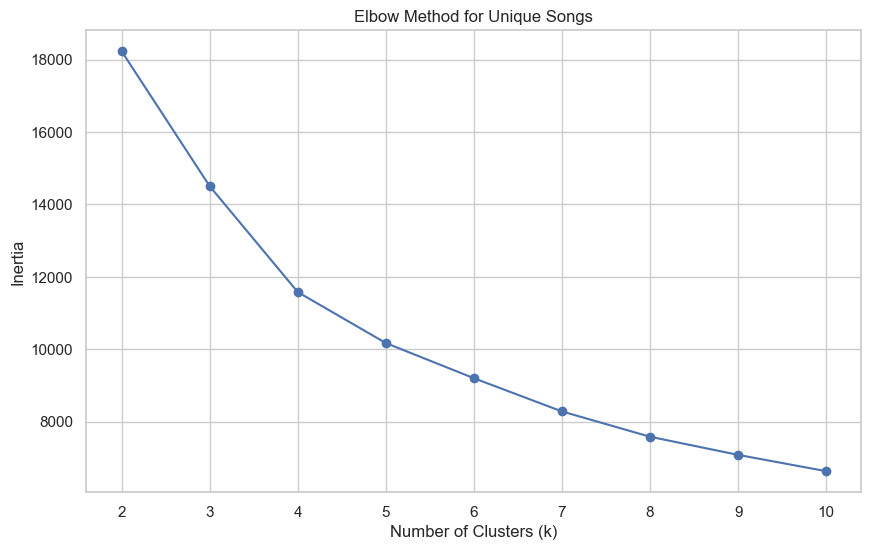

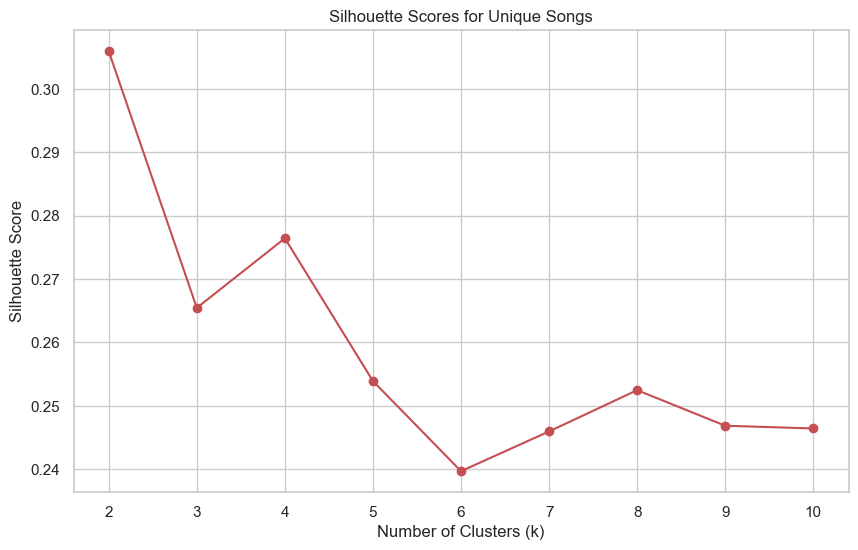


Cluster counts in the original 650k dataset:
cluster
0    137019
1     74433
2    266900
3    173584
Name: count, dtype: int64


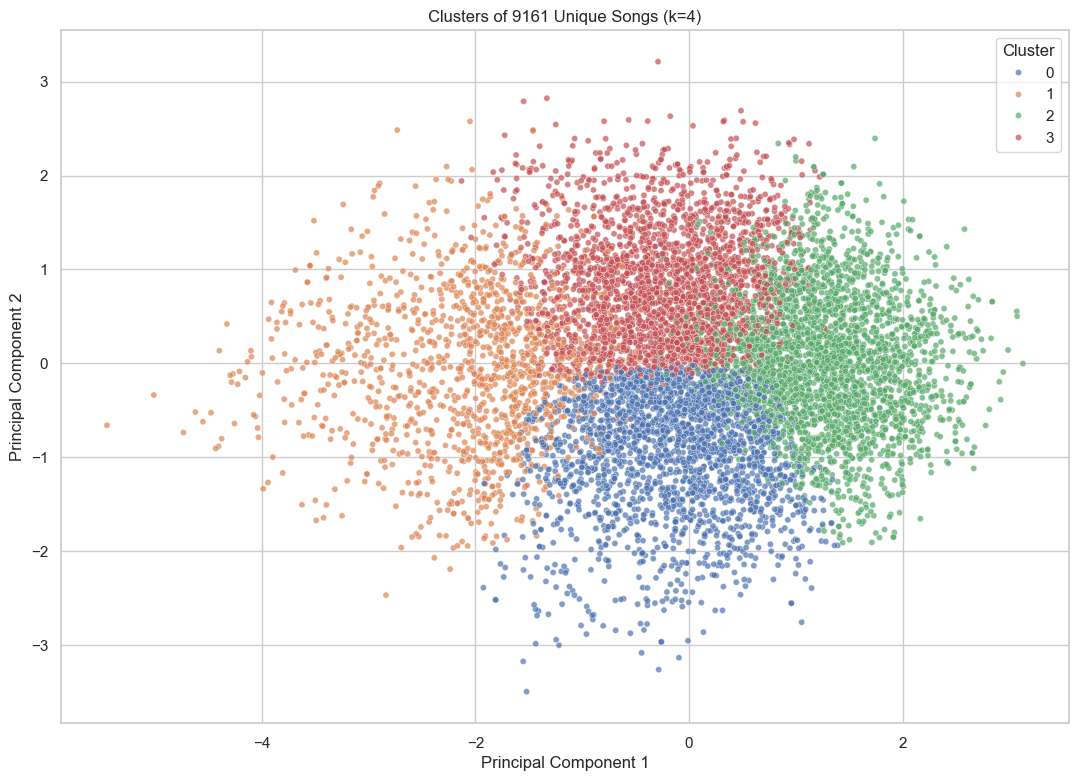

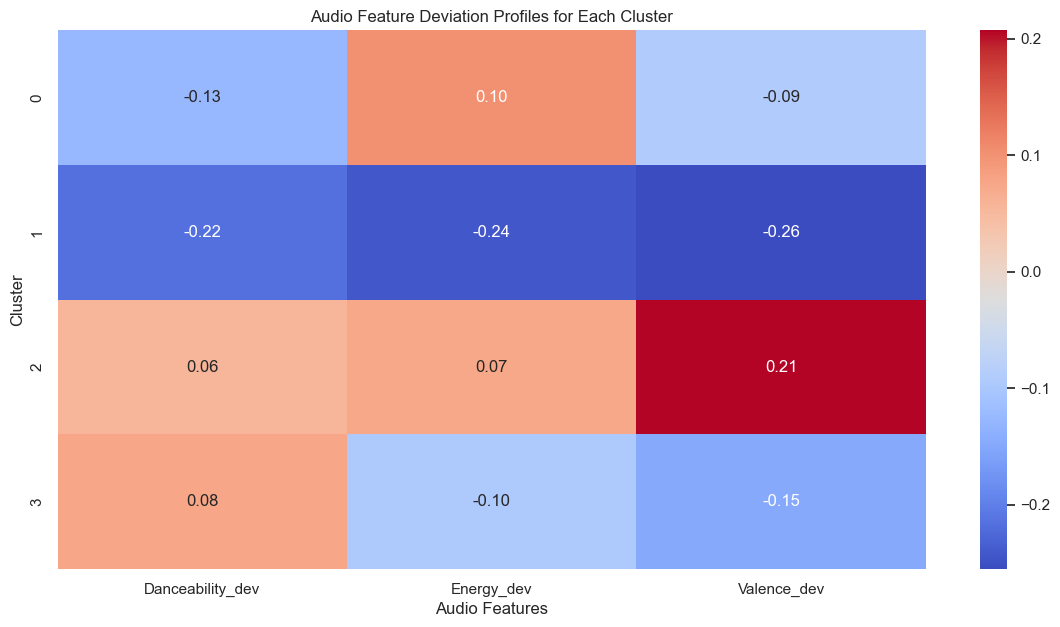

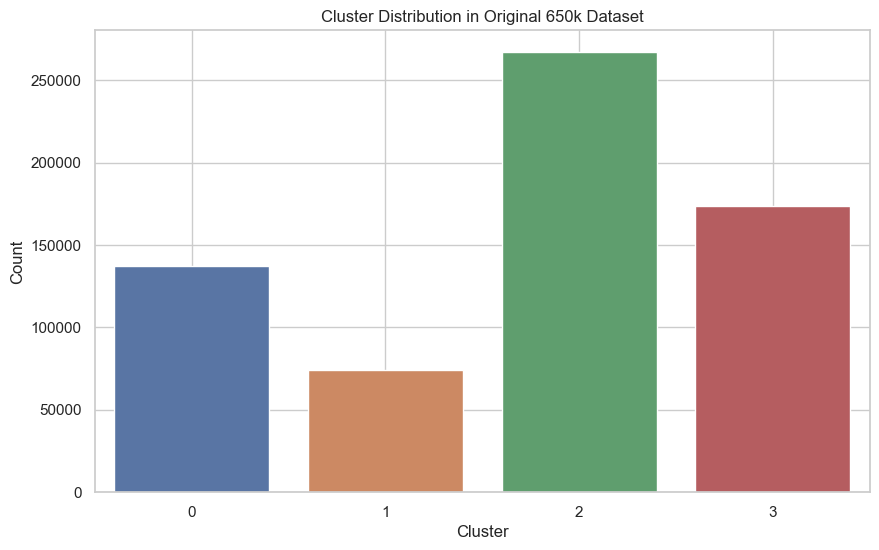

--- Data head with new Cluster Names ---
   cluster evolution_cluster_name
0        2    Mainstream Follower
1        2    Mainstream Follower
2        0           Trend Setter
3        3   Experimental/Outlier
4        3   Experimental/Outlier

--- New Cluster Counts by Name ---
evolution_cluster_name
Mainstream Follower     266900
Experimental/Outlier    173584
Trend Setter            137019
Retro/Throwback          74433
Name: count, dtype: int64


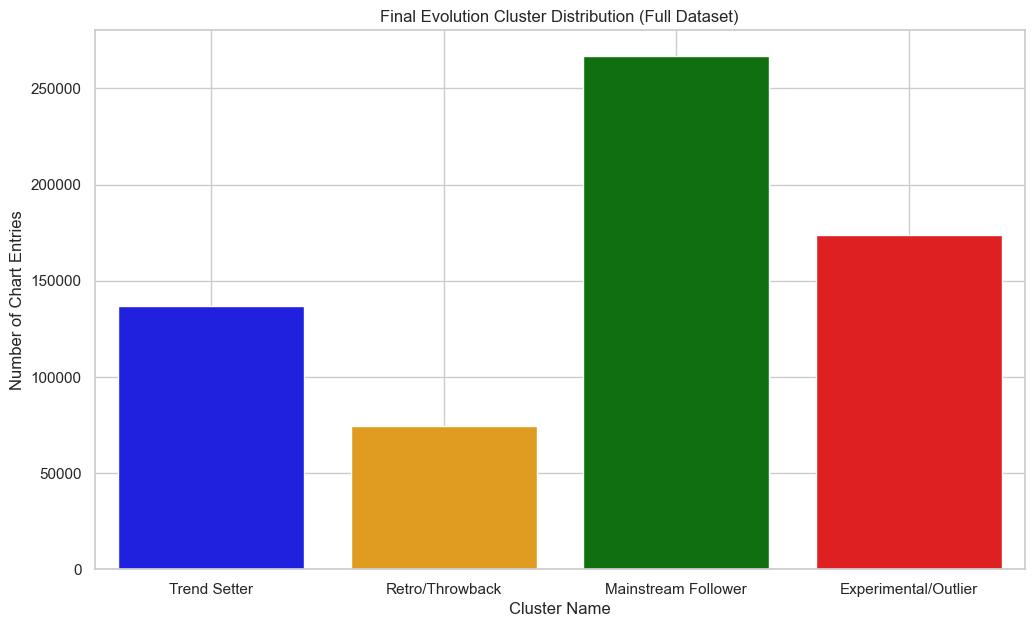

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import os
df = pd.read_csv('Spotify_Dataset_V3.csv', delimiter=';')
df
df['id'].unique().shape
audio_features = ['Danceability', 'Energy', 'Valence', 'Acousticness', 'Instrumentalness', 'Speechiness', 'Loudness']

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
# Set the unique song identifier column
from sklearn.metrics import silhouette_score


SONG_ID_COLS = ['id'] 

audio_features = ['Danceability', 'Energy', 'Valence']

# --- 2. Calculate Deviation Features (on all 650k rows) ---
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
year_avg_features = df.groupby('Year')[audio_features].transform('mean')

df_dev = df[audio_features].sub(year_avg_features)
df_dev.columns = [f'{col}_dev' for col in audio_features]

# Add the dev features and song IDs to one DataFrame
df_full_dev = pd.concat([df[SONG_ID_COLS], df_dev], axis=1)

# --- 3. Create the Unique Song Dataset (Average Deviation) ---
print(f"Original full dataset size: {len(df_full_dev)}")
df_unique_avg_dev = df_full_dev.groupby(SONG_ID_COLS).mean().reset_index()
print(f"Unique songs dataset size: {len(df_unique_avg_dev)}")

# --- 4. Scale the Unique Song Data ---
scaler = StandardScaler()
X_unique_scaled = scaler.fit_transform(df_unique_avg_dev.drop(columns=SONG_ID_COLS))

# --- 5. Find Optimal K (Elbow + Silhouette) ---
k_range = range(2, 11) 
inertia_values = []
silhouette_values = []

print("\nCalculating optimal k...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_unique_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_values.append(silhouette_score(X_unique_scaled, cluster_labels))

# Plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Unique Songs')
plt.grid(True)
plt.savefig("unique_songs_elbow_plot.png")
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_values, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Unique Songs')
plt.grid(True)
plt.savefig("unique_songs_silhouette_plot.png")
plt.show()


k_final = 4 

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
final_labels = kmeans_final.fit_predict(X_unique_scaled)

# Add cluster labels to the unique songs DataFrame
df_unique_avg_dev['cluster'] = final_labels

# --- 7. Merge Clusters Back to Original 650k DataFrame ---
df = pd.merge(
    df, 
    df_unique_avg_dev[SONG_ID_COLS + ['cluster']], 
    on=SONG_ID_COLS, 
    how='left'
)

print("\nCluster counts in the original 650k dataset:")
print(df['cluster'].value_counts().sort_index())

# --- 8. Visualize the Unique Song Clusters ---
pca = PCA(n_components=2)
X_pca_unique = pca.fit_transform(X_unique_scaled)

pca_df_unique = pd.DataFrame(data=X_pca_unique, columns=['PCA 1', 'PCA 2'])
pca_df_unique['Cluster'] = final_labels 

plt.figure(figsize=(13, 9))
sns.scatterplot(
    data=pca_df_unique,
    x='PCA 1',
    y='PCA 2',
    hue='Cluster',
    palette='deep',
    alpha=0.7,
    s=20
)
plt.title(f'Clusters of {len(df_unique_avg_dev)} Unique Songs (k={k_final})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig("unique_songs_cluster_plot.png")
plt.show()
feature_centers = df_unique_avg_dev.groupby('cluster').mean(numeric_only=True)

dev_cols = [col for col in df_unique_avg_dev.columns if '_dev' in col]
cluster_profiles = feature_centers[dev_cols]

plt.figure(figsize=(14, 7))
sns.heatmap(
    cluster_profiles, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f' 
)
plt.title('Audio Feature Deviation Profiles for Each Cluster')
plt.xlabel('Audio Features')
plt.ylabel('Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df, palette='deep', order=sorted(df['cluster'].unique()))
plt.title('Cluster Distribution in Original 650k Dataset')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.grid(True)
plt.show()
# --- 1. Define the Cluster Name Map ---
# This map is based on the analysis of your heatmap and count plot
evolution_cluster_name_map = {
    0: "Trend Setter",
    1: "Retro/Throwback",
    2: "Mainstream Follower",
    3: "Experimental/Outlier"
}

# --- 2. Apply the names to your DataFrame ---
# This assumes your cluster column is named 'cluster'
df['evolution_cluster_name'] = df['cluster'].map(evolution_cluster_name_map)

# --- 3. (Optional) Check the results ---
print("--- Data head with new Cluster Names ---")
print(df[['cluster', 'evolution_cluster_name']].head())

print("\n--- New Cluster Counts by Name ---")
print(df['evolution_cluster_name'].value_counts())

# --- 4. (Optional) Plot the named counts ---
# Define a color map for the new names
color_map = {
    "Mainstream Follower": "green",
    "Trend Setter": "blue",
    "Experimental/Outlier": "red",
    "Retro/Throwback": "orange"
}

plt.figure(figsize=(12, 7))
sns.countplot(
    x='evolution_cluster_name', 
    data=df, 
    palette=color_map,
    order=evolution_cluster_name_map.values()
)
plt.title('Final Evolution Cluster Distribution (Full Dataset)')
plt.xlabel('Cluster Name')
plt.ylabel('Number of Chart Entries')
plt.grid(True)
plt.show()
df.to_csv("Audio_evolution_clustering.csv", index=False)    

In [ ]:
import pandas as pd
import numpy as np
import re
import unicodedata
import warnings

# Suppress warnings that might come from merging
warnings.simplefilter(action='ignore', category=FutureWarning)

print("--- Starting Final Cluster Merge ---")

# --- Define File Paths ---
# Make sure all these files are in the same directory as this script,
# or provide the full path to them.

ORIGINAL_FILE = 'Spotify_Dataset_V3.csv'

# Files from Cluster 1 & 2 (Sonic, Artist)
SONIC_CLUSTER_FILE = 'song_master_table_with_clusters.csv'
ARTIST_CLUSTER_FILE = 'artist_master_table_with_clusters.csv'

# File from Cluster 3 & 6 (Temporal, Performance)
TEMP_PERF_CLUSTER_FILE = 'spotify_data_with_clusters.csv'

# File from Cluster 4 (Collaboration)
COLLAB_CLUSTER_FILE = 'collab_clustering_outputs/artist_features_train_with_clusters.csv'

# File from Cluster 5 (Geographic)
GEO_CLUSTER_FILE = 'geo_clustering_outputs/songs_train_with_clusters.csv'

# File from Cluster 7 (Audio Evolution)
EVO_CLUSTER_FILE = 'Audio_evolution_clustering.csv'

OUTPUT_FILE = 'Spotify_Dataset_V3_All_Clusters_v2.csv'


try:
    # --- 1. Load Base Data ---
    # The original file uses a semicolon delimiter
    print(f"Loading base file: {ORIGINAL_FILE}...")
    df_base = pd.read_csv(ORIGINAL_FILE, delimiter=';')
    print(f"Base data loaded with {df_base.shape[0]} rows and {df_base.shape[1]} columns.")
    
    # Keep track of original columns to avoid merging duplicates
    original_columns = set(df_base.columns)

    # --- 2. Load and Merge Cluster 1: Sonic (K=7) ---
    print(f"Loading Sonic clusters from: {SONIC_CLUSTER_FILE}...")
    df_sonic = pd.read_csv(SONIC_CLUSTER_FILE, usecols=['id', 'Sonic_Cluster'])
    df_base = pd.merge(df_base, df_sonic, on='id', how='left')

    # --- 3. Load and Merge Cluster 2: Artist (K=5) ---
    print(f"Loading Artist tiers from: {ARTIST_CLUSTER_FILE}...")
    df_artist = pd.read_csv(ARTIST_CLUSTER_FILE, usecols=['Artist (Ind.)', 'Artist_Tier'])
    # Need to drop duplicates in the artist file before merging
    df_artist = df_artist.drop_duplicates(subset=['Artist (Ind.)'])
    df_base = pd.merge(df_base, df_artist, on='Artist (Ind.)', how='left')

    # --- 4. Load and Merge Cluster 3 & 6: Temporal (K=6) & Performance (K=4) ---
    print(f"Loading Temporal/Performance clusters from: {TEMP_PERF_CLUSTER_FILE}...")
    temp_perf_cols = [
        'id', 
        'Temporal_Cluster', 'Temporal_Cluster_Name', 
        'Performance_Cluster', 'Performance_Cluster_Name'
    ]
    df_temp_perf = pd.read_csv(TEMP_PERF_CLUSTER_FILE, usecols=temp_perf_cols)
    df_temp_perf = df_temp_perf.drop_duplicates(subset=['id'])
    df_base = pd.merge(df_base, df_temp_perf, on='id', how='left')

    # --- 5. Load and Merge Cluster 5: Geographic (K=4) ---
    print(f"Loading Geographic clusters from: {GEO_CLUSTER_FILE}...")
    geo_cols = ['song_id', 'cluster', 'cluster_label']
    df_geo = pd.read_csv(GEO_CLUSTER_FILE, usecols=geo_cols)
    # Rename columns to be specific
    df_geo = df_geo.rename(columns={
        'cluster': 'Geo_Cluster_ID',
        'cluster_label': 'Geo_Cluster_Name'
    })
    df_geo = df_geo.drop_duplicates(subset=['song_id'])
    # Merge using 'id' from base and 'song_id' from geo file
    df_base = pd.merge(df_base, df_geo, left_on='id', right_on='song_id', how='left')
    # Drop the redundant song_id column
    if 'song_id' in df_base.columns:
        df_base = df_base.drop('song_id', axis=1)

    # --- 6. Load and Merge Cluster 7: Audio Evolution (K=4) ---
    print(f"Loading Audio Evolution clusters from: {EVO_CLUSTER_FILE}...")
    evo_cols = ['id', 'cluster', 'evolution_cluster_name']
    df_evo = pd.read_csv(EVO_CLUSTER_FILE, usecols=evo_cols)
    df_evo = df_evo.drop_duplicates(subset=['id'])
    df_base = pd.merge(df_base, df_evo, on='id', how='left')

    # --- 7. Load and Merge Cluster 4: Collaboration (K=3) ---
    # This cluster uses a normalized 'artist_canon' key.
    # We must re-create the mapping from 'Artist (Ind.)' to 'artist_canon'
    # using the logic from your notebook (cell 87c7bbfe).
    print(f"Loading Collaboration clusters from: {COLLAB_CLUSTER_FILE}...")
    
    # a. Load the collaboration cluster results
    collab_cols = ['artist_canon', 'cluster', 'cluster_label']
    df_collab = pd.read_csv(COLLAB_CLUSTER_FILE, usecols=collab_cols)
    df_collab = df_collab.rename(columns={
        'cluster': 'Collab_Cluster_ID',
        'cluster_label': 'Collab_Cluster_Name'
    })
    df_collab = df_collab.drop_duplicates(subset=['artist_canon'])

    # b. Create the 'Artist (Ind.)' -> 'artist_canon' map
    print("Creating artist name map for Collaboration merge...")
    
    def normalize_artist_name(name: str) -> str:
        if pd.isna(name): return ""
        name = unicodedata.normalize("NFKD", str(name)).lower().strip()
        name = re.sub(r"\\(.*?\\)", "", name)
        name = re.sub(r"[^\\w\\s]", "", name)
        name = re.sub(r"\\s+", " ", name)
        return name

    # Use the 'Artist (Ind.)' column from the base file
    df_artist_map = df_base[['Artist (Ind.)']].drop_duplicates().copy()
    df_artist_map['artist_norm'] = df_artist_map['Artist (Ind.)'].apply(normalize_artist_name)

    # Build the canonical map (most common raw spelling for a norm)
    # This exactly replicates the logic in your notebook's collab cell
    canon_map = {}
    temp_df_for_canon = pd.read_csv(ORIGINAL_FILE, delimiter=';', usecols=['Artist (Ind.)'])
    temp_df_for_canon['artist_raw'] = temp_df_for_canon['Artist (Ind.)'].astype(str)
    temp_df_for_canon['artist_norm'] = temp_df_for_canon['artist_raw'].apply(normalize_artist_name)
    
    for norm, group in temp_df_for_canon.groupby('artist_norm'):
        raw_counts = group['artist_raw'].value_counts()
        canon = raw_counts.index[0]
        canon_map[norm] = canon
    
    df_artist_map['artist_canon'] = df_artist_map['artist_norm'].map(canon_map)
    
    # We now have ['Artist (Ind.)', 'artist_canon']
    df_artist_map = df_artist_map[['Artist (Ind.)', 'artist_canon']].drop_duplicates()

    # c. Merge the collab clusters onto the artist map
    collab_clusters_mapped = pd.merge(
        df_artist_map,
        df_collab,
        on='artist_canon',
        how='inner'
    )
    
    # We only need the original artist name and the cluster info
    collab_clusters_mapped = collab_clusters_mapped[['Artist (Ind.)', 'Collab_Cluster_ID', 'Collab_Cluster_Name']]
    collab_clusters_mapped = collab_clusters_mapped.drop_duplicates(subset=['Artist (Ind.)'])

    # d. Merge the mapped collab clusters onto the base dataframe
    df_base = pd.merge(df_base, collab_clusters_mapped, on='Artist (Ind.)', how='left')

    #merge audio evolution clusters
    print(f"Loading Audio Evolution clusters from: {EVO_CLUSTER_FILE}...")
    evo_cols = ['id', 'cluster', 'evolution_cluster_name']
    df_evo = pd.read_csv(EVO_CLUSTER_FILE, usecols=evo_cols)
    df_evo = df_evo.rename(columns={
        'cluster': 'Evo_Cluster_ID',
        'evolution_cluster_name': 'Evo_Cluster_Name'
    })
    df_evo = df_evo.drop_duplicates(subset=['id'])

    # d. Merge the mapped collab clusters onto the base dataframe
    df_base = pd.merge(df_base, df_evo, on='id', how='left')

    # --- 8. Final Cleanup and Save ---
    # Drop any new columns that were just keys (like 'artist_canon')
    final_columns = [col for col in df_base.columns if col in original_columns or '_Cluster' in col or '_Tier' in col or '_Name' in col]
    df_final = df_base[final_columns].copy()

    # Remove potential duplicate columns from merges (e.g., if 'id' was in other files)
    df_final = df_final.loc[:, ~df_final.columns.duplicated()]

    print(f"\nMerge complete. Final shape: {df_final.shape}")
    print("New cluster columns added:")
    new_cols = [col for col in df_final.columns if col not in original_columns]
    for col in new_cols:
        print(f"- {col}")

    # Save the final file
    df_final.to_csv(OUTPUT_FILE, index=False)
    print(f"\nSuccessfully saved all merged cluster data to: {OUTPUT_FILE}")

except FileNotFoundError as e:
    print(f"\n--- ERROR ---")
    print(f"Could not find a required file: {e.filename}")
    print("Please make sure all CSV files from your notebook are in the same directory.")
except Exception as e:
    print(f"\n--- AN ERROR OCCURRED ---")
    print(e)

--- Starting Final Cluster Merge ---
Loading base file: Spotify_Dataset_V3.csv...
Base data loaded with 651936 rows and 20 columns.
Loading Sonic clusters from: song_master_table_with_clusters.csv...
Loading Artist tiers from: artist_master_table_with_clusters.csv...
Loading Temporal/Performance clusters from: spotify_data_with_clusters.csv...
Loading Geographic clusters from: geo_clustering_outputs/songs_train_with_clusters.csv...
Loading Audio Evolution clusters from: Audio_evolution_clustering.csv...
Loading Collaboration clusters from: collab_clustering_outputs/artist_features_train_with_clusters.csv...
Creating artist name map for Collaboration merge...
Loading Audio Evolution clusters from: Audio_evolution_clustering.csv...

Merge complete. Final shape: (651936, 32)
New cluster columns added:
- Sonic_Cluster
- Artist_Tier
- Temporal_Cluster
- Temporal_Cluster_Name
- Performance_Cluster
- Performance_Cluster_Name
- Geo_Cluster_ID
- Geo_Cluster_Name
- Collab_Cluster_ID
- Collab_Clu

In [ ]:
df_final

In [ ]:
import pandas as pd
import numpy as np

# The file we created in the previous step
FILE_TO_CHECK = 'Spotify_Dataset_V3_All_Clusters.csv'

# These are all the new columns we added, representing the 7 clusters.
# (Some clusters have an ID and a Name, others just one column)
CLUSTER_COLUMNS = [
    'Sonic_Cluster', 
    'Artist_Tier', 
    'Temporal_Cluster', 
    'Temporal_Cluster_Name', 
    'Performance_Cluster', 
    'Performance_Cluster_Name',
    'Geo_Cluster_ID', 
    'Geo_Cluster_Name',
    'evolution_cluster', 
    'evolution_cluster_name',
    'Collab_Cluster_ID', 
    'Collab_Cluster_Name'
]

try:
    print(f"Loading {FILE_TO_CHECK}...")
    # Using low_memory=False can help prevent dtype warnings on large mixed files
    df = pd.read_csv(FILE_TO_CHECK, low_memory=False)
    print(f"File loaded. Total rows: {len(df)}")

    # Check that all cluster columns actually exist in the file
    print("\nChecking for expected cluster columns...")
    actual_columns_found = []
    missing_columns = []
    for col in CLUSTER_COLUMNS:
        if col in df.columns:
            actual_columns_found.append(col)
        else:
            missing_columns.append(col)
            
    if missing_columns:
        print(f"Warning: Could not find columns: {missing_columns}")
        print("Will check only the columns that were found.")

    if not actual_columns_found:
        print("Error: None of the expected cluster columns were found in the file.")
    else:
        # --- 1. Report NaN counts for each column ---
        print("\n--- NaN (Missing Value) Counts per Cluster Column ---")
        nan_counts = df[actual_columns_found].isnull().sum()
        print(nan_counts)
        
        # --- 2. Report total rows affected ---
        print("\n--- Total Rows with Missing Cluster Data ---")
        rows_with_any_nan = df[actual_columns_found].isnull().any(axis=1).sum()
        total_rows = len(df)
        
        print(f"Total rows in file: {total_rows}")
        print(f"Rows with at least one missing cluster value: {rows_with_any_nan}")
        
        if total_rows > 0:
            percentage = (rows_with_any_nan / total_rows) * 100
            print(f"Percentage of rows affected: {percentage:.2f}%")

        # --- 3. Show example rows with missing data ---
        print("\n--- Example Rows with Missing Data (Top 5) ---")
        if rows_with_any_nan > 0:
            # Select rows where *any* of the cluster columns are NaN
            df_missing = df[df[actual_columns_found].isnull().any(axis=1)]
            
            # Columns to display for context
            display_cols = ['id', 'Artist (Ind.)', 'Song']
            # Add any existing cluster columns to the display
            display_cols.extend(actual_columns_found)
            
            print(df_missing[display_cols].head())
        else:
            print("No rows found with missing cluster data. All rows are complete!")

except FileNotFoundError:
    print(f"\n--- ERROR ---")
    print(f"Could not find the file: {FILE_TO_CHECK}")
    print("Please make sure you have run the previous merge script successfully.")
except Exception as e:
    print(f"\n--- AN ERROR OCCURRED ---")
    print(e)

Loading Spotify_Dataset_V3_All_Clusters_v2.csv...
File loaded. Total rows: 651936

Checking for expected cluster columns...
Will check only the columns that were found.

--- NaN (Missing Value) Counts per Cluster Column ---
Sonic_Cluster               0
Artist_Tier                 0
Temporal_Cluster            0
Temporal_Cluster_Name       0
Performance_Cluster         0
Performance_Cluster_Name    0
Geo_Cluster_ID              0
Geo_Cluster_Name            0
Collab_Cluster_ID           0
Collab_Cluster_Name         0
dtype: int64

--- Total Rows with Missing Cluster Data ---
Total rows in file: 651936
Rows with at least one missing cluster value: 0
Percentage of rows affected: 0.00%

--- Example Rows with Missing Data (Top 5) ---
No rows found with missing cluster data. All rows are complete!
